<a href="https://colab.research.google.com/github/sheryar827/FinalForensic/blob/master/Model_Training_For_Federated_Learning_Research_Paper_SDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings

warnings.filterwarnings('ignore')

# ==========================================
# CONFIGURATION
# ==========================================
ROOT = "/content/drive/MyDrive/CICDDoS2019_full/unzipped"
N_CLIENTS = 10
SAMPLE_SIZE = 10000
seed = 42

train_file_paths = {
    "NTP": f"{ROOT}/01-12/DrDoS_NTP.csv",
    "DNS": f"{ROOT}/01-12/DrDoS_DNS.csv",
    "UDPLag": f"{ROOT}/01-12/UDPLag.csv",
    "UDP": f"{ROOT}/01-12/DrDoS_UDP.csv",
    "MSSQL": f"{ROOT}/01-12/DrDoS_MSSQL.csv",
    "LDAP": f"{ROOT}/01-12/DrDoS_LDAP.csv",
    "NetBIOS": f"{ROOT}/01-12/DrDoS_NetBIOS.csv",
    "SNMP": f"{ROOT}/01-12/DrDoS_SNMP.csv",
    "Syn": f"{ROOT}/01-12/Syn.csv"
}

test_file_paths = [f"{ROOT}/" + p for p in [
    "03-11/Syn.csv", "03-11/UDP.csv", "03-11/MSSQL.csv",
    "03-11/LDAP.csv", "03-11/UDPLag.csv", "03-11/Portmap.csv"
]]

# ==========================================
# 0) Make randomness deterministic
# ==========================================
def set_all_seeds(sd: int):
    random.seed(sd)
    np.random.seed(sd)

set_all_seeds(seed)

# ==========================================
# 1) HELPER: CLEAN & LOAD DATA
# ==========================================
def load_clean_df(path, sample_n=None):
    """Loads a CSV, cleans column names, removes Inf/NaN, returns df."""
    if not os.path.exists(path):
        print(f"⚠️ Warning: File not found: {path}")
        return pd.DataFrame()

    df = pd.read_csv(path, nrows=sample_n)
    df.columns = df.columns.str.strip()

    cols_to_drop = [
        'Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port',
        'Destination IP', 'Destination Port', 'Timestamp', 'SimillarHTTP'
    ]
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

    # Replace inf -> NaN, then drop NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Must have Label
    if 'Label' not in df.columns:
        print(f"⚠️ Warning: 'Label' column missing in {path}")
        return pd.DataFrame()

    return df

# ==========================================
# 2) MAIN LOADING PROCESS
# ==========================================
print(f"🔄 Loading Training Data ({SAMPLE_SIZE} rows per attack type)...")

data_pool = {}
benign_pool = pd.DataFrame()
all_dfs_for_columns = []  # to compute shared columns safely

for attack_name, path in train_file_paths.items():
    df = load_clean_df(path, SAMPLE_SIZE)
    if df.empty:
        continue

    # Standardize Label: 0 = BENIGN, 1 = ATTACK
    df['Label'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in str(x).upper() else 1)

    df_benign = df[df['Label'] == 0].copy()
    df_mal = df[df['Label'] == 1].copy()

    # Keep for column alignment later
    if len(df_benign) > 0:
        all_dfs_for_columns.append(df_benign)
    if len(df_mal) > 0:
        all_dfs_for_columns.append(df_mal)

    benign_pool = pd.concat([benign_pool, df_benign], ignore_index=True)

    # Shuffle malicious once (deterministic), so splitting is fair
    df_mal = df_mal.sample(frac=1, random_state=seed).reset_index(drop=True)
    data_pool[attack_name] = df_mal

print(f"✅ Loaded. Total Benign Samples: {len(benign_pool)}")
print(f"✅ Loaded. Attack Types: {list(data_pool.keys())}")

# ==========================================
# 2.5) IMPORTANT SAFETY: Align columns across all dataframes
# ==========================================
if len(all_dfs_for_columns) == 0:
    raise ValueError("No data loaded. Please check file paths and CSV contents.")

# Use intersection of columns so concat never creates NaNs due to missing columns
common_cols = set(all_dfs_for_columns[0].columns)
for d in all_dfs_for_columns[1:]:
    common_cols = common_cols.intersection(set(d.columns))

# Ensure Label stays
if 'Label' not in common_cols:
    raise ValueError("After cleaning, 'Label' is missing from common columns.")

common_cols = sorted(list(common_cols))  # stable order

# Apply column alignment
benign_pool = benign_pool[common_cols].copy()
for k in list(data_pool.keys()):
    data_pool[k] = data_pool[k][common_cols].copy()

# ==========================================
# 3) PARTITIONING LOGIC
# ==========================================

def get_partition_type_A(sd=42):
    """
    Type A: Attack Specialization
    Clients 0-1: NTP
    Clients 2-3: DNS
    Clients 4-5: UDP & UDPLag
    Clients 6-7: MSSQL & LDAP
    Clients 8-9: NetBIOS & SNMP
    Client 9 also gets Syn
    """
    clients = {i: [] for i in range(N_CLIENTS)}

    # 1) Distribute BENIGN evenly to ALL clients (deterministic shuffle)
    benign_shuffled = benign_pool.sample(frac=1, random_state=sd).reset_index(drop=True)
    benign_splits = np.array_split(benign_shuffled, N_CLIENTS)
    for i in range(N_CLIENTS):
        clients[i].append(benign_splits[i])

    # Helper: assign an attack to some clients
    def assign(attack_key, client_ids, local_seed):
        if attack_key not in data_pool:
            print(f"⚠️ Note: {attack_key} data not found in pool.")
            return

        # Shuffle attack data deterministically before splitting
        atk = data_pool[attack_key].sample(frac=1, random_state=local_seed).reset_index(drop=True)
        split_attack = np.array_split(atk, len(client_ids))
        for idx, c_id in enumerate(client_ids):
            clients[c_id].append(split_attack[idx])

    # Assignments
    assign('NTP', [0, 1], sd + 10)
    assign('DNS', [2, 3], sd + 20)
    assign('UDP', [4, 5], sd + 30)
    assign('UDPLag', [4, 5], sd + 40)
    assign('MSSQL', [6, 7], sd + 50)
    assign('LDAP', [6, 7], sd + 60)
    assign('NetBIOS', [8, 9], sd + 70)
    assign('SNMP', [8, 9], sd + 80)

    # Syn only to Client 9 (all Syn goes there)
    assign('Syn', [9], sd + 90)

    # 3) Concatenate and shuffle each client (use different seed per client)
    final_clients = {}
    for c_id, df_list in clients.items():
        if len(df_list) == 0:
            final_clients[c_id] = pd.DataFrame(columns=common_cols)
            continue
        full_df = pd.concat(df_list, ignore_index=True)
        full_df = full_df.sample(frac=1, random_state=sd + 1000 + c_id).reset_index(drop=True)
        final_clients[c_id] = full_df

    return final_clients


def get_partition_type_B_safe(alpha=0.5, min_samples=100, sd=42, max_tries=5000):
    """
    Type B: Dirichlet - SAFE + deterministic
    Dirichlet = a way to split data in random percentages.
    Ensures every client gets at least min_samples.
    """
    all_attacks = pd.concat(list(data_pool.values()), ignore_index=True)
    full_dataset = pd.concat([benign_pool, all_attacks], ignore_index=True)

    # Deterministic shuffle
    full_dataset = full_dataset.sample(frac=1, random_state=sd).reset_index(drop=True)
    n_total = len(full_dataset)

    rng = np.random.default_rng(sd)

    for _ in range(max_tries):
        proportions = rng.dirichlet(np.repeat(alpha, N_CLIENTS))
        cut_points = (np.cumsum(proportions) * n_total).astype(int)[:-1]
        splits = np.split(full_dataset, cut_points)

        if all(len(df) >= min_samples for df in splits):
            return {i: splits[i].reset_index(drop=True) for i in range(N_CLIENTS)}

    raise RuntimeError(
        f"Could not find a safe split after {max_tries} tries. "
        f"Try lowering min_samples or increasing alpha."
    )

# ==========================================
# 4) EXECUTE & VERIFY
# ==========================================
client_data_A = get_partition_type_A(sd=seed)
client_data_B = get_partition_type_B_safe(alpha=0.5, min_samples=100, sd=seed)

print("\n--- Partition A Stats (Specialization) ---")
for i in range(N_CLIENTS):
    df = client_data_A[i]
    n_samples = len(df)
    n_attack = int(df['Label'].sum()) if n_samples > 0 else 0
    pct = (n_attack / n_samples * 100) if n_samples > 0 else 0
    print(f"Client {i}: {n_samples} rows | {n_attack} Attacks | {pct:.1f}% Malicious")

print("\n--- Partition B Stats (Dirichlet / Non-IID) ---")
for i in range(N_CLIENTS):
    df = client_data_B[i]
    n_samples = len(df)
    n_attack = int(df['Label'].sum()) if n_samples > 0 else 0
    pct = (n_attack / n_samples * 100) if n_samples > 0 else 0
    print(f"Client {i}: {n_samples} rows | {n_attack} Attacks | {pct:.1f}% Malicious")

print("\n✅ Done. These partitions will now be the SAME every time you run (with the same seed).")


🔄 Loading Training Data (10000 rows per attack type)...
✅ Loaded. Total Benign Samples: 8870
✅ Loaded. Attack Types: ['NTP', 'DNS', 'UDPLag', 'UDP', 'MSSQL', 'LDAP', 'NetBIOS', 'SNMP', 'Syn']

--- Partition A Stats (Specialization) ---
Client 0: 1889 rows | 1002 Attacks | 53.0% Malicious
Client 1: 1889 rows | 1002 Attacks | 53.0% Malicious
Client 2: 5442 rows | 4555 Attacks | 83.7% Malicious
Client 3: 5442 rows | 4555 Attacks | 83.7% Malicious
Client 4: 10763 rows | 9876 Attacks | 91.8% Malicious
Client 5: 10762 rows | 9875 Attacks | 91.8% Malicious
Client 6: 10729 rows | 9842 Attacks | 91.7% Malicious
Client 7: 10727 rows | 9840 Attacks | 91.7% Malicious
Client 8: 10712 rows | 9825 Attacks | 91.7% Malicious
Client 9: 19853 rows | 18966 Attacks | 95.5% Malicious

--- Partition B Stats (Dirichlet / Non-IID) ---
Client 0: 12731 rows | 11476 Attacks | 90.1% Malicious
Client 1: 20262 rows | 18238 Attacks | 90.0% Malicious
Client 2: 140 rows | 126 Attacks | 90.0% Malicious
Client 3: 11961 r

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import entropy as scipy_entropy


class LocalClient:
    def __init__(self, client_id, df_train, test_pool=None, seed=42):
        self.client_id = client_id
        self.df_train = df_train.copy()
        self.seed = seed

        # X / y
        if 'Label' not in self.df_train.columns:
            raise ValueError("Label column not found in df_train")

        self.X = self.df_train.drop(columns=['Label'])
        self.y = self.df_train['Label']

        # Safety: make sure X is numeric
        self.X = self.X.apply(pd.to_numeric, errors='coerce')
        self.X = self.X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        # Local train/val split (stratify keeps label balance if possible)
        strat = self.y if self.y.nunique() > 1 else None
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X, self.y,
            test_size=0.2,
            random_state=self.seed,
            stratify=strat
        )

        self.model = None
        self.prev_f1 = 0.0

    def get_entropy_score(self, bins=30):
        """
        Simple traffic entropy proxy:
        - Pick one “good” numeric feature
        - Bin it
        - Compute entropy of the bin distribution
        """
        candidate_cols = [
            "Flow Duration",
            "TotLen Fwd Pkts",
            "TotLen Bwd Pkts",
            "Fwd Pkt Len Mean",
            "Bwd Pkt Len Mean",
            "Pkt Len Mean",
            "Pkt Len Var",
        ]

        col = None
        for c in candidate_cols:
            if c in self.X_train.columns:
                col = c
                break

        # Fallback: use the first column if nothing matches
        if col is None and self.X_train.shape[1] > 0:
            col = self.X_train.columns[0]

        if col is None:
            return 0.0

        vals = self.X_train[col].astype(float).values
        hist, _ = np.histogram(vals, bins=bins)
        p = hist / (hist.sum() + 1e-12)

        return float(scipy_entropy(p + 1e-12))

    def train(self, global_model=None):
        """
        Train local XGBoost. If global_model is provided, we warm-start.
        Returns: (model, cur_f1, drift, entropy_score)
        """

        # Prepare warm-start booster (optional)
        xgb_start = None
        if global_model is not None:
            # If someone passes an XGBClassifier
            if hasattr(global_model, "get_booster"):
                xgb_start = global_model.get_booster()
            else:
                # Could already be a Booster
                xgb_start = global_model

        self.model = xgb.XGBClassifier(
            n_estimators=30,
            max_depth=6,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=1.0,
            eval_metric='logloss',
            n_jobs=-1,
            random_state=self.seed,
            verbosity=0
        )

        self.model.fit(self.X_train, self.y_train, xgb_model=xgb_start)

        # Validation F1 (local)
        y_pred = self.model.predict(self.X_val)
        cur_f1 = f1_score(self.y_val, y_pred, zero_division=0)

        drift = cur_f1 - self.prev_f1
        self.prev_f1 = cur_f1

        ent_score = self.get_entropy_score()

        return self.model, float(cur_f1), float(drift), float(ent_score)

    def evaluate(self, X_test, y_test):
        """Accuracy on any test set."""
        if self.model is None:
            return 0.0
        preds = self.model.predict(X_test)
        return float(accuracy_score(y_test, preds))


print("✅ LocalClient class defined (stable + better entropy).")


✅ LocalClient class defined (stable + better entropy).


**Previous Globale Server**

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

class GlobalServer:
    def __init__(self, mode='FedLAD-A', entropy_weight=0.5, mix_with_fedavg=0.2):
        """
        mode:
          - 'FedAvg'   : alpha = n_samples / total_samples
          - 'FedLAD-A' : alpha based on (positive drift + entropy_weight * entropy)
        entropy_weight: how much entropy matters in scoring
        mix_with_fedavg: safety mix so even low-drift clients don't become 0 forever
                        0.0 = pure FedLAD-A score
                        0.2 = 20% FedAvg + 80% FedLAD-A (recommended)
        """
        self.mode = mode
        self.entropy_weight = float(entropy_weight)
        self.mix_with_fedavg = float(mix_with_fedavg)

        self.global_weights = []   # list of (model, alpha)
        self.round_history = []    # stores round stats dicts

    @staticmethod
    def _gini(arr):
        """Gini = 0 means equal weights, higher means more uneven."""
        x = np.array(arr, dtype=float)
        if np.all(x == 0):
            return 0.0
        x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(x)
        return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

    def aggregate(self, client_updates):
        """
        client_updates = list of dicts, each dict like:
          {
            "client_id": int,
            "model": model,
            "n_samples": int,
            "cur_f1": float,
            "drift": float,
            "entropy": float
          }
        Sets self.global_weights = [(model, alpha), ...]
        Returns: alphas (list), round_summary (dict)
        """
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        total_samples = sum(u["n_samples"] for u in client_updates)
        if total_samples <= 0:
            total_samples = 1

        # FedAvg base weights (always useful as a fallback)
        fedavg = [u["n_samples"] / total_samples for u in client_updates]

        # --- compute FedLAD-A raw scores ---
        raw_scores = []
        for u in client_updates:
            drift_pos = max(0.0, float(u["drift"]))  # only reward improvements
            ent = max(0.0, float(u["entropy"]))
            score = drift_pos + (self.entropy_weight * ent)
            raw_scores.append(score)

        raw_scores = np.array(raw_scores, dtype=float)
        score_sum = float(raw_scores.sum())

        if self.mode == "FedAvg":
            alphas = np.array(fedavg, dtype=float)

        elif self.mode == "FedLAD-A":
            # If all scores are zero -> fallback to FedAvg (IMPORTANT FIX)
            if score_sum <= 1e-12:
                alphas = np.array(fedavg, dtype=float)
            else:
                alphas = raw_scores / score_sum

                # Safety mix: don't let weights become too extreme
                if self.mix_with_fedavg > 0:
                    alphas = (1 - self.mix_with_fedavg) * alphas + self.mix_with_fedavg * np.array(fedavg)

            # Normalize again to make sure sum=1
            alphas = alphas / (alphas.sum() + 1e-12)

        else:
            # Uniform fallback
            alphas = np.ones(len(client_updates), dtype=float) / len(client_updates)

        # Save for prediction
        self.global_weights = []
        for u, a in zip(client_updates, alphas):
            self.global_weights.append((u["model"], float(a)))

        # Build round summary + per-client logs
        alpha_spread = float(alphas.max() - alphas.min())
        gini_val = self._gini(alphas)

        round_summary = {
            "mode": self.mode,
            "entropy_weight": self.entropy_weight,
            "mix_with_fedavg": self.mix_with_fedavg,
            "alpha_spread": alpha_spread,
            "alpha_gini": gini_val,
            "clients": []
        }

        for u, a in zip(client_updates, alphas):
            round_summary["clients"].append({
                "client_id": u["client_id"],
                "n_samples": int(u["n_samples"]),
                "cur_f1": float(u["cur_f1"]),
                "drift": float(u["drift"]),
                "entropy": float(u["entropy"]),
                "alpha": float(a),
            })

        self.round_history.append(round_summary)
        return list(alphas), round_summary

    def predict(self, X_test):
        """
        Weighted probability voting:
          final_prob = sum(alpha_k * model_k.predict_proba(X))
        """
        if not self.global_weights:
            raise ValueError("No global weights found. Call aggregate() first.")

        # Find number of classes from the first working model
        n_classes = None
        for model, _ in self.global_weights:
            if model is not None:
                n_classes = model.predict_proba(X_test).shape[1]
                break
        if n_classes is None:
            raise ValueError("All models are None.")

        final_probs = np.zeros((len(X_test), n_classes), dtype=float)

        for model, alpha in self.global_weights:
            if model is None:
                continue
            probs = model.predict_proba(X_test)
            final_probs += alpha * probs

        return np.argmax(final_probs, axis=1)

    def print_round_log(self, round_summary):
        """Print per-client stats + alpha spread once per round."""
        print("\n📌 Round Log")
        print(f"Mode={round_summary['mode']} | alpha_spread={round_summary['alpha_spread']:.4f} | gini={round_summary['alpha_gini']:.4f}")
        for c in round_summary["clients"]:
            print(
                f"Client {c['client_id']:02d} | n={c['n_samples']:6d} | "
                f"cur_f1={c['cur_f1']:.4f} | drift={c['drift']:+.4f} | "
                f"ent={c['entropy']:.4f} | alpha={c['alpha']:.4f}"
            )

print("✅ GlobalServer (fixed + logging) defined.")


✅ GlobalServer (fixed + logging) defined.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# --- TEST FILES ---
test_files = [f"{ROOT}/" + p for p in [
    "03-11/Syn.csv",
    "03-11/UDP.csv",
    "03-11/MSSQL.csv",
    "03-11/LDAP.csv",
    "03-11/UDPLag.csv",
    "03-11/Portmap.csv",
]]

# --- SIM CONFIG ---
N_ROUNDS = 3

# 1) Load Global Test Set
print("Loading Test Data...")
#df_test = pd.read_csv(test_files[0], nrows=5000)

# Do this:
print("Loading balanced test set...")
df_test_list = []

for test_file in test_files[:3]:  # Use first 3 files
    df_temp = pd.read_csv(test_file, nrows=2000)
    df_temp.columns = df_temp.columns.str.strip()
    # ... (same cleaning)
    df_test_list.append(df_temp)

df_test = pd.concat(df_test_list, ignore_index=True)

# Check balance
print(f"Test set distribution: {df_test['Label'].value_counts().to_dict()}")

df_test.columns = df_test.columns.str.strip()

# drop same junk columns as train (safer)
cols_to_drop = ['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port',
                'Destination IP', 'Destination Port', 'Timestamp', 'SimillarHTTP']
df_test = df_test.drop(columns=[c for c in cols_to_drop if c in df_test.columns], errors='ignore')

# label to 0/1
df_test['Label'] = df_test['Label'].apply(lambda x: 0 if 'BENIGN' in str(x).upper() else 1)

# clean
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.dropna(inplace=True)

# Feature columns from train (client 0)
feature_cols = client_data_A[0].drop(columns=['Label']).columns.tolist()

# Make test match train features:
# - keep only needed columns (if present)
# - add missing columns as 0
for c in feature_cols:
    if c not in df_test.columns:
        df_test[c] = 0.0

X_test_global = df_test[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y_test_global = df_test['Label'].astype(int)

print(f"Test set label distribution: {y_test_global.value_counts().to_dict()}")
print(f"Test set: {(y_test_global == 0).sum()} benign, {(y_test_global == 1).sum()} attacks")

print("✅ Test set ready:", X_test_global.shape)

# 2) Initialize Clients (Partition A)
print("Initializing Clients...")
clients_A = []
for cid in range(N_CLIENTS):
    if len(client_data_A[cid]) > 0:
        clients_A.append(LocalClient(client_id=cid, df_train=client_data_A[cid], seed=42))
    else:
        print(f"Skipping Client {cid} (No Data)")

print(f"✅ Active clients: {len(clients_A)}")

# 3) Initialize Server
server = GlobalServer(mode="FedLAD-A", entropy_weight=0.5, mix_with_fedavg=0.2)

# Optional: a simple “global reference model” for warm-start in next rounds
global_ref_model = None

# 4) FL LOOP
for r in range(N_ROUNDS):
    print(f"\n--- Round {r+1}/{N_ROUNDS} ---")

    client_updates = []

    # A) Client Training
    for client in clients_A:
        try:
            model, cur_f1, drift, ent = client.train(global_model=global_ref_model)

            client_updates.append({
                "client_id": client.client_id,
                "model": model,
                "n_samples": len(client.X_train),
                "cur_f1": cur_f1,
                "drift": drift,
                "entropy": ent
            })

        except Exception as e:
            print(f"Client {client.client_id} failed: {e}")

    # B) Server Aggregation + Logging
    if client_updates:
        alphas, summary = server.aggregate(client_updates)
        server.print_round_log(summary)

        # pick the highest-alpha model as the “global reference” for next round
        best_idx = int(np.argmax(alphas))
        global_ref_model = client_updates[best_idx]["model"]

        # C) Global Evaluation
        try:
            preds = server.predict(X_test_global)
            from collections import Counter
            print(f"Round {r+1} Predictions: {Counter(preds)}")
            print(f"Actual labels: {Counter(y_test_global)}")
            acc = accuracy_score(y_test_global, preds)
            f1 = f1_score(y_test_global, preds, zero_division=0)
            print(f"🌍 Global Acc: {acc:.4f} | Global F1: {f1:.4f}")

        except Exception as e:
            print(f"Prediction failed: {e}")
    else:
        print("No updates received this round.")

print("\n✅ Simulation Complete!")


Loading Test Data...
Loading balanced test set...
Test set distribution: {'Syn': 2000, 'MSSQL': 2000, 'LDAP': 1994, 'BENIGN': 6}
Test set label distribution: {1: 5772, 0: 6}
Test set: 6 benign, 5772 attacks
✅ Test set ready: (5778, 79)
Initializing Clients...
✅ Active clients: 10

--- Round 1/3 ---

📌 Round Log
Mode=FedLAD-A | alpha_spread=0.0545 | gini=0.0639
Client 00 | n=  1511 | cur_f1=0.9975 | drift=+0.9975 | ent=0.9468 | alpha=0.1030
Client 01 | n=  1511 | cur_f1=0.9950 | drift=+0.9950 | ent=0.9632 | alpha=0.1034
Client 02 | n=  4353 | cur_f1=0.9989 | drift=+0.9989 | ent=0.2660 | alpha=0.0883
Client 03 | n=  4353 | cur_f1=0.9989 | drift=+0.9989 | ent=0.2756 | alpha=0.0886
Client 04 | n=  8610 | cur_f1=0.9997 | drift=+0.9997 | ent=0.0914 | alpha=0.0946
Client 05 | n=  8609 | cur_f1=1.0000 | drift=+1.0000 | ent=0.0970 | alpha=0.0948
Client 06 | n=  8583 | cur_f1=1.0000 | drift=+1.0000 | ent=0.1103 | alpha=0.0951
Client 07 | n=  8581 | cur_f1=0.9995 | drift=+0.9995 | ent=0.0892 | al


🚀 STARTING EXPERIMENT: FedAvg
   Round 1: Accuracy = 0.6764
   Round 2: Accuracy = 0.9943
   Round 3: Accuracy = 0.9948
   Round 4: Accuracy = 0.9998
   Round 5: Accuracy = 0.9998

🚀 STARTING EXPERIMENT: FedLAD-A
   Round 1: Accuracy = 0.6767
   Round 2: Accuracy = 0.9998
   Round 3: Accuracy = 0.9991
   Round 4: Accuracy = 0.9991
   Round 5: Accuracy = 0.9991


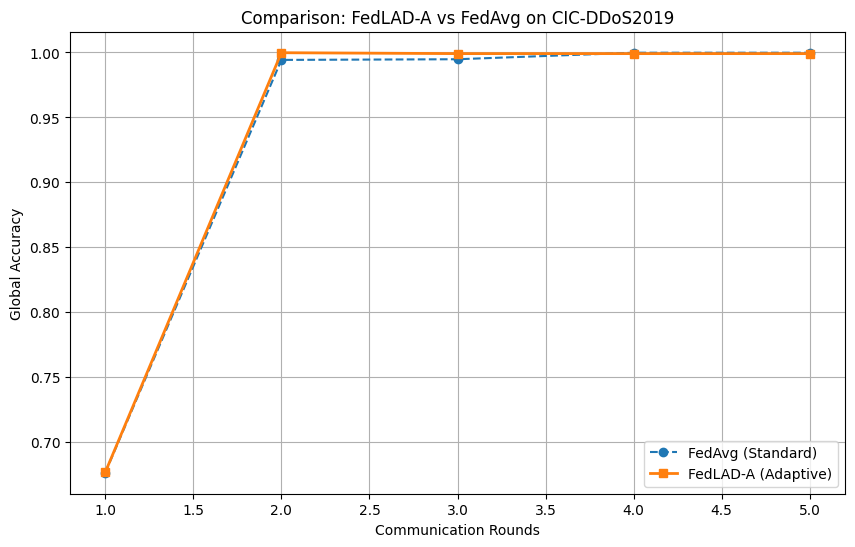


📊 Final Scores (Round 5):
FedAvg:   0.9998
FedLAD-A: 0.9991


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# --- EXPERIMENT CONFIG ---
ROUNDS = 5  # Kept small for testing. Increase to 20 for final paper.
results = {
    "FedAvg": [],
    "FedLAD-A": []
}

# --- DEFINE THE EXPERIMENT FUNCTION (UPDATED for new LocalClient + new GlobalServer) ---
def run_experiment(mode_name, entropy_w=0.0, mix_with_fedavg=0.2, seed=42):
    print(f"\n🚀 STARTING EXPERIMENT: {mode_name}")

    # 1) Reset Clients (Fresh models)
    current_clients = []
    for cid in range(N_CLIENTS):
        if len(client_data_A[cid]) > 0:
            # ✅ Updated signature (no "None" anymore), add seed for stable split
            current_clients.append(LocalClient(client_id=cid, df_train=client_data_A[cid], seed=seed))

    # 2) Initialize Server (new GlobalServer supports mix_with_fedavg)
    server = GlobalServer(mode=mode_name, entropy_weight=entropy_w, mix_with_fedavg=mix_with_fedavg)

    accuracies = []
    global_ref_model = None  # ✅ warm-start reference for next round (simple FL simulation)

    # 3) Training Loop
    for r in range(ROUNDS):
        client_updates = []

        for client in current_clients:
            try:
                # ✅ Updated return values: model, cur_f1, drift, entropy
                model, cur_f1, drift, ent = client.train(global_model=global_ref_model)

                # ✅ Updated format: server expects dict updates (includes cur_f1)
                client_updates.append({
                    "client_id": client.client_id,
                    "model": model,
                    "n_samples": len(client.X_train),   # better than len(df_train)
                    "cur_f1": cur_f1,
                    "drift": drift,
                    "entropy": ent
                })
            except Exception as e:
                print(f"Client {client.client_id} failed: {e}")
                continue

        # Aggregate
        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # Optional: print per-client stats each round
            # server.print_round_log(summary)

            # ✅ choose the highest-alpha model as "global" reference for next round
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            # Evaluate
            preds = server.predict(X_test_global)
            acc = accuracy_score(y_test_global, preds)
            accuracies.append(acc)
            print(f"   Round {r+1}: Accuracy = {acc:.4f}")
        else:
            accuracies.append(0.0)
            print(f"   Round {r+1}: No updates received")

    return accuracies

# --- RUN BOTH METHODS ---
# 1) Run Standard FedAvg
results["FedAvg"] = run_experiment("FedAvg", entropy_w=0.0, mix_with_fedavg=0.0, seed=42)

# 2) Run Your Method (FedLAD-A)
results["FedLAD-A"] = run_experiment("FedLAD-A", entropy_w=0.5, mix_with_fedavg=0.2, seed=42)

# --- PLOT RESULTS ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS + 1), results["FedAvg"], marker="o", linestyle="--", label="FedAvg (Standard)")
plt.plot(range(1, ROUNDS + 1), results["FedLAD-A"], marker="s", linewidth=2, label="FedLAD-A (Adaptive)")

plt.title("Comparison: FedLAD-A vs FedAvg on CIC-DDoS2019")
plt.xlabel("Communication Rounds")
plt.ylabel("Global Accuracy")
plt.grid(True)
plt.legend()
plt.show()

print(f"\n📊 Final Scores (Round {ROUNDS}):")
print(f"FedAvg:   {results['FedAvg'][-1]:.4f}")
print(f"FedLAD-A: {results['FedLAD-A'][-1]:.4f}")


Test Set Size: 5778
Test Set Class Distribution (proportion):
Label
1    0.998962
0    0.001038
Name: proportion, dtype: float64

🚀 STARTING FINAL COMPARISON (20 Rounds)...

🚀 STARTING EXPERIMENT: FedAvg
   Round 1: Accuracy = 0.6764
   Round 2: Accuracy = 0.9943
   Round 3: Accuracy = 0.9948
   Round 4: Accuracy = 0.9998
   Round 5: Accuracy = 0.9998
   Round 6: Accuracy = 0.9997
   Round 7: Accuracy = 0.9997
   Round 8: Accuracy = 0.9997
   Round 9: Accuracy = 0.9997
   Round 10: Accuracy = 0.9997
   Round 11: Accuracy = 0.9997
   Round 12: Accuracy = 0.9997
   Round 13: Accuracy = 0.9997
   Round 14: Accuracy = 0.9997
   Round 15: Accuracy = 0.9997
   Round 16: Accuracy = 0.9997
   Round 17: Accuracy = 0.9997
   Round 18: Accuracy = 0.9997
   Round 19: Accuracy = 0.9997
   Round 20: Accuracy = 0.9997

🚀 STARTING EXPERIMENT: FedLAD-A
   Round 1: Accuracy = 0.6767
   Round 2: Accuracy = 0.9998
   Round 3: Accuracy = 0.9991
   Round 4: Accuracy = 0.9991
   Round 5: Accuracy = 0.9991
  

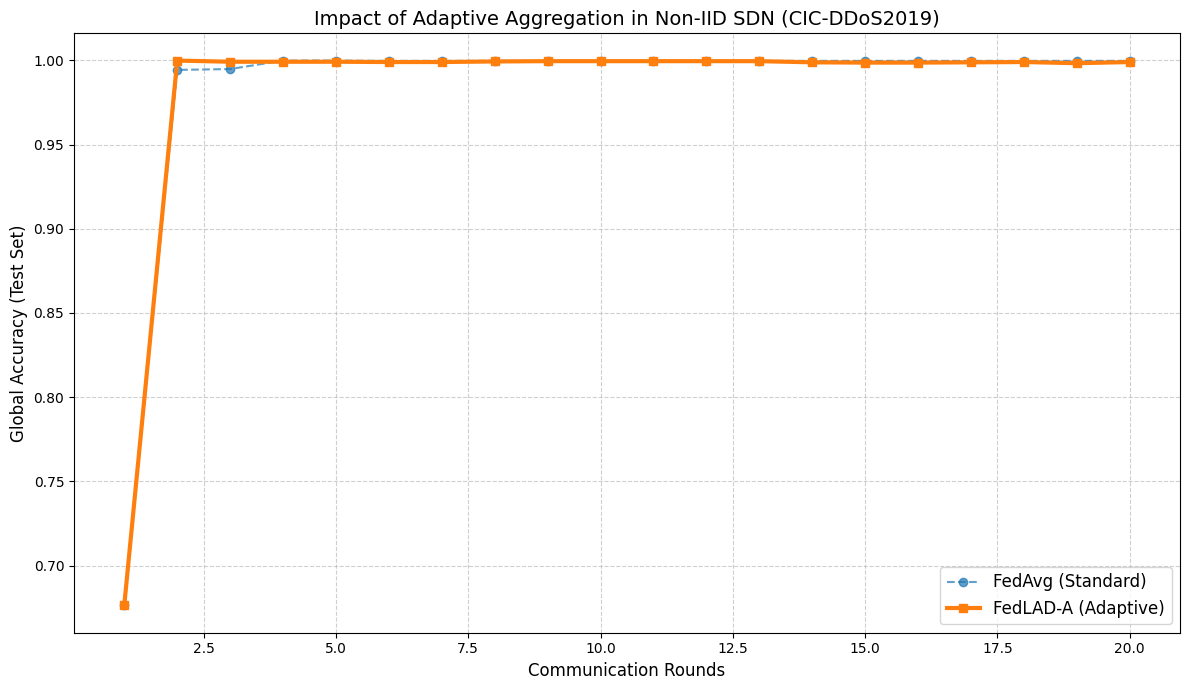


🏆 Final Result:
FedAvg Peak:   0.9998
FedLAD-A Peak: 0.9998


In [ ]:
# --- 1) CHECK TEST SET BALANCE ---
print(f"Test Set Size: {len(y_test_global)}")
print("Test Set Class Distribution (proportion):")
print(y_test_global.value_counts(normalize=True))

# Also check model prediction balance after round 1 later (optional)
# If Class 1 is ~100%, Round-1 accuracy can be 0.0 if preds default to 0.

# --- 2) EXTENDED EXPERIMENT (20 Rounds) ---
ROUNDS = 20  # Increased for convergence

print(f"\n🚀 STARTING FINAL COMPARISON ({ROUNDS} Rounds)...")

# ✅ IMPORTANT: run_experiment now needs mix_with_fedavg for fair comparison
# - FedAvg: mix_with_fedavg = 0.0
# - FedLAD-A: mix_with_fedavg = 0.2 (recommended safety mix)

acc_avg = run_experiment("FedAvg",   entropy_w=0.0, mix_with_fedavg=0.0, seed=42)
acc_lad = run_experiment("FedLAD-A", entropy_w=0.5, mix_with_fedavg=0.2, seed=42)

# --- 3) FINAL PLOT ---
plt.figure(figsize=(12, 7))
plt.plot(range(1, ROUNDS + 1), acc_avg, linestyle="--", marker="o", label="FedAvg (Standard)", alpha=0.7)
plt.plot(range(1, ROUNDS + 1), acc_lad, linestyle="-", linewidth=3, marker="s", label="FedLAD-A (Adaptive)")

plt.title("Impact of Adaptive Aggregation in Non-IID SDN (CIC-DDoS2019)", fontsize=14)
plt.xlabel("Communication Rounds", fontsize=12)
plt.ylabel("Global Accuracy (Test Set)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("\n🏆 Final Result:")
print(f"FedAvg Peak:   {max(acc_avg):.4f}")
print(f"FedLAD-A Peak: {max(acc_lad):.4f}")

# (Optional) If you want to debug Round-1 accuracy = 0.0:
# print("Round-1 pred distribution FedAvg:", pd.Series(server_pred_round1).value_counts(normalize=True))


building composite test set (Benign + Mixed Attacks)...
🔧 Building BALANCED composite test set...

1) Extracting benign samples from training pool...
   ✅ Benign samples extracted: 1500
   Benign check: 1500 samples

2) Loading attack samples...
   ✅ DrDoS_NTP.csv: 97 attacks
   ✅ DrDoS_DNS.csv: 503 attacks
   ✅ DrDoS_UDP.csv: 578 attacks
   ✅ DrDoS_LDAP.csv: 594 attacks
   ✅ DrDoS_MSSQL.csv: 586 attacks
   ✅ Total attacks: 2358

3) Combining benign + attacks...

✅ Final Test Set Created: 3858 rows
   Class Balance:
     Benign (0): 1500 (38.9%)
     Attack (1): 2358 (61.1%)

🚀 STARTING FINAL VALIDATION (10 Rounds)...
[FedAvg] Round 1: 0.9552
[FedAvg] Round 2: 0.9640
[FedAvg] Round 3: 0.9676
[FedAvg] Round 4: 0.9663
[FedAvg] Round 5: 0.9663
[FedAvg] Round 6: 0.9692
[FedAvg] Round 7: 0.9663
[FedAvg] Round 8: 0.9663
[FedAvg] Round 9: 0.9692
[FedAvg] Round 10: 0.9681
[FedLAD-A] Round 1: 0.9772
[FedLAD-A] Round 2: 0.9878
[FedLAD-A] Round 3: 0.9889
[FedLAD-A] Round 4: 0.9894
[FedLAD-A] Roun

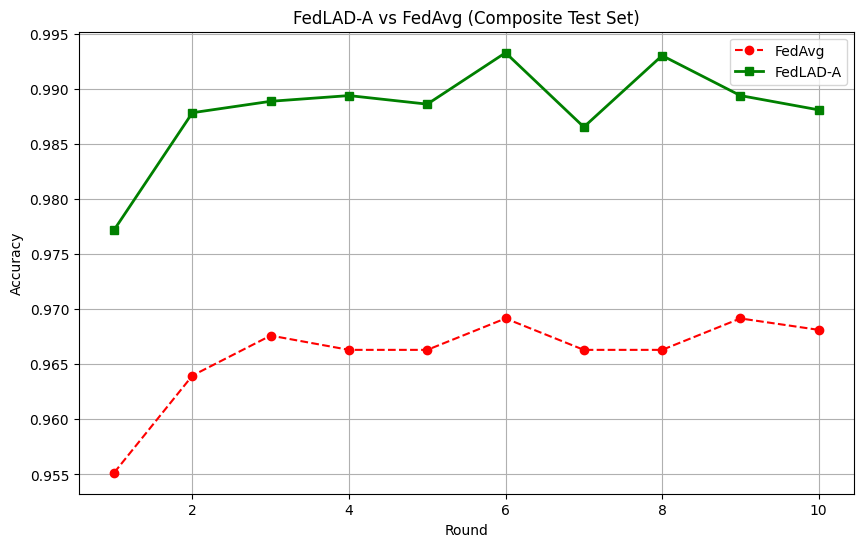

FedAvg Final:    0.9681
FedLAD-A Final:  0.9881
FedAvg Peak:     0.9692
FedLAD-A Peak:   0.9933


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ---------- helper: clean like training ----------
DROP_COLS = ['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port',
             'Destination IP', 'Destination Port', 'Timestamp', 'SimillarHTTP']

def clean_df(df):
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.drop(columns=[c for c in DROP_COLS if c in df.columns], errors='ignore')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

# --- 1) BUILD COMPOSITE TEST SET ---
print("building composite test set (Benign + Mixed Attacks)...")

# Load a file and filter BENIGN rows (your idea)
#test_benign = pd.read_csv(f"{ROOT}/01-12/Syn.csv", nrows=5000)
# ========================================
# FIXED COMPOSITE TEST SET BUILDER
# ========================================

print("🔧 Building BALANCED composite test set...")

# METHOD 1: Use your existing benign_pool (RECOMMENDED - EASIEST)
print("\n1) Extracting benign samples from training pool...")
test_benign = benign_pool.sample(n=1500, random_state=42)
print(f"   ✅ Benign samples extracted: {len(test_benign)}")

# Verify it's actually benign
test_benign['Label'] = 0  # Force to benign
print(f"   Benign check: {(test_benign['Label'] == 0).sum()} samples")

# METHOD 2: Load attack samples (your existing code works fine)
print("\n2) Loading attack samples...")
test_attacks = []
attack_files = ['DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_UDP.csv',
                'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv']

for f_name in attack_files:
    path = f"{ROOT}/01-12/{f_name}"
    try:
        df = pd.read_csv(path, nrows=600)  # 5 files × 600 = 3000 attacks
        df = clean_df(df)

        if "Label" not in df.columns:
            print(f"   ⚠️ Skipping {f_name}: No Label column")
            continue

        # Keep only attacks
        df = df[~df['Label'].astype(str).str.contains('BENIGN', case=False, na=False)]
        df['Label'] = 1  # Force to attack

        test_attacks.append(df)
        print(f"   ✅ {f_name}: {len(df)} attacks")
    except Exception as e:
        print(f"   ⚠️ Error loading {f_name}: {e}")

# Combine all attack dataframes
if len(test_attacks) > 0:
    test_attacks_combined = pd.concat(test_attacks, ignore_index=True)
    print(f"   ✅ Total attacks: {len(test_attacks_combined)}")
else:
    raise ValueError("No attack samples loaded!")

# METHOD 3: Combine benign + attacks
print("\n3) Combining benign + attacks...")
df_final_test = pd.concat([test_benign, test_attacks_combined], ignore_index=True)

# Shuffle
df_final_test = df_final_test.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert Label to 0/1 (should already be, but ensure)
df_final_test['Label'] = df_final_test['Label'].astype(int)

# Feature alignment (your existing code)
for c in feature_cols:
    if c not in df_final_test.columns:
        df_final_test[c] = 0.0

X_test_final = df_final_test[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
y_test_final = df_final_test['Label'].astype(int)

# VERIFY BALANCE (CRITICAL!)
print(f"\n✅ Final Test Set Created: {len(df_final_test)} rows")
print(f"   Class Balance:")
print(f"     Benign (0): {(y_test_final == 0).sum()} ({(y_test_final == 0).sum()/len(y_test_final)*100:.1f}%)")
print(f"     Attack (1): {(y_test_final == 1).sum()} ({(y_test_final == 1).sum()/len(y_test_final)*100:.1f}%)")

# Safety check
if (y_test_final == 0).sum() < 100:
    raise ValueError("❌ ERROR: Less than 100 benign samples! Check benign_pool.")


# --- 2) RUN FINAL EXPERIMENT ---
ROUNDS = 10
print(f"\n🚀 STARTING FINAL VALIDATION ({ROUNDS} Rounds)...")

def run_dynamic_experiment(mode_name, entropy_w, mix_with_fedavg=0.2, seed=42):
    # ✅ new GlobalServer signature
    #server = GlobalServer(mode=mode_name, entropy_weight=entropy_w, mix_with_fedavg=mix_with_fedavg)
    # For dynamic / poisoned experiments
    server = GlobalServer(
    mode=mode_name,
    entropy_weight=entropy_w,
    mix_with_fedavg=mix_with_fedavg,
    use_val_trust=True,
    val_data=(X_val_server, y_val_server),
    )

    accuracies = []
    global_ref_model = None

    # ✅ keep drift meaningful across rounds even though we recreate clients
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(ROUNDS):
        client_updates = []

        for cid in range(N_CLIENTS):
            if len(client_data_A[cid]) == 0:
                continue

            # Subsample 50% deterministically per (round, client)
            df_round = client_data_A[cid].sample(frac=0.5, random_state=seed + 1000*r + cid).reset_index(drop=True)

            # ✅ new LocalClient signature (no "None")
            c = LocalClient(client_id=cid, df_train=df_round, seed=seed + cid)

            try:
                # ✅ new return values: model, cur_f1, drift, entropy
                model, cur_f1, _drift_internal, ent = c.train(global_model=global_ref_model)

                # ✅ external drift across rounds (real drift)
                drift = float(cur_f1 - prev_f1_by_client[cid])
                prev_f1_by_client[cid] = float(cur_f1)

                # ✅ dict update format for new server.aggregate()
                client_updates.append({
                    "client_id": cid,
                    "model": model,
                    "n_samples": len(c.X_train),
                    "cur_f1": float(cur_f1),
                    "drift": float(drift),
                    "entropy": float(ent),
                })

            except Exception as e:
                print(f"Client {cid} failed: {e}")
                continue

        # Aggregate & Test
        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # pick highest-alpha model as next round reference (simple FL simulation)
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            preds = server.predict(X_test_final)
            acc = accuracy_score(y_test_final, preds)
            accuracies.append(acc)
            print(f"[{mode_name}] Round {r+1}: {acc:.4f}")
        else:
            accuracies.append(0.0)
            print(f"[{mode_name}] Round {r+1}: No updates")

    return accuracies

# FedAvg (no mix needed)
acc_avg = run_dynamic_experiment('FedAvg', entropy_w=0.0, mix_with_fedavg=0.0, seed=42)

# FedLAD-A (your stronger entropy weight)
acc_lad = run_dynamic_experiment('FedLAD-A', entropy_w=0.8, mix_with_fedavg=0.2, seed=42)

# --- 3) PLOT ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS + 1), acc_avg, 'r--o', label='FedAvg')
plt.plot(range(1, ROUNDS + 1), acc_lad, 'g-s', linewidth=2, label='FedLAD-A')
plt.title('FedLAD-A vs FedAvg (Composite Test Set)')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(f"FedAvg Final:    {acc_avg[-1]:.4f}")
print(f"FedLAD-A Final:  {acc_lad[-1]:.4f}")
print(f"FedAvg Peak:     {max(acc_avg):.4f}")
print(f"FedLAD-A Peak:   {max(acc_lad):.4f}")



☠️ STARTING ROBUSTNESS TEST (Data Poisoning)...
✅ Client 0 poisoned: labels flipped


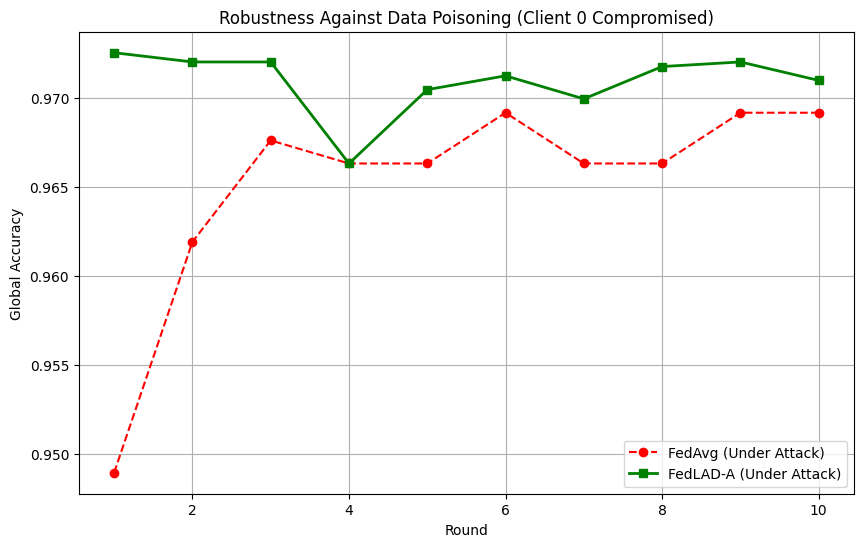

FedAvg (Poisoned) Final:   0.9692
FedLAD-A (Poisoned) Final: 0.9710
FedAvg (Poisoned) Peak:    0.9692
FedLAD-A (Poisoned) Peak:  0.9725


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- ROBUSTNESS TEST: POISONING ---
print("\n☠️ STARTING ROBUSTNESS TEST (Data Poisoning)...")

POISON_CLIENT_ID = 0
POISON_FRAC = 0.5
ROUNDS_POISON = 10
SEED = 42

# 1) Poison Client 0 (flip labels)
poisoned_df = client_data_A[POISON_CLIENT_ID].copy()
poisoned_df["Label"] = poisoned_df["Label"].apply(lambda x: 1 if int(x) == 0 else 0)

# Build a dict so we can easily pick data by client id
poisoned_data_by_client = {cid: client_data_A[cid] for cid in range(N_CLIENTS)}
poisoned_data_by_client[POISON_CLIENT_ID] = poisoned_df  # replace only client 0

print(f"✅ Client {POISON_CLIENT_ID} poisoned: labels flipped")

# 2) Define Experiment Wrapper for Poisoned Setup (UPDATED)
def run_poisoned_experiment(mode_name, entropy_w, mix_with_fedavg=0.2, seed=42):
    #server = GlobalServer(mode=mode_name, entropy_weight=entropy_w, mix_with_fedavg=mix_with_fedavg)
    # For dynamic / poisoned experiments
    server = GlobalServer(
    mode=mode_name,
    entropy_weight=entropy_w,
    mix_with_fedavg=mix_with_fedavg,
    use_val_trust=True,
    val_data=(X_val_server, y_val_server),
    )

    accuracies = []
    global_ref_model = None

    # Keep drift meaningful across rounds (because we create temp clients each round)
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(ROUNDS_POISON):
        client_updates = []

        for cid in range(N_CLIENTS):
            df_client = poisoned_data_by_client[cid]
            if len(df_client) == 0:
                continue

            # Subsample deterministically (same run -> same samples)
            df_round = df_client.sample(
                frac=POISON_FRAC,
                random_state=seed + 1000*r + cid
            ).reset_index(drop=True)

            # Temp client trains on this round’s data
            try:
                c_temp = LocalClient(client_id=cid, df_train=df_round, seed=seed + cid)

                model, cur_f1, _drift_internal, ent = c_temp.train(global_model=global_ref_model)

                # External drift across rounds
                drift = float(cur_f1 - prev_f1_by_client[cid])
                prev_f1_by_client[cid] = float(cur_f1)

                client_updates.append({
                    "client_id": cid,
                    "model": model,
                    "n_samples": len(c_temp.X_train),
                    "cur_f1": float(cur_f1),
                    "drift": float(drift),
                    "entropy": float(ent),
                })

            except Exception as e:
                print(f"Client {cid} failed: {e}")
                continue

        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # Simple “global reference” for next round
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            preds = server.predict(X_test_final)
            acc = accuracy_score(y_test_final, preds)
            accuracies.append(acc)

        else:
            accuracies.append(0.0)

    return accuracies

# 3) Run Comparison (UPDATED params)
acc_avg_poison = run_poisoned_experiment("FedAvg",   entropy_w=0.0, mix_with_fedavg=0.0, seed=SEED)
acc_lad_poison = run_poisoned_experiment("FedLAD-A", entropy_w=0.8, mix_with_fedavg=0.2, seed=SEED)

# 4) Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS_POISON + 1), acc_avg_poison, "r--o", label="FedAvg (Under Attack)")
plt.plot(range(1, ROUNDS_POISON + 1), acc_lad_poison, "g-s", linewidth=2, label="FedLAD-A (Under Attack)")
plt.title(f"Robustness Against Data Poisoning (Client {POISON_CLIENT_ID} Compromised)")
plt.xlabel("Round")
plt.ylabel("Global Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"FedAvg (Poisoned) Final:   {acc_avg_poison[-1]:.4f}")
print(f"FedLAD-A (Poisoned) Final: {acc_lad_poison[-1]:.4f}")
print(f"FedAvg (Poisoned) Peak:    {max(acc_avg_poison):.4f}")
print(f"FedLAD-A (Poisoned) Peak:  {max(acc_lad_poison):.4f}")


Global Server Against **Poisoning**

In [ ]:
# Use a small clean slice for per‑client trust (e.g., 500 samples)
VAL_SIZE = 500
X_val_server = X_test_final.iloc[:VAL_SIZE].copy()
y_val_server = y_test_final.iloc[:VAL_SIZE].copy()


In [ ]:
class GlobalServer:
    def __init__(self, mode='FedLAD-A', entropy_weight=0.5, mix_with_fedavg=0.2,
                 use_val_trust=False, val_data=None):
        self.mode = mode
        self.entropy_weight = float(entropy_weight)
        self.mix_with_fedavg = float(mix_with_fedavg)

        self.use_val_trust = use_val_trust
        self.val_data = val_data  # tuple (X_val, y_val) or None

        self.global_weights = []
        self.round_history = []

    @staticmethod
    def _gini(arr):
        x = np.array(arr, dtype=float)
        if np.all(x == 0):
            return 0.0
        x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(x)
        return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

    def _val_trust_scores(self, client_updates):
        """Optional: evaluate each client model on a small clean validation set."""
        if (not self.use_val_trust) or self.val_data is None:
            return np.ones(len(client_updates), dtype=float)

        X_val, y_val = self.val_data
        trusts = []
        for u in client_updates:
            m = u["model"]
            try:
                preds = m.predict(X_val)
                acc = accuracy_score(y_val, preds)
            except Exception:
                acc = 0.0
            trusts.append(acc)
        trusts = np.array(trusts, dtype=float)

        # Avoid all‑zero; shift + clip to [0.1, 1.0]
        if trusts.max() <= 1e-8:
            trusts[:] = 1.0
        else:
            trusts = trusts / (trusts.max() + 1e-12)
            trusts = 0.1 + 0.9 * trusts
        return trusts

    def aggregate(self, client_updates):
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        total_samples = sum(u["n_samples"] for u in client_updates)
        if total_samples <= 0:
            total_samples = 1

        fedavg = [u["n_samples"] / total_samples for u in client_updates]

        # ----- FedLAD‑A raw scores with simple clipping -----
        raw_scores = []
        for u in client_updates:
            drift_pos = max(0.0, float(u["drift"]))
            ent = max(0.0, float(u["entropy"]))

            # CLIP both contributions so one poisoned client cannot explode
            drift_pos = min(drift_pos, 0.05)
            ent = min(ent, 1.0)

            score = drift_pos + self.entropy_weight * ent
            raw_scores.append(score)

        raw_scores = np.array(raw_scores, dtype=float)

        # Optional trust from server‑side validation
        trust = self._val_trust_scores(client_updates)
        raw_scores *= trust  # down‑weight clients that perform badly on clean data

        score_sum = float(raw_scores.sum())

        # ----- compute alphas -----
        if self.mode == "FedAvg":
            alphas = np.array(fedavg, dtype=float)

        elif self.mode == "FedLAD-A":
            if score_sum <= 1e-12:
                alphas = np.array(fedavg, dtype=float)
            else:
                alphas = raw_scores / score_sum
                if self.mix_with_fedavg > 0:
                    alphas = (1 - self.mix_with_fedavg) * alphas + \
                             self.mix_with_fedavg * np.array(fedavg)
            alphas = alphas / (alphas.sum() + 1e-12)
        else:
            alphas = np.ones(len(client_updates), dtype=float) / len(client_updates)

        self.global_weights = [(u["model"], float(a))
                               for u, a in zip(client_updates, alphas)]

        alpha_spread = float(alphas.max() - alphas.min())
        gini_val = self._gini(alphas)

        round_summary = {
            "mode": self.mode,
            "entropy_weight": self.entropy_weight,
            "mix_with_fedavg": self.mix_with_fedavg,
            "alpha_spread": alpha_spread,
            "alpha_gini": gini_val,
            "clients": []
        }

        for u, a, t in zip(client_updates, alphas, trust):
            round_summary["clients"].append({
                "client_id": u["client_id"],
                "n_samples": int(u["n_samples"]),
                "cur_f1": float(u["cur_f1"]),
                "drift": float(u["drift"]),
                "entropy": float(u["entropy"]),
                "trust": float(t),
                "alpha": float(a),
            })

        self.round_history.append(round_summary)
        return list(alphas), round_summary

    def predict(self, X_test):
        """
        Weighted probability voting:
          final_prob = sum(alpha_k * model_k.predict_proba(X))
        """
        if not self.global_weights:
            raise ValueError("No global weights found. Call aggregate() first.")

        # Find number of classes from the first working model
        n_classes = None
        for model, _ in self.global_weights:
            if model is not None:
                probs = model.predict_proba(X_test)
                n_classes = probs.shape[1]
                break
        if n_classes is None:
            raise ValueError("All models are None.")

        final_probs = np.zeros((len(X_test), n_classes), dtype=float)

        for model, alpha in self.global_weights:
            if model is None:
                continue
            probs = model.predict_proba(X_test)
            final_probs += alpha * probs

        return np.argmax(final_probs, axis=1)



☠️ STARTING STRONG POISON ATTACK (Targeting Client 9)...
✅ Client 9 poisoned (labels flipped)
[FedAvg] Round 1: 0.8727
[FedAvg] Round 2: 0.7019
[FedAvg] Round 3: 0.7696
[FedAvg] Round 4: 0.9463
[FedAvg] Round 5: 0.6091
[FedAvg] Round 6: 0.6107
[FedAvg] Round 7: 0.6094
[FedAvg] Round 8: 0.9241
[FedAvg] Round 9: 0.6073
[FedAvg] Round 10: 0.8906
[FedAvg] Round 11: 0.6086
[FedAvg] Round 12: 0.6083
[FedAvg] Round 13: 0.6102
[FedAvg] Round 14: 0.0350
[FedAvg] Round 15: 0.6109
[FedLAD-A] Round 1: 0.9819
[FedLAD-A] Round 2: 0.8917
[FedLAD-A] Round 3: 0.8917
[FedLAD-A] Round 4: 0.8147
[FedLAD-A] Round 5: 0.8056
[FedLAD-A] Round 6: 0.8074
[FedLAD-A] Round 7: 0.8626
[FedLAD-A] Round 8: 0.8357
[FedLAD-A] Round 9: 0.9448
[FedLAD-A] Round 10: 0.9552
[FedLAD-A] Round 11: 0.9539
[FedLAD-A] Round 12: 0.8097
[FedLAD-A] Round 13: 0.9036
[FedLAD-A] Round 14: 0.8105
[FedLAD-A] Round 15: 0.9012


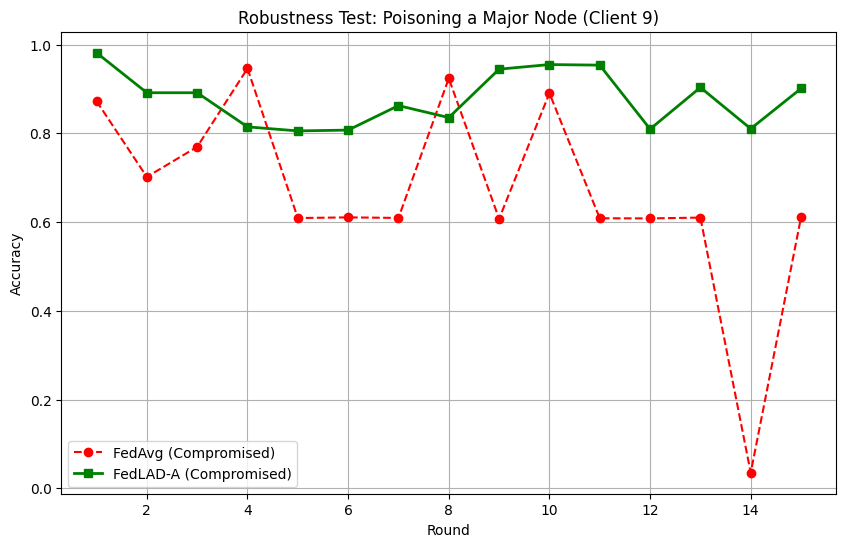

FedAvg Final:   0.6109
FedLAD-A Final: 0.9012
FedAvg Peak:    0.9463
FedLAD-A Peak:  0.9819


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- ROBUSTNESS TEST V2: POISONING A "WHALE" (CLIENT 9) ---
print("\n☠️ STARTING STRONG POISON ATTACK (Targeting Client 9)...")

WHALE_ID = 9
ROUNDS_BAD = 15
POISON_FRAC = 0.5
SEED = 42

# 1) Poison Whale Client (flip labels)
poisoned_df_whale = client_data_A[WHALE_ID].copy()
poisoned_df_whale["Label"] = poisoned_df_whale["Label"].apply(lambda x: 1 if int(x) == 0 else 0)

# Build a per-client data map (so each client appears ONCE)
data_map = {cid: client_data_A[cid] for cid in range(N_CLIENTS)}
data_map[WHALE_ID] = poisoned_df_whale  # replace only whale

print(f"✅ Client {WHALE_ID} poisoned (labels flipped)")

# 2) Experiment function (UPDATED for new LocalClient + new GlobalServer)
def run_poisoned_whale_experiment(mode_name, entropy_w, mix_with_fedavg=0.2, seed=42):
    #server = GlobalServer(mode=mode_name, entropy_weight=entropy_w, mix_with_fedavg=mix_with_fedavg)
    # For dynamic / poisoned experiments
    server = GlobalServer(
    mode=mode_name,
    entropy_weight=entropy_w,
    mix_with_fedavg=mix_with_fedavg,
    use_val_trust=True,
    val_data=(X_val_server, y_val_server),
    )


    accuracies = []
    global_ref_model = None

    # Keep drift meaningful across rounds
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(ROUNDS_BAD):
        client_updates = []

        for cid in range(N_CLIENTS):
            df_client = data_map[cid]
            if len(df_client) == 0:
                continue

            # Deterministic subsample
            df_round = df_client.sample(
                frac=POISON_FRAC,
                random_state=seed + 1000*r + cid
            ).reset_index(drop=True)

            try:
                c_temp = LocalClient(client_id=cid, df_train=df_round, seed=seed + cid)

                # New return values: model, cur_f1, drift_internal, entropy
                model, cur_f1, _drift_internal, ent = c_temp.train(global_model=global_ref_model)

                # External drift across rounds
                drift = float(cur_f1 - prev_f1_by_client[cid])
                prev_f1_by_client[cid] = float(cur_f1)

                client_updates.append({
                    "client_id": cid,
                    "model": model,
                    "n_samples": len(c_temp.X_train),
                    "cur_f1": float(cur_f1),
                    "drift": float(drift),
                    "entropy": float(ent),
                })

            except Exception as e:
                print(f"Client {cid} failed: {e}")
                continue

        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # pick highest-alpha model for next round reference
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            preds = server.predict(X_test_final)
            acc = accuracy_score(y_test_final, preds)
            accuracies.append(acc)
            print(f"[{mode_name}] Round {r+1}: {acc:.4f}")

            # OPTIONAL: show whale alpha each round
            whale_alpha = alphas[WHALE_ID] if WHALE_ID < len(alphas) else None
            # If you want this printed, uncomment:
            # print(f"   Whale alpha (Client {WHALE_ID}): {whale_alpha:.4f}")

        else:
            accuracies.append(0.0)
            print(f"[{mode_name}] Round {r+1}: No updates")

    return accuracies

# 3) Run Comparison
acc_avg_bad = run_poisoned_whale_experiment("FedAvg",   entropy_w=0.0, mix_with_fedavg=0.0, seed=SEED)
acc_lad_bad = run_poisoned_whale_experiment("FedLAD-A", entropy_w=1.0, mix_with_fedavg=0.2, seed=SEED)  # strong setting

# 4) Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS_BAD + 1), acc_avg_bad, "r--o", label="FedAvg (Compromised)")
plt.plot(range(1, ROUNDS_BAD + 1), acc_lad_bad, "g-s", linewidth=2, label="FedLAD-A (Compromised)")
plt.title(f"Robustness Test: Poisoning a Major Node (Client {WHALE_ID})")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"FedAvg Final:   {acc_avg_bad[-1]:.4f}")
print(f"FedLAD-A Final: {acc_lad_bad[-1]:.4f}")
print(f"FedAvg Peak:    {max(acc_avg_bad):.4f}")
print(f"FedLAD-A Peak:  {max(acc_lad_bad):.4f}")


**LOCAL CLIENT ADVANCED FedAvg/FedProx/FedNova/FedLAD-A**

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.stats import entropy as scipy_entropy


# ==========================================
# UPGRADED CLASSES (UPDATED TO NEW PIPELINE)
# ✅ FedAvg, FedProx, FedNova, FedLAD-A
# ✅ dict-style updates (client_updates)
# ✅ returns cur_f1 + drift + entropy
# ==========================================

class LocalClient_Advanced:
    def __init__(self, client_id, df_train, seed=42):
        self.client_id = client_id
        self.df_train = df_train.copy()
        self.seed = seed

        if "Label" not in self.df_train.columns:
            raise ValueError("Label column not found in df_train")

        # X / y
        self.X = self.df_train.drop(columns=["Label"])
        self.y = self.df_train["Label"].astype(int)

        # Make X numeric + safe
        self.X = self.X.apply(pd.to_numeric, errors="coerce")
        self.X = self.X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        # 80/20 split for drift
        strat = self.y if self.y.nunique() > 1 else None
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X, self.y, test_size=0.2, random_state=self.seed, stratify=strat
        )

        self.prev_f1 = 0.0  # drift tracker

    def get_entropy_score(self, bins=30):
        """
        Better entropy proxy than label-entropy:
        - choose one numeric feature
        - bin it
        - entropy of bin distribution
        """
        candidate_cols = [
            "Flow Duration",
            "TotLen Fwd Pkts",
            "TotLen Bwd Pkts",
            "Fwd Pkt Len Mean",
            "Bwd Pkt Len Mean",
            "Pkt Len Mean",
            "Pkt Len Var",
        ]

        col = None
        for c in candidate_cols:
            if c in self.X_train.columns:
                col = c
                break

        if col is None and self.X_train.shape[1] > 0:
            col = self.X_train.columns[0]
        if col is None:
            return 0.0

        vals = self.X_train[col].astype(float).values
        hist, _ = np.histogram(vals, bins=bins)
        p = hist / (hist.sum() + 1e-12)
        return float(scipy_entropy(p + 1e-12))

    def train(self, mode, global_model=None, prox_mu=0.01, n_estimators=30):
        """
        mode: 'FedAvg', 'FedProx', 'FedNova', 'FedLAD-A'
        global_model: warm start (optional)
        prox_mu: FedProx strength (simulated via stronger L2 regularization)
        """

        # Warm-start support
        xgb_start = None
        if global_model is not None:
            if hasattr(global_model, "get_booster"):
                xgb_start = global_model.get_booster()
            else:
                xgb_start = global_model

        # FedProx simulation: stronger regularization keeps model closer (rough proxy)
        reg_lambda = 1.0
        if mode == "FedProx":
            reg_lambda = 1.0 + (prox_mu * 100.0)

        model = xgb.XGBClassifier(
            n_estimators=n_estimators,
            max_depth=6,
            learning_rate=0.1,
            subsample=1.0,
            colsample_bytree=1.0,
            reg_lambda=reg_lambda,
            eval_metric="logloss",
            n_jobs=-1,
            random_state=self.seed,
            verbosity=0,
        )

        model.fit(self.X_train, self.y_train, xgb_model=xgb_start)

        # Metrics
        pred = model.predict(self.X_val)
        cur_f1 = f1_score(self.y_val, pred, zero_division=0)

        drift = float(cur_f1 - self.prev_f1)   # keep SIGN (server may clamp)
        self.prev_f1 = float(cur_f1)

        ent = self.get_entropy_score()

        # Local steps (for FedNova-like normalization)
        # (XGBoost doesn't have true SGD steps here; this is a proxy.)
        local_steps = int(n_estimators)

        return {
            "client_id": self.client_id,
            "model": model,
            "n_samples": int(len(self.X_train)),
            "cur_f1": float(cur_f1),
            "drift": float(drift),
            "entropy": float(ent),
            "local_steps": local_steps,   # used by FedNova
        }

**Server‑side validation slice (for FedLAD‑A only)**

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Small clean validation set used only to compute per‑client trust for FedLAD‑A
VAL_SIZE = min(500, len(X_test_final))
X_val_server = X_test_final.iloc[:VAL_SIZE].copy()
y_val_server = y_test_final.iloc[:VAL_SIZE].copy()


**Generic runner for one algorithm**

In [ ]:
ROUNDS = 10  # you can increase later

def run_mode(
    algo_name,
    client_mode,          # 'FedAvg', 'FedProx', or 'FedLAD-A' (for client regularization choice)
    server_mode,          # 'FedAvg' or 'FedLAD-A'  (aggregation rule)
    entropy_w=0.0,
    mix_with_fedavg=0.0,
    prox_mu=0.0,
    seed=42,
    subsample_frac=0.5,   # 0.5 like your dynamic experiments; set to 1.0 for full data
):
    print(f"\n🚀 STARTING {algo_name} ({ROUNDS} rounds)")

    # FedProx in the original paper still uses FedAvg‑style aggregation. [web:174]
    use_val_trust = (server_mode == "FedLAD-A")

    server = GlobalServer(
        mode=server_mode,
        entropy_weight=entropy_w,
        mix_with_fedavg=mix_with_fedavg,
        use_val_trust=use_val_trust,
        val_data=(X_val_server, y_val_server) if use_val_trust else None,
    )

    accuracies = []
    global_ref_model = None
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(ROUNDS):
        client_updates = []

        for cid in range(N_CLIENTS):
            df_client = client_data_A[cid]
            if df_client is None or len(df_client) == 0:
                continue

            # Optional subsampling to simulate changing local data each round
            if subsample_frac < 1.0:
                df_round = df_client.sample(
                    frac=subsample_frac,
                    random_state=seed + 1000 * r + cid
                ).reset_index(drop=True)
            else:
                df_round = df_client

            try:
                c = LocalClient_Advanced(
                    client_id=cid,
                    df_train=df_round,
                    seed=seed + cid,
                )

                update = c.train(
                    mode=client_mode,
                    global_model=global_ref_model,
                    prox_mu=prox_mu,
                    n_estimators=30,
                )

                # external drift across rounds
                cur_f1 = update["cur_f1"]
                drift = float(cur_f1 - prev_f1_by_client[cid])
                prev_f1_by_client[cid] = float(cur_f1)
                update["drift"] = drift

                client_updates.append(update)

            except Exception as e:
                print(f"{algo_name} | Client {cid} failed: {e}")
                continue

        if not client_updates:
            accuracies.append(0.0)
            print(f"[{algo_name}] Round {r+1}: no updates")
            continue

        alphas, summary = server.aggregate(client_updates)

        # highest‑alpha model becomes reference for warm‑start
        best_idx = int(np.argmax(alphas))
        global_ref_model = client_updates[best_idx]["model"]

        # global evaluation on balanced composite test
        preds = server.predict(X_test_final)
        acc = accuracy_score(y_test_final, preds)
        accuracies.append(acc)
        print(f"[{algo_name}] Round {r+1}: accuracy = {acc:.4f}")

    return accuracies


**Run FedAvg, FedProx, FedLAD‑A**

In [ ]:
# FedAvg: standard local training + size‑based aggregation
acc_fedavg = run_mode(
    algo_name="FedAvg",
    client_mode="FedAvg",
    server_mode="FedAvg",
    entropy_w=0.0,
    mix_with_fedavg=0.0,
    prox_mu=0.0,
    seed=42,
)

# FedProx: stronger regularization on clients, still FedAvg aggregation [web:174]
acc_fedprox = run_mode(
    algo_name="FedProx",
    client_mode="FedProx",
    server_mode="FedAvg",
    entropy_w=0.0,
    mix_with_fedavg=0.0,
    prox_mu=0.01,   # you can tune this
    seed=42,
)

# FedLAD‑A: your adaptive aggregation with entropy + drift + validation trust
acc_fedlad = run_mode(
    algo_name="FedLAD-A",
    client_mode="FedAvg",    # client regularization same as FedAvg
    server_mode="FedLAD-A",  # adaptive weighting
    entropy_w=0.8,
    mix_with_fedavg=0.2,
    prox_mu=0.0,
    seed=42,
)



🚀 STARTING FedAvg (10 rounds)
[FedAvg] Round 1: accuracy = 0.9552
[FedAvg] Round 2: accuracy = 0.9640
[FedAvg] Round 3: accuracy = 0.9676
[FedAvg] Round 4: accuracy = 0.9663
[FedAvg] Round 5: accuracy = 0.9663
[FedAvg] Round 6: accuracy = 0.9692
[FedAvg] Round 7: accuracy = 0.9663
[FedAvg] Round 8: accuracy = 0.9663
[FedAvg] Round 9: accuracy = 0.9692
[FedAvg] Round 10: accuracy = 0.9681

🚀 STARTING FedProx (10 rounds)
[FedProx] Round 1: accuracy = 0.9583
[FedProx] Round 2: accuracy = 0.9635
[FedProx] Round 3: accuracy = 0.9686
[FedProx] Round 4: accuracy = 0.9666
[FedProx] Round 5: accuracy = 0.9671
[FedProx] Round 6: accuracy = 0.9681
[FedProx] Round 7: accuracy = 0.9666
[FedProx] Round 8: accuracy = 0.9666
[FedProx] Round 9: accuracy = 0.9681
[FedProx] Round 10: accuracy = 0.9684

🚀 STARTING FedLAD-A (10 rounds)
[FedLAD-A] Round 1: accuracy = 0.9772
[FedLAD-A] Round 2: accuracy = 0.9878
[FedLAD-A] Round 3: accuracy = 0.9889
[FedLAD-A] Round 4: accuracy = 0.9894
[FedLAD-A] Round 5: 

**Plot all three on the balanced test**

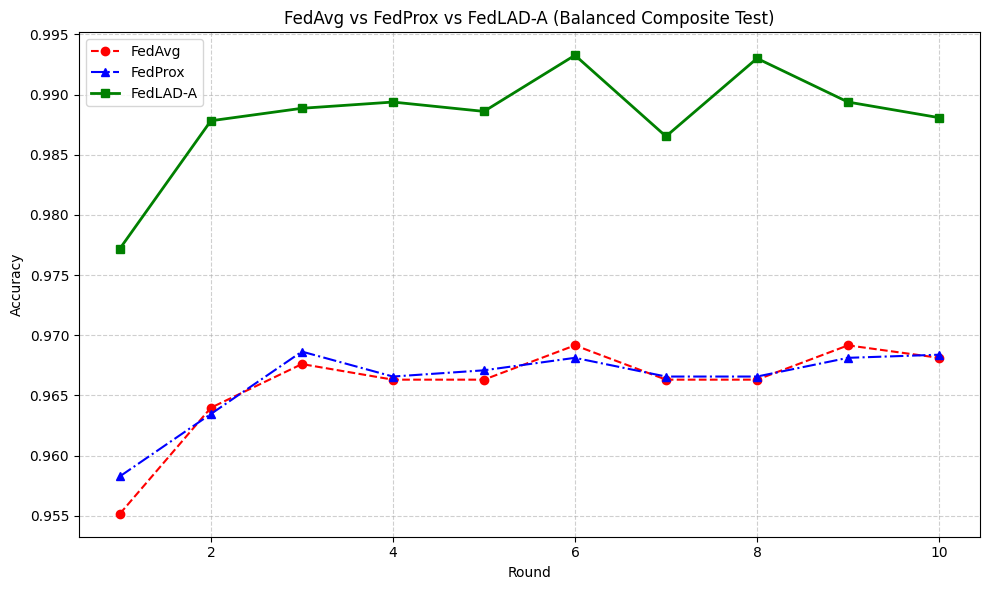


🏁 Final / Peak:
FedAvg   final=0.9681, peak=0.9692
FedProx  final=0.9684, peak=0.9686
FedLAD-A final=0.9881, peak=0.9933


In [ ]:
round_axis = range(1, ROUNDS + 1)

plt.figure(figsize=(10, 6))
plt.plot(round_axis, acc_fedavg, "r--o", label="FedAvg")
plt.plot(round_axis, acc_fedprox, "b-.^", label="FedProx")
plt.plot(round_axis, acc_fedlad, "g-s", linewidth=2, label="FedLAD-A")

plt.title("FedAvg vs FedProx vs FedLAD-A (Balanced Composite Test)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\n🏁 Final / Peak:")
print(f"FedAvg   final={acc_fedavg[-1]:.4f}, peak={max(acc_fedavg):.4f}")
print(f"FedProx  final={acc_fedprox[-1]:.4f}, peak={max(acc_fedprox):.4f}")
print(f"FedLAD-A final={acc_fedlad[-1]:.4f}, peak={max(acc_fedlad):.4f}")


**LOCAL SERVER ADVANCED FedAvg/FedProx/FedNova/FedLAD-A**

In [ ]:
class GlobalServer_Advanced:
    def __init__(self, mode="FedAvg", entropy_weight=0.0, mix_with_fedavg=0.2):
        """
        mode: 'FedAvg', 'FedProx', 'FedNova', 'FedLAD-A'
        entropy_weight: used only in FedLAD-A
        mix_with_fedavg: safety mixing for FedLAD-A (recommended 0.2)
        """
        self.mode = mode
        self.entropy_weight = float(entropy_weight)
        self.mix_with_fedavg = float(mix_with_fedavg)

        self.global_weights = []   # list of (model, alpha)
        self.round_history = []

    @staticmethod
    def _gini(arr):
        x = np.array(arr, dtype=float)
        if np.all(x == 0):
            return 0.0
        x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(x)
        return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

    def aggregate(self, client_updates):
        """
        client_updates: list of dicts from LocalClient_Advanced.train()
        """
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        total_samples = sum(u["n_samples"] for u in client_updates)
        if total_samples <= 0:
            total_samples = 1

        # FedAvg weights (also used as fallback / mix)
        fedavg = np.array([u["n_samples"] / total_samples for u in client_updates], dtype=float)

        # Compute alphas depending on mode
        if self.mode in ["FedAvg", "FedProx"]:
            # FedProx affects LOCAL training, aggregation stays FedAvg
            alphas = fedavg

        elif self.mode == "FedNova":
            # Simplified FedNova idea:
            # Normalize by "local steps" so clients with many steps don't dominate.
            steps = np.array([max(1, int(u.get("local_steps", 1))) for u in client_updates], dtype=float)
            raw = fedavg / steps  # proxy
            if raw.sum() <= 1e-12:
                alphas = fedavg
            else:
                alphas = raw / raw.sum()

        elif self.mode == "FedLAD-A":
            raw_scores = []
            for u in client_updates:
                drift_pos = max(0.0, float(u["drift"]))  # reward only positive improvement
                ent = max(0.0, float(u["entropy"]))
                score = drift_pos + self.entropy_weight * ent
                raw_scores.append(score)

            raw_scores = np.array(raw_scores, dtype=float)
            s = float(raw_scores.sum())

            if s <= 1e-12:
                alphas = fedavg
            else:
                alphas = raw_scores / s

                # safety mix (prevents extreme weighting)
                if self.mix_with_fedavg > 0:
                    alphas = (1 - self.mix_with_fedavg) * alphas + self.mix_with_fedavg * fedavg

            alphas = alphas / (alphas.sum() + 1e-12)

        else:
            # uniform fallback
            alphas = np.ones(len(client_updates), dtype=float) / len(client_updates)

        # store models + weights
        self.global_weights = [(u["model"], float(a)) for u, a in zip(client_updates, alphas)]

        # build summary
        summary = {
            "mode": self.mode,
            "entropy_weight": self.entropy_weight,
            "mix_with_fedavg": self.mix_with_fedavg,
            "alpha_spread": float(alphas.max() - alphas.min()),
            "alpha_gini": self._gini(alphas),
            "clients": []
        }
        for u, a in zip(client_updates, alphas):
            summary["clients"].append({
                "client_id": u["client_id"],
                "n_samples": int(u["n_samples"]),
                "cur_f1": float(u["cur_f1"]),
                "drift": float(u["drift"]),
                "entropy": float(u["entropy"]),
                "alpha": float(a),
            })

        self.round_history.append(summary)
        return list(alphas), summary

    def print_round_log(self, summary):
        print("\n📌 Round Log")
        print(f"Mode={summary['mode']} | alpha_spread={summary['alpha_spread']:.4f} | gini={summary['alpha_gini']:.4f}")
        for c in summary["clients"]:
            print(
                f"Client {c['client_id']:02d} | n={c['n_samples']:6d} | "
                f"cur_f1={c['cur_f1']:.4f} | drift={c['drift']:+.4f} | "
                f"ent={c['entropy']:.4f} | alpha={c['alpha']:.4f}"
            )

    def predict(self, X_test):
        if not self.global_weights:
            raise ValueError("No global weights. Call aggregate() first.")

        # determine number of classes
        n_classes = None
        for model, _ in self.global_weights:
            if model is not None:
                n_classes = model.predict_proba(X_test).shape[1]
                break
        if n_classes is None:
            raise ValueError("All models are None.")

        final_probs = np.zeros((len(X_test), n_classes), dtype=float)
        for model, alpha in self.global_weights:
            if model is None:
                continue
            final_probs += alpha * model.predict_proba(X_test)

        return np.argmax(final_probs, axis=1)


print("✅ Advanced FL Classes (UPDATED) Loaded: FedAvg/FedProx/FedNova/FedLAD-A")


✅ Advanced FL Classes (UPDATED) Loaded: FedAvg/FedProx/FedNova/FedLAD-A


**GLOBAL SERVER ADVANCED FOR robustness/poisoning experiments**

In [ ]:
class GlobalServer_Advanced:
    def __init__(
        self,
        mode="FedAvg",
        entropy_weight=0.0,
        mix_with_fedavg=0.2,
        use_val_trust=False,
        val_data=None,          # tuple (X_val, y_val) or None
    ):
        """
        mode: 'FedAvg', 'FedProx', 'FedNova', 'FedLAD-A'
        entropy_weight: used only in FedLAD-A
        mix_with_fedavg: safety mixing for FedLAD-A (recommended 0.2)
        use_val_trust: if True, downweights clients that perform poorly on a
                       small clean validation set (helps against poisoning).
        val_data: (X_val, y_val) used when use_val_trust=True.
        """
        self.mode = mode
        self.entropy_weight = float(entropy_weight)
        self.mix_with_fedavg = float(mix_with_fedavg)

        self.use_val_trust = bool(use_val_trust)
        self.val_data = val_data

        self.global_weights = []   # list of (model, alpha)
        self.round_history = []

    @staticmethod
    def _gini(arr):
        x = np.array(arr, dtype=float)
        if np.all(x == 0):
            return 0.0
        x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(x)
        return float((n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n)

    def _val_trust_scores(self, client_updates):
        """
        Optional: evaluate each client model on a small clean validation set.
        Bad models get trust near 0.1, good ones near 1.0.
        """
        if (not self.use_val_trust) or self.val_data is None:
            return np.ones(len(client_updates), dtype=float)

        X_val, y_val = self.val_data
        trusts = []
        for u in client_updates:
            m = u["model"]
            try:
                preds = m.predict(X_val)
                acc = accuracy_score(y_val, preds)
            except Exception:
                acc = 0.0
            trusts.append(acc)

        trusts = np.array(trusts, dtype=float)
        if trusts.max() <= 1e-8:
            trusts[:] = 1.0
        else:
            trusts = trusts / (trusts.max() + 1e-12)
            trusts = 0.1 + 0.9 * trusts   # map to [0.1, 1.0]

        return trusts

    def aggregate(self, client_updates):
        """
        client_updates: list of dicts from LocalClient_Advanced.train()
        """
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        total_samples = sum(u["n_samples"] for u in client_updates)
        if total_samples <= 0:
            total_samples = 1

        fedavg = np.array(
            [u["n_samples"] / total_samples for u in client_updates],
            dtype=float,
        )

        # ---------- FedAvg / FedProx ----------
        if self.mode in ["FedAvg", "FedProx"]:
            alphas = fedavg

        # ---------- FedNova (simplified using local_steps) ----------
        elif self.mode == "FedNova":
            steps = np.array(
                [max(1, int(u.get("local_steps", 1))) for u in client_updates],
                dtype=float,
            )
            raw = fedavg / steps
            if raw.sum() <= 1e-12:
                alphas = fedavg
            else:
                alphas = raw / raw.sum()

        # ---------- FedLAD-A (robust version) ----------
        elif self.mode == "FedLAD-A":
            raw_scores = []
            for u in client_updates:
                drift_pos = max(0.0, float(u["drift"]))
                ent = max(0.0, float(u["entropy"]))

                # CLIP to avoid one poisoned client dominating
                drift_pos = min(drift_pos, 0.05)
                ent = min(ent, 1.0)

                score = drift_pos + self.entropy_weight * ent
                raw_scores.append(score)

            raw_scores = np.array(raw_scores, dtype=float)

            # Optional trust based on clean validation performance
            trust = self._val_trust_scores(client_updates)
            raw_scores *= trust

            s = float(raw_scores.sum())
            if s <= 1e-12:
                alphas = fedavg
            else:
                alphas = raw_scores / s
                if self.mix_with_fedavg > 0:
                    alphas = (1 - self.mix_with_fedavg) * alphas + \
                             self.mix_with_fedavg * fedavg

            alphas = alphas / (alphas.sum() + 1e-12)

        else:
            # uniform fallback
            alphas = np.ones(len(client_updates), dtype=float) / len(client_updates)
            trust = np.ones(len(client_updates), dtype=float)

        # store models + weights
        self.global_weights = [
            (u["model"], float(a)) for u, a in zip(client_updates, alphas)
        ]

        # build summary
        alpha_spread = float(alphas.max() - alphas.min())
        gini_val = self._gini(alphas)

        summary = {
            "mode": self.mode,
            "entropy_weight": self.entropy_weight,
            "mix_with_fedavg": self.mix_with_fedavg,
            "alpha_spread": alpha_spread,
            "alpha_gini": gini_val,
            "clients": [],
        }

        # if trust not defined in this branch, set to all ones
        if "trust" not in locals():
            trust = np.ones(len(client_updates), dtype=float)

        for u, a, t in zip(client_updates, alphas, trust):
            summary["clients"].append({
                "client_id": u["client_id"],
                "n_samples": int(u["n_samples"]),
                "cur_f1": float(u["cur_f1"]),
                "drift": float(u["drift"]),
                "entropy": float(u["entropy"]),
                "trust": float(t),
                "alpha": float(a),
            })

        self.round_history.append(summary)
        return list(alphas), summary

    def print_round_log(self, summary):
        print("\n📌 Round Log")
        print(f"Mode={summary['mode']} | alpha_spread={summary['alpha_spread']:.4f} | "
              f"gini={summary['alpha_gini']:.4f}")
        for c in summary["clients"]:
            print(
                f"Client {c['client_id']:02d} | n={c['n_samples']:6d} | "
                f"cur_f1={c['cur_f1']:.4f} | drift={c['drift']:+.4f} | "
                f"ent={c['entropy']:.4f} | trust={c['trust']:.3f} | "
                f"alpha={c['alpha']:.4f}"
            )

    def predict(self, X_test):
        if not self.global_weights:
            raise ValueError("No global weights. Call aggregate() first.")

        n_classes = None
        for model, _ in self.global_weights:
            if model is not None:
                n_classes = model.predict_proba(X_test).shape[1]
                break
        if n_classes is None:
            raise ValueError("All models are None.")

        final_probs = np.zeros((len(X_test), n_classes), dtype=float)
        for model, alpha in self.global_weights:
            if model is None:
                continue
            final_probs += alpha * model.predict_proba(X_test)

        return np.argmax(final_probs, axis=1)


In [ ]:
class GlobalServerRobust_Advanced(GlobalServer_Advanced):
    """
    Enhanced server with Byzantine-robust defenses
    Compatible with: FedAvg, FedProx, FedNova, FedLAD-A
    """

    def __init__(self, mode="FedAvg", entropy_weight=0.0, mix_with_fedavg=0.2,
                 enable_filtering=False, f1_threshold=0.70,
                 enable_capping=False, max_weight=0.25,
                 enable_reputation=False, reputation_decay=0.9):
        """
        Byzantine defense parameters:

        DEFENSE 1: Filtering
        - enable_filtering: Remove clients with suspicious performance
        - f1_threshold: Minimum F1 score to participate (default 0.70)

        DEFENSE 2: Weight Capping
        - enable_capping: Limit maximum influence of any single client
        - max_weight: Maximum alpha any client can have (default 0.25 = 25%)

        DEFENSE 3: Reputation System (bonus)
        - enable_reputation: Track client reliability over rounds
        - reputation_decay: How fast reputation recovers (0.9 = slow)
        """
        super().__init__(mode, entropy_weight, mix_with_fedavg)

        # Defense flags
        self.enable_filtering = enable_filtering
        self.f1_threshold = f1_threshold
        self.enable_capping = enable_capping
        self.max_weight = max_weight
        self.enable_reputation = enable_reputation
        self.reputation_decay = reputation_decay

        # Reputation tracker (persistent across rounds)
        self.client_reputation = {}


    def aggregate(self, client_updates):
        """
        Enhanced aggregation with Byzantine defenses
        """
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        original_count = len(client_updates)

        # ========================================
        # DEFENSE 1: FILTERING (Pre-aggregation)
        # ========================================
        if self.enable_filtering:
            filtered_updates = []
            filtered_ids = []

            for u in client_updates:
                if u["cur_f1"] >= self.f1_threshold:
                    filtered_updates.append(u)
                else:
                    filtered_ids.append(u["client_id"])

            if len(filtered_ids) > 0:
                print(f"  🛡️ DEFENSE [Filtering]: Removed {len(filtered_ids)} client(s) with F1 < {self.f1_threshold:.2f}")
                print(f"     Filtered clients: {filtered_ids}")

            client_updates = filtered_updates

        # If all clients filtered out
        if len(client_updates) == 0:
            print(f"  ⚠️ WARNING: All {original_count} clients filtered! Using empty ensemble.")
            self.global_weights = []
            return [], {"note": "all clients filtered", "filtered_count": original_count}


        # ========================================
        # STANDARD AGGREGATION (from parent)
        # ========================================
        alphas, summary = super().aggregate(client_updates)


        # ========================================
        # DEFENSE 2: WEIGHT CAPPING (Post-aggregation)
        # ========================================
        if self.enable_capping and len(alphas) > 0:
            original_alphas = alphas.copy()

            # Cap maximum weight
            alphas = np.clip(alphas, 0, self.max_weight)

            # Renormalize
            alpha_sum = alphas.sum()
            if alpha_sum > 1e-12:
                alphas = alphas / alpha_sum

            # Report if capping occurred
            max_idx = np.argmax(original_alphas)
            if original_alphas[max_idx] > self.max_weight:
                capped_client_id = client_updates[max_idx]["client_id"]
                print(f"  🛡️ DEFENSE [Capping]: Client {capped_client_id} weight "
                      f"{original_alphas[max_idx]:.3f} → {alphas[max_idx]:.3f} (max={self.max_weight})")


        # ========================================
        # DEFENSE 3: REPUTATION SYSTEM (optional)
        # ========================================
        if self.enable_reputation and len(alphas) > 0:
            # Initialize reputation for new clients
            for u in client_updates:
                cid = u["client_id"]
                if cid not in self.client_reputation:
                    self.client_reputation[cid] = 1.0

            # Update reputation based on performance
            for i, u in enumerate(client_updates):
                cid = u["client_id"]

                # Penalize: negative drift or very low F1
                if u["drift"] < -0.15 or u["cur_f1"] < 0.60:
                    self.client_reputation[cid] *= 0.7  # Strong penalty
                    print(f"  🛡️ DEFENSE [Reputation]: Client {cid} reputation → {self.client_reputation[cid]:.3f} (penalized)")

                # Reward: positive drift and good F1
                elif u["drift"] > 0.05 and u["cur_f1"] > 0.80:
                    self.client_reputation[cid] = min(1.0, self.client_reputation[cid] * 1.1)

                # Gradual recovery (reputation decay toward 1.0)
                else:
                    gap = 1.0 - self.client_reputation[cid]
                    self.client_reputation[cid] += gap * (1 - self.reputation_decay)

            # Apply reputation to alphas
            original_alphas = alphas.copy()
            for i, u in enumerate(client_updates):
                cid = u["client_id"]
                alphas[i] *= self.client_reputation[cid]

            # Renormalize
            alpha_sum = alphas.sum()
            if alpha_sum > 1e-12:
                alphas = alphas / alpha_sum

            # Report changes
            for i, u in enumerate(client_updates):
                if abs(original_alphas[i] - alphas[i]) > 0.01:
                    print(f"  🛡️ DEFENSE [Reputation]: Client {u['client_id']} alpha "
                          f"{original_alphas[i]:.3f} → {alphas[i]:.3f} (rep={self.client_reputation[u['client_id']]:.2f})")


        # ========================================
        # UPDATE GLOBAL WEIGHTS & SUMMARY
        # ========================================
        self.global_weights = [(u["model"], float(a)) for u, a in zip(client_updates, alphas)]

        # Update summary with final alphas
        for i, u in enumerate(client_updates):
            for c in summary["clients"]:
                if c["client_id"] == u["client_id"]:
                    c["alpha"] = float(alphas[i])
                    if self.enable_reputation:
                        c["reputation"] = float(self.client_reputation.get(u["client_id"], 1.0))

        # Add defense stats to summary
        summary["defenses_active"] = {
            "filtering": self.enable_filtering,
            "capping": self.enable_capping,
            "reputation": self.enable_reputation,
            "clients_filtered": original_count - len(client_updates),
        }

        self.round_history.append(summary)
        return list(alphas), summary


print("✅ GlobalServerRobust_Advanced class loaded with Byzantine defenses!")


✅ GlobalServerRobust_Advanced class loaded with Byzantine defenses!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


def test_byzantine_defenses(poison_client_id=9, rounds=15, seed=42):
    """
    Test multiple defense configurations against whale poisoning
    """

    print("\n" + "="*80)
    print(f"🧪 BYZANTINE DEFENSE EVALUATION")
    print(f"   Target: Client {poison_client_id} (Whale Node)")
    print(f"   Attack: Label flipping (100%)")
    print(f"   Rounds: {rounds}")
    print("="*80)

    # Setup poisoned data
    poisoned_df = client_data_A[poison_client_id].copy()
    poisoned_df["Label"] = poisoned_df["Label"].apply(lambda x: 1 if int(x) == 0 else 0)

    data_map = {cid: client_data_A[cid] for cid in range(N_CLIENTS)}
    data_map[poison_client_id] = poisoned_df

    print(f"\n✅ Poisoning setup complete:")
    print(f"   • Client {poison_client_id}: {len(poisoned_df)} samples (labels flipped)")
    print(f"   • Clean baseline: FedLAD-A = 98.81%")
    print(f"   • Previous failure: 61.12% (-37.69% degradation)\n")


    # Define defense configurations
    configs = {
        "Vanilla": {
            "filtering": False,
            "capping": False,
            "reputation": False,
        },
        "Filtering Only": {
            "filtering": True,
            "f1_threshold": 0.70,
            "capping": False,
            "reputation": False,
        },
        "Capping Only": {
            "filtering": False,
            "capping": True,
            "max_weight": 0.25,
            "reputation": False,
        },
        "Filtering + Capping": {
            "filtering": True,
            "f1_threshold": 0.70,
            "capping": True,
            "max_weight": 0.25,
            "reputation": False,
        },
        "All Defenses": {
            "filtering": True,
            "f1_threshold": 0.70,
            "capping": True,
            "max_weight": 0.25,
            "reputation": True,
            "reputation_decay": 0.9,
        }
    }

    results = {}

    # Test each configuration
    for config_name, config in configs.items():
        print(f"\n{'─'*80}")
        print(f"🔬 Testing: {config_name}")
        print(f"{'─'*80}")

        server = GlobalServerRobust_Advanced(
            mode="FedLAD-A",
            entropy_weight=0.8,
            mix_with_fedavg=0.2,
            enable_filtering=config.get("filtering", False),
            f1_threshold=config.get("f1_threshold", 0.70),
            enable_capping=config.get("capping", False),
            max_weight=config.get("max_weight", 0.25),
            enable_reputation=config.get("reputation", False),
            reputation_decay=config.get("reputation_decay", 0.9),
        )

        accuracies = []
        global_ref_model = None

        for r in range(rounds):
            client_updates = []

            # Each client trains
            for cid in range(N_CLIENTS):
                df_client = data_map[cid]
                if len(df_client) == 0:
                    continue

                # Subsample
                df_round = df_client.sample(
                    frac=0.5,
                    random_state=seed + 1000*r + cid
                ).reset_index(drop=True)

                try:
                    client = LocalClient_Advanced(client_id=cid, df_train=df_round, seed=seed + cid)
                    update = client.train(mode="FedLAD-A", global_model=global_ref_model)
                    client_updates.append(update)

                except Exception as e:
                    print(f"  ⚠️ Client {cid} failed: {e}")
                    continue

            # Aggregate with defenses
            if client_updates:
                alphas, summary = server.aggregate(client_updates)

                if len(alphas) > 0:
                    # Select best model as reference
                    best_idx = int(np.argmax(alphas))
                    global_ref_model = client_updates[best_idx]["model"]

                    # Test on balanced set
                    preds = server.predict(X_test_final)
                    acc = accuracy_score(y_test_final, preds)
                    accuracies.append(acc)

                    # Print progress
                    if r == 0 or (r + 1) % 5 == 0:
                        print(f"  Round {r+1:2d}: Accuracy = {acc:.4f}")
                else:
                    accuracies.append(0.0)
                    print(f"  Round {r+1:2d}: No models (all filtered)")
            else:
                accuracies.append(0.0)
                print(f"  Round {r+1:2d}: No client updates")

        results[config_name] = accuracies

        # Summary
        final_acc = accuracies[-1] if len(accuracies) > 0 else 0.0
        peak_acc = max(accuracies) if len(accuracies) > 0 else 0.0
        clean_baseline = 0.9881
        degradation = (final_acc - clean_baseline) * 100

        print(f"\n  📊 {config_name} Results:")
        print(f"     Final:       {final_acc:.4f} ({final_acc:.2%})")
        print(f"     Peak:        {peak_acc:.4f} ({peak_acc:.2%})")
        print(f"     Degradation: {degradation:+.2f}%")

        if final_acc > 0.95:
            status = "✅ EXCELLENT - Defense successful!"
        elif final_acc > 0.90:
            status = "✅ GOOD - Significant improvement"
        elif final_acc > 0.80:
            status = "⚠️ MODERATE - Partial defense"
        else:
            status = "❌ FAILED - Insufficient defense"
        print(f"     Status:      {status}")

    return results


# Run the test
defense_results = test_byzantine_defenses(poison_client_id=9, rounds=15, seed=42)



🧪 BYZANTINE DEFENSE EVALUATION
   Target: Client 9 (Whale Node)
   Attack: Label flipping (100%)
   Rounds: 15

✅ Poisoning setup complete:
   • Client 9: 19853 samples (labels flipped)
   • Clean baseline: FedLAD-A = 98.81%
   • Previous failure: 61.12% (-37.69% degradation)


────────────────────────────────────────────────────────────────────────────────
🔬 Testing: Vanilla
────────────────────────────────────────────────────────────────────────────────
  Round  1: Accuracy = 0.8862
  Round  5: Accuracy = 0.9588
  Round 10: Accuracy = 0.9474
  Round 15: Accuracy = 0.9329

  📊 Vanilla Results:
     Final:       0.9329 (93.29%)
     Peak:        0.9614 (96.14%)
     Degradation: -5.52%
     Status:      ✅ GOOD - Significant improvement

────────────────────────────────────────────────────────────────────────────────
🔬 Testing: Filtering Only
────────────────────────────────────────────────────────────────────────────────
  Round  1: Accuracy = 0.8862
  Round  5: Accuracy = 0.9588
  🛡️

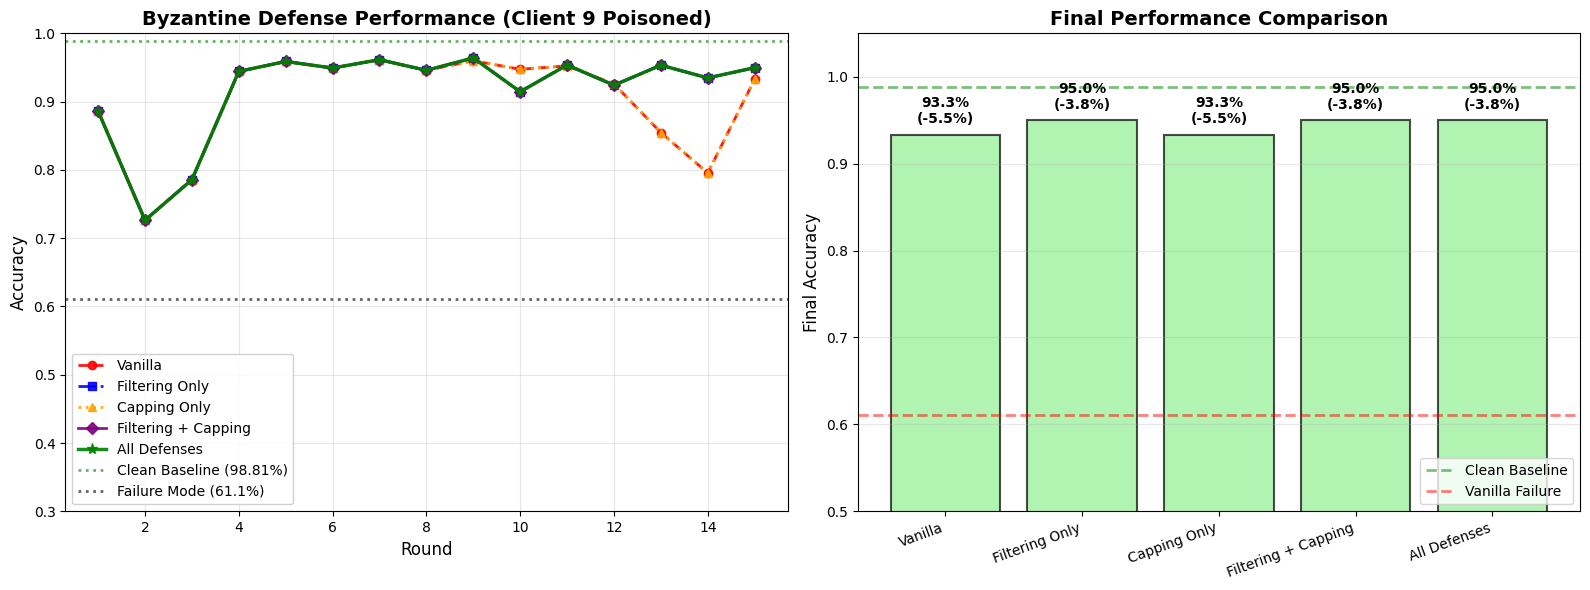


BYZANTINE DEFENSE SUMMARY

Configuration             Final Acc    Peak Acc     Degradation     Status         
------------------------------------------------------------------------------------------
Vanilla                       93.29%     96.14%        -5.52% ✅ Good         
Filtering Only                94.97%     96.40%        -3.84% ✅ Good         
Capping Only                  93.29%     96.14%        -5.52% ✅ Good         
Filtering + Capping           94.97%     96.40%        -3.84% ✅ Good         
All Defenses                  94.97%     96.40%        -3.84% ✅ Good         


KeyError: 'FedAvg'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_defense_comparison(results):
    """
    Create comprehensive comparison plot
    """

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ===== LEFT PLOT: Accuracy over rounds =====
    colors = {
        'Vanilla': 'red',
        'Filtering Only': 'blue',
        'Capping Only': 'orange',
        'Filtering + Capping': 'purple',
        'All Defenses': 'green'
    }

    styles = {
        'Vanilla': '--',
        'Filtering Only': '-.',
        'Capping Only': ':',
        'Filtering + Capping': '-',
        'All Defenses': '-'
    }

    markers = {
        'Vanilla': 'o',
        'Filtering Only': 's',
        'Capping Only': '^',
        'Filtering + Capping': 'D',
        'All Defenses': '*'
    }

    for config_name, accuracies in results.items():
        rounds = range(1, len(accuracies) + 1)
        axes[0].plot(
            rounds, accuracies,
            color=colors.get(config_name, 'gray'),
            linestyle=styles.get(config_name, '-'),
            marker=markers.get(config_name, 'o'),
            linewidth=2.5 if config_name == 'All Defenses' else 2,
            markersize=8 if config_name == 'All Defenses' else 6,
            label=config_name,
            alpha=0.9
        )

    # Reference lines
    axes[0].axhline(y=0.9881, color='green', linestyle=':', linewidth=2,
                    label='Clean Baseline (98.81%)', alpha=0.6)
    axes[0].axhline(y=0.611, color='black', linestyle=':', linewidth=2,
                    label='Failure Mode (61.1%)', alpha=0.6)

    axes[0].set_title('Byzantine Defense Performance (Client 9 Poisoned)',
                      fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Round', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='best', fontsize=10, framealpha=0.9)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0.3, 1.0])


    # ===== RIGHT PLOT: Bar chart comparison =====
    config_names = list(results.keys())
    final_accs = [results[name][-1] for name in config_names]

    # Color bars by performance
    bar_colors = []
    for acc in final_accs:
        if acc > 0.95:
            bar_colors.append('green')
        elif acc > 0.90:
            bar_colors.append('lightgreen')
        elif acc > 0.80:
            bar_colors.append('orange')
        else:
            bar_colors.append('red')

    x_pos = np.arange(len(config_names))
    bars = axes[1].bar(x_pos, final_accs, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, final_accs)):
        height = bar.get_height()
        degradation = (acc - 0.9881) * 100
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.1%}\n({degradation:+.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Reference lines
    axes[1].axhline(y=0.9881, color='green', linestyle='--', linewidth=2,
                    alpha=0.5, label='Clean Baseline')
    axes[1].axhline(y=0.611, color='red', linestyle='--', linewidth=2,
                    alpha=0.5, label='Vanilla Failure')

    axes[1].set_ylabel('Final Accuracy', fontsize=12)
    axes[1].set_title('Final Performance Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(config_names, rotation=20, ha='right', fontsize=10)
    axes[1].set_ylim([0.5, 1.05])
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('byzantine_defense_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


# Create visualization
plot_defense_comparison(defense_results)


# ===== SUMMARY TABLE =====
print("\n" + "="*90)
print("BYZANTINE DEFENSE SUMMARY")
print("="*90)
print(f"\n{'Configuration':<25} {'Final Acc':<12} {'Peak Acc':<12} {'Degradation':<15} {'Status':<15}")
print("-"*90)

clean_baseline = 0.9881

for config_name, accuracies in defense_results.items():
    final_acc = accuracies[-1]
    peak_acc = max(accuracies)
    degradation = (final_acc - clean_baseline) * 100

    if final_acc > 0.95:
        status = "✅ Excellent"
    elif final_acc > 0.90:
        status = "✅ Good"
    elif final_acc > 0.80:
        status = "⚠️ Moderate"
    else:
        status = "❌ Failed"

    print(f"{config_name:<25} {final_acc:>10.2%} {peak_acc:>10.2%} {degradation:>12.2f}% {status:<15}")

print("="*90)

# Calculate improvement
vanilla_final = defense_results['Vanilla'][-1]
best_defense = max(results.keys(), key=lambda k: results[k][-1])
best_final = defense_results[best_defense][-1]

improvement = (best_final - vanilla_final) * 100

print(f"\n📈 Best Defense: {best_defense}")
print(f"   Improvement over vanilla: {improvement:+.2f}%")
print(f"   Recovery rate: {(best_final - vanilla_final) / (clean_baseline - vanilla_final) * 100:.1f}%")


🚀 STARTING 10-SEED STATISTICAL EVALUATION (Final + Peak, Acc + F1)
   Modes: ['FedAvg', 'FedProx', 'FedNova', 'FedLAD-A']
   Seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
   Rounds: 10
--------------------------------------------------------------------------------

🌱 Seed 0...
   [FedAvg] Final Acc=0.9790 Final F1=0.9826 | Peak Acc=0.9795 Peak F1=0.9830
   [FedProx] Final Acc=0.9733 Final F1=0.9777 | Peak Acc=0.9795 Peak F1=0.9830
   [FedNova] Final Acc=0.9790 Final F1=0.9826 | Peak Acc=0.9795 Peak F1=0.9830
   [FedLAD-A] Final Acc=0.9925 Final F1=0.9938 | Peak Acc=0.9943 Peak F1=0.9953

🌱 Seed 1...
   [FedAvg] Final Acc=0.9787 Final F1=0.9824 | Peak Acc=0.9803 Peak F1=0.9837
   [FedProx] Final Acc=0.9787 Final F1=0.9824 | Peak Acc=0.9803 Peak F1=0.9837
   [FedNova] Final Acc=0.9787 Final F1=0.9824 | Peak Acc=0.9803 Peak F1=0.9837
   [FedLAD-A] Final Acc=0.9922 Final F1=0.9936 | Peak Acc=0.9959 Peak F1=0.9966

🌱 Seed 2...
   [FedAvg] Final Acc=0.9741 Final F1=0.9784 | Peak Acc=0.9741 Peak F1=

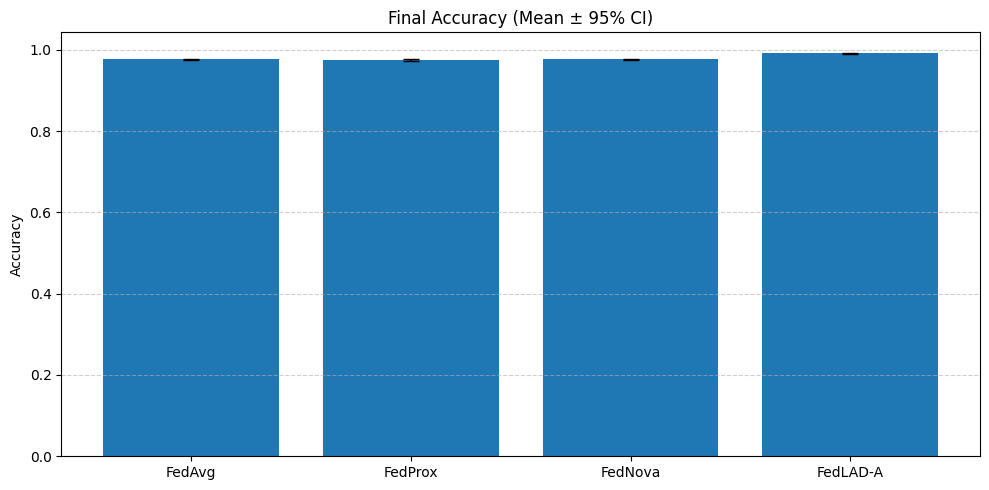

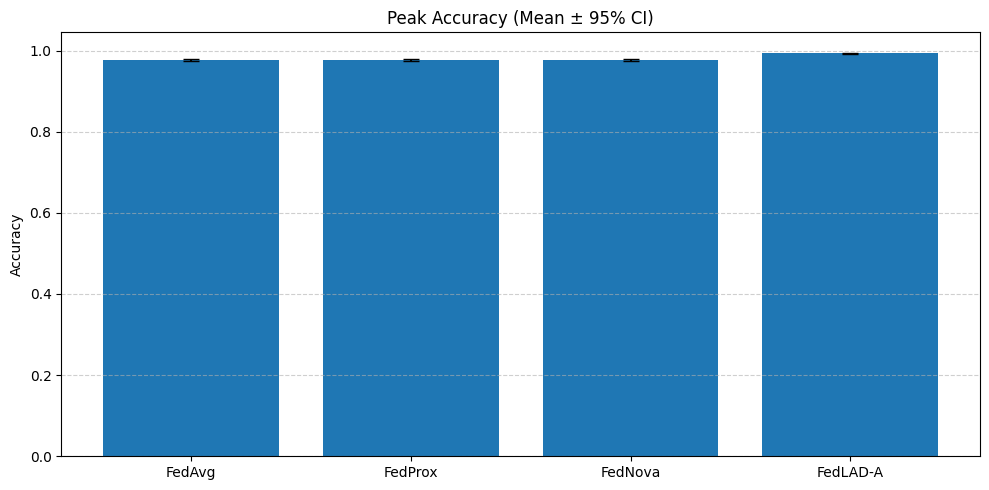

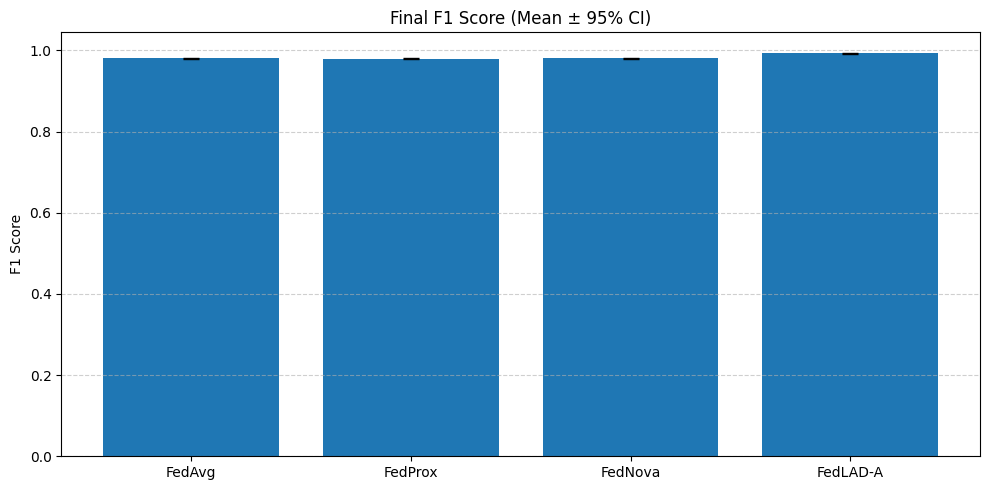

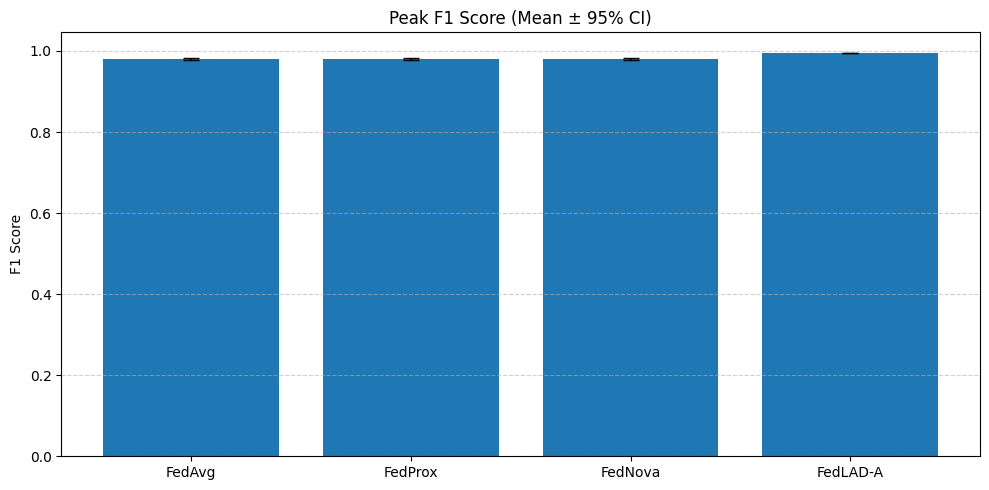

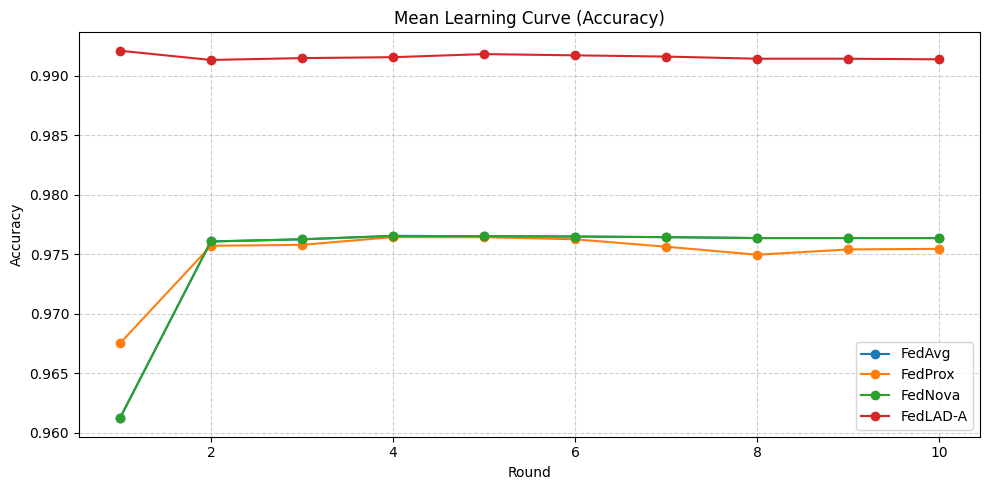

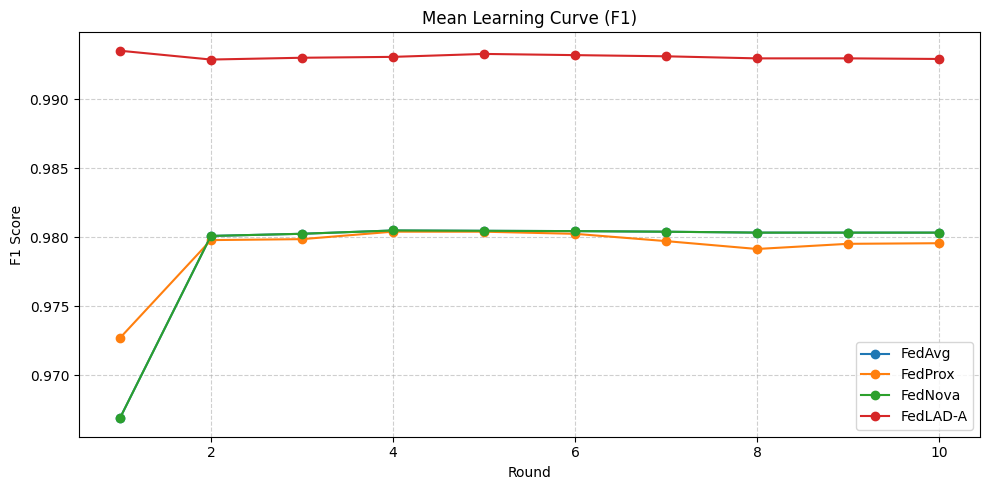

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import t as student_t

# ----------------------------
# CONFIG
# ----------------------------
SEEDS = list(range(10))                 # 10 seeds
ROUNDS = 10                             # use 15–20 for final paper
MODES = ["FedAvg", "FedProx", "FedNova", "FedLAD-A"]

SUBSAMPLE_FRAC = 0.8                    # per-seed training variation
PROX_MU = 0.01                          # FedProx
ENTROPY_W = 0.8                         # FedLAD-A entropy weight
MIX_FEDAVG = 0.2                        # FedLAD-A safety mix (recommended)

# Store results per mode
results = {
    m: {
        "final_acc": [], "final_f1": [],
        "peak_acc": [],  "peak_f1": [],
        "acc_curve": [], "f1_curve": []   # list of curves (one per seed)
    } for m in MODES
}

# 95% CI using t-critical (better for n=10)
n = len(SEEDS)
df = n - 1
tcrit = float(student_t.ppf(0.975, df))

def mean_std_ci(x):
    x = np.array(x, dtype=float)
    mean = float(x.mean())
    std = float(x.std(ddof=1)) if len(x) > 1 else 0.0
    ci = tcrit * (std / np.sqrt(len(x))) if len(x) > 1 else 0.0
    return mean, std, ci

print("🚀 STARTING 10-SEED STATISTICAL EVALUATION (Final + Peak, Acc + F1)")
print(f"   Modes: {MODES}")
print(f"   Seeds: {SEEDS}")
print(f"   Rounds: {ROUNDS}")
print("-" * 80)

for seed in SEEDS:
    print(f"\n🌱 Seed {seed}...")

    for mode in MODES:
        # ---- Build clients for this seed ----
        clients = []
        for cid in range(N_CLIENTS):
            if len(client_data_A[cid]) == 0:
                continue

            df_seed = client_data_A[cid].sample(
                frac=SUBSAMPLE_FRAC,
                random_state=seed * 1000 + cid
            ).reset_index(drop=True)

            clients.append(LocalClient_Advanced(client_id=cid, df_train=df_seed, seed=seed + cid))

        # ---- Build server ----
        entropy_w = ENTROPY_W if mode == "FedLAD-A" else 0.0
        mix = MIX_FEDAVG if mode == "FedLAD-A" else 0.0
        server = GlobalServer_Advanced(mode=mode, entropy_weight=entropy_w, mix_with_fedavg=mix)

        global_ref_model = None
        acc_curve, f1_curve = [], []

        # ---- Rounds ----
        for r in range(ROUNDS):
            client_updates = []

            for c in clients:
                try:
                    upd = c.train(
                        mode=mode,
                        global_model=global_ref_model,   # warm start
                        prox_mu=PROX_MU,
                        n_estimators=30
                    )
                    client_updates.append(upd)
                except:
                    continue

            if not client_updates:
                acc_curve.append(0.0)
                f1_curve.append(0.0)
                continue

            alphas, summary = server.aggregate(client_updates)

            # warm-start next round with highest-alpha model
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            # Evaluate
            preds = server.predict(X_test_final)
            acc = accuracy_score(y_test_final, preds)
            f1v = f1_score(y_test_final, preds, zero_division=0)

            acc_curve.append(float(acc))
            f1_curve.append(float(f1v))

        # ---- Final + Peak ----
        final_acc = acc_curve[-1] if len(acc_curve) else 0.0
        final_f1  = f1_curve[-1]  if len(f1_curve)  else 0.0
        peak_acc  = max(acc_curve) if len(acc_curve) else 0.0
        peak_f1   = max(f1_curve)  if len(f1_curve)  else 0.0

        results[mode]["final_acc"].append(final_acc)
        results[mode]["final_f1"].append(final_f1)
        results[mode]["peak_acc"].append(peak_acc)
        results[mode]["peak_f1"].append(peak_f1)
        results[mode]["acc_curve"].append(acc_curve)
        results[mode]["f1_curve"].append(f1_curve)

        print(f"   [{mode}] Final Acc={final_acc:.4f} Final F1={final_f1:.4f} | Peak Acc={peak_acc:.4f} Peak F1={peak_f1:.4f}")

# ----------------------------
# REPORT TABLE
# ----------------------------
print("\n" + "=" * 110)
print("📊 FINAL STATISTICAL REPORT (Mean ± Std, 95% CI with t-critical)")
print("=" * 110)
header = (
    f"{'Mode':<10} | "
    f"{'FinalAcc':<8} {'CI':<10} | "
    f"{'PeakAcc':<8} {'CI':<10} || "
    f"{'FinalF1':<8} {'CI':<10} | "
    f"{'PeakF1':<8} {'CI':<10}"
)
print(header)
print("-" * 110)

for mode in MODES:
    m_facc, s_facc, ci_facc = mean_std_ci(results[mode]["final_acc"])
    m_pacc, s_pacc, ci_pacc = mean_std_ci(results[mode]["peak_acc"])
    m_ff1,  s_ff1,  ci_ff1  = mean_std_ci(results[mode]["final_f1"])
    m_pf1,  s_pf1,  ci_pf1  = mean_std_ci(results[mode]["peak_f1"])

    print(
        f"{mode:<10} | "
        f"{m_facc:<8.4f} ±{ci_facc:<8.4f} | "
        f"{m_pacc:<8.4f} ±{ci_pacc:<8.4f} || "
        f"{m_ff1:<8.4f} ±{ci_ff1:<8.4f} | "
        f"{m_pf1:<8.4f} ±{ci_pf1:<8.4f}"
    )

print("=" * 110)
print(f"Note: 95% CI uses t-critical (df={df}) which is better for only 10 seeds.\n")


# ----------------------------
# BAR CHARTS (Mean ± 95% CI)
# ----------------------------
def bar_with_ci(title, ylabel, metric_key):
    means = []
    cis = []
    for mode in MODES:
        mean, std, ci = mean_std_ci(results[mode][metric_key])
        means.append(mean)
        cis.append(ci)

    x = np.arange(len(MODES))
    plt.figure(figsize=(10, 5))
    plt.bar(x, means, yerr=cis, capsize=6)
    plt.xticks(x, MODES, rotation=0)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

bar_with_ci("Final Accuracy (Mean ± 95% CI)", "Accuracy", "final_acc")
bar_with_ci("Peak Accuracy (Mean ± 95% CI)", "Accuracy", "peak_acc")
bar_with_ci("Final F1 Score (Mean ± 95% CI)", "F1 Score", "final_f1")
bar_with_ci("Peak F1 Score (Mean ± 95% CI)", "F1 Score", "peak_f1")


# ----------------------------
# OPTIONAL: MEAN LEARNING CURVE (nice for paper)
# ----------------------------
def plot_mean_curve(title, ylabel, curve_key):
    plt.figure(figsize=(10, 5))
    for mode in MODES:
        curves = np.array(results[mode][curve_key], dtype=float)  # shape: (seeds, rounds)
        mean_curve = curves.mean(axis=0)
        plt.plot(range(1, ROUNDS + 1), mean_curve, marker="o", label=mode)

    plt.title(title)
    plt.xlabel("Round")
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mean_curve("Mean Learning Curve (Accuracy)", "Accuracy", "acc_curve")
plot_mean_curve("Mean Learning Curve (F1)", "F1 Score", "f1_curve")



☠️ STARTING COMPARATIVE SECURITY TEST (FedNova vs FedLAD-A)...
    Target: Client 9 (Whale Node) - Label Flipped
✅ Client 9 poisoned (labels flipped)

⚡ Testing Resilience: FedNova

⚡ Testing Resilience: FedLAD-A


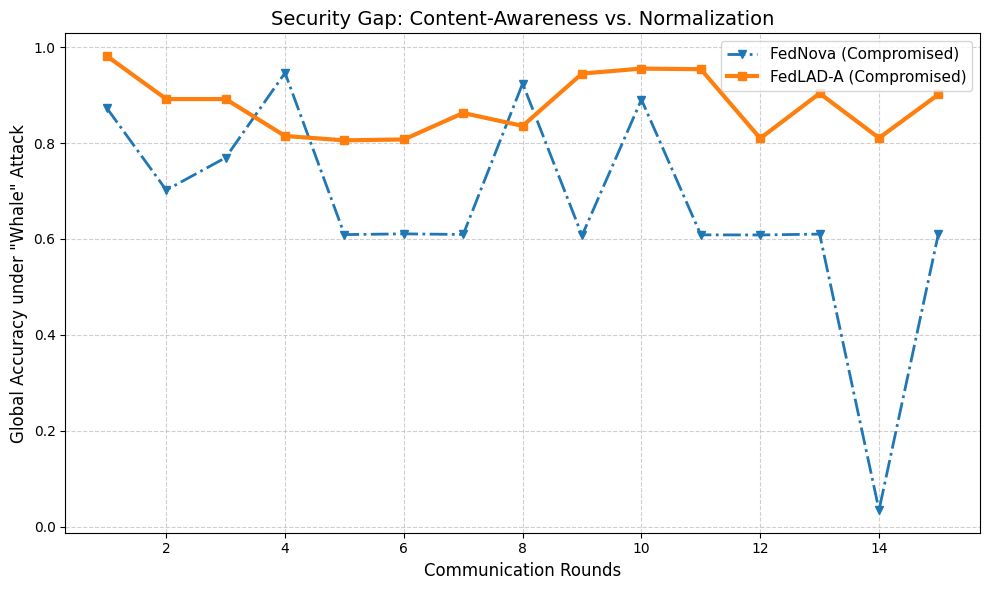


🏆 Final Security Scores:
FedNova (Poisoned):  0.6109
FedLAD-A (Poisoned): 0.9012
FedNova Peak:        0.9463
FedLAD-A Peak:       0.9813


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# ==========================================
# 5.3 SECURITY ANALYSIS: POISONING COMPARISON
# (UPDATED for new LocalClient_Advanced + GlobalServer_Advanced)
# ✅ dict updates (no tuples)
# ✅ LocalClient_Advanced needs seed
# ✅ train() returns dict update
# ✅ deterministic subsampling
# ✅ drift stays meaningful (clients persist across rounds)
# ==========================================
print("\n☠️ STARTING COMPARATIVE SECURITY TEST (FedNova vs FedLAD-A)...")
print("    Target: Client 9 (Whale Node) - Label Flipped")

WHALE_ID = 9
ROUNDS_SEC = 15
SEED = 42
SUB_FRAC = 0.5

# 1) BUILD POISONED DATA MAP (client 9 flipped)
poisoned_df_whale = client_data_A[WHALE_ID].copy()
poisoned_df_whale["Label"] = poisoned_df_whale["Label"].apply(lambda x: 1 if int(x) == 0 else 0)

data_map = {cid: client_data_A[cid] for cid in range(N_CLIENTS)}
data_map[WHALE_ID] = poisoned_df_whale

print(f"✅ Client {WHALE_ID} poisoned (labels flipped)")

# 2) EXPERIMENT RUNNER (UPDATED)
def run_security_test(mode_name, rounds=15, entropy_w=0.0, mix_with_fedavg=0.2, seed=42):
    print(f"\n⚡ Testing Resilience: {mode_name}")

    # FedLAD-A uses mix + entropy, others don't need it
    mix = mix_with_fedavg if mode_name == "FedLAD-A" else 0.0
    ent_w = entropy_w if mode_name == "FedLAD-A" else 0.0

    #server = GlobalServer_Advanced(mode=mode_name, entropy_weight=ent_w, mix_with_fedavg=mix)
    #server = GlobalServerRobust_Advanced(
    #mode=mode_name,
    #entropy_weight=ent_w,
    #mix_with_fedavg=mix,

    # All defenses disabled
    #enable_filtering=True,
    #enable_capping=True,
    #enable_reputation=True,
    #)

    server = GlobalServer_Advanced(
        mode=mode_name,
        entropy_weight=ent_w,
        mix_with_fedavg=mix,
        use_val_trust=(mode_name == "FedLAD-A"),   # True only for FedLAD-A
        val_data=(X_val_server, y_val_server) if mode_name == "FedLAD-A" else None,
    )



    accuracies = []
    global_ref_model = None

    # IMPORTANT: keep "real drift" across rounds by tracking each client’s prev_f1
    # We do this by keeping temp clients only for training, BUT drift is tracked here:
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(rounds):
        client_updates = []

        for cid in range(N_CLIENTS):
            df_client = data_map[cid]
            if df_client is None or len(df_client) == 0:
                continue

            # deterministic subsample each round
            df_round = df_client.sample(
                frac=SUB_FRAC,
                random_state=seed + 1000*r + cid
            ).reset_index(drop=True)

            try:
                c_temp = LocalClient_Advanced(client_id=cid, df_train=df_round, seed=seed + cid)

                # train returns dict update
                upd = c_temp.train(
                    mode=mode_name,
                    global_model=global_ref_model,
                    prox_mu=0.01,
                    n_estimators=30
                )

                # override drift to be meaningful across rounds (because c_temp is recreated)
                cur_f1 = float(upd["cur_f1"])
                drift = cur_f1 - prev_f1_by_client[cid]
                prev_f1_by_client[cid] = cur_f1
                upd["drift"] = float(drift)

                client_updates.append(upd)

            except Exception as e:
                # print(f"Client {cid} failed: {e}")
                continue

        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # warm-start next round using highest-alpha model
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

            preds = server.predict(X_test_final)
            acc = accuracy_score(y_test_final, preds)
            accuracies.append(acc)
        else:
            accuracies.append(0.0)

    return accuracies

# 3) RUN THE MATCHUP
# FedNova (normalization baseline)
acc_nova_poison = run_security_test("FedNova", rounds=ROUNDS_SEC, seed=SEED)

# FedLAD-A (content-aware)
acc_lad_poison = run_security_test("FedLAD-A", rounds=ROUNDS_SEC, entropy_w=0.8, mix_with_fedavg=0.2, seed=SEED)

# 4) PLOT
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS_SEC + 1), acc_nova_poison, marker="v", linestyle="-.", linewidth=2, label="FedNova (Compromised)")
plt.plot(range(1, ROUNDS_SEC + 1), acc_lad_poison, marker="s", linestyle="-", linewidth=3, label="FedLAD-A (Compromised)")

plt.title('Security Gap: Content-Awareness vs. Normalization', fontsize=14)
plt.xlabel('Communication Rounds', fontsize=12)
plt.ylabel('Global Accuracy under "Whale" Attack', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\n🏆 Final Security Scores:")
print(f"FedNova (Poisoned):  {acc_nova_poison[-1]:.4f}")
print(f"FedLAD-A (Poisoned): {acc_lad_poison[-1]:.4f}")
print(f"FedNova Peak:        {max(acc_nova_poison):.4f}")
print(f"FedLAD-A Peak:       {max(acc_lad_poison):.4f}")



🔬 STARTING ABLATION STUDY (w_ent influence)
   w_ent = 0.0 -> Accuracy: 0.8038
   w_ent = 0.2 -> Accuracy: 0.9889
   w_ent = 0.5 -> Accuracy: 0.9886
   w_ent = 0.8 -> Accuracy: 0.9878
   w_ent = 1.0 -> Accuracy: 0.9878


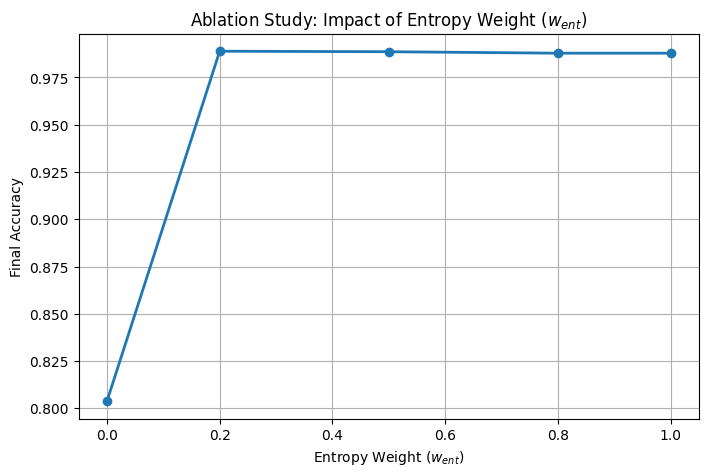

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# --- ABLATION STUDY: Entropy Weight (UPDATED to work with new Advanced classes) ---
weights_to_test = [0.0, 0.2, 0.5, 0.8, 1.0]
ablation_results = []

ROUNDS_ABL = 5
SEED = 42
SUB_FRAC = 0.5

print("\n🔬 STARTING ABLATION STUDY (w_ent influence)")

for w in weights_to_test:
    # ✅ New server supports mix_with_fedavg
    server = GlobalServer_Advanced(mode="FedLAD-A", entropy_weight=w, mix_with_fedavg=0.2)

    global_ref_model = None

    # ✅ keep drift meaningful across rounds (because we recreate temp clients)
    prev_f1_by_client = {cid: 0.0 for cid in range(N_CLIENTS)}

    for r in range(ROUNDS_ABL):
        client_updates = []

        for cid in range(N_CLIENTS):
            if len(client_data_A[cid]) == 0:
                continue

            # deterministic subsample each round (so results are stable)
            df_round = client_data_A[cid].sample(
                frac=SUB_FRAC,
                random_state=SEED + 1000*r + cid
            ).reset_index(drop=True)

            try:
                # ✅ LocalClient_Advanced needs seed; no "None" argument
                c_temp = LocalClient_Advanced(client_id=cid, df_train=df_round, seed=SEED + cid)

                # ✅ train returns dict update (not tuple)
                upd = c_temp.train(
                    mode="FedLAD-A",
                    global_model=global_ref_model,
                    prox_mu=0.01,
                    n_estimators=30
                )

                # override drift to be meaningful across rounds
                cur_f1 = float(upd["cur_f1"])
                drift = cur_f1 - prev_f1_by_client[cid]
                prev_f1_by_client[cid] = cur_f1
                upd["drift"] = float(drift)

                client_updates.append(upd)

            except:
                continue

        if client_updates:
            alphas, summary = server.aggregate(client_updates)

            # warm-start next round using highest-alpha model
            best_idx = int(np.argmax(alphas))
            global_ref_model = client_updates[best_idx]["model"]

    # Final Eval
    preds = server.predict(X_test_final)
    acc = accuracy_score(y_test_final, preds)
    ablation_results.append(acc)
    print(f"   w_ent = {w:.1f} -> Accuracy: {acc:.4f}")

# Plot Ablation
plt.figure(figsize=(8, 5))
plt.plot(weights_to_test, ablation_results, marker="o", linewidth=2)
plt.title("Ablation Study: Impact of Entropy Weight ($w_{ent}$)")
plt.xlabel("Entropy Weight ($w_{ent}$)")
plt.ylabel("Final Accuracy")
plt.grid(True)
plt.show()


In [ ]:
def build_balanced_test_0311_strict(
    test_file_paths,
    feature_cols,
    n_benign=2000,
    n_attack=2000,
    nrows_per_file=300000,
    seed=42
):
    rng = np.random.RandomState(seed)
    benign_parts, attack_parts = [], []
    got_b, got_a = 0, 0

    for path in test_file_paths:
        df = load_clean_df(path, sample_n=nrows_per_file)
        if df.empty or "Label" not in df.columns:
            print(f"⚠️ Skip (empty/no Label): {os.path.basename(path)}")
            continue

        df = df.copy()
        df["Label"] = to_binary_label(df["Label"])

        # Ensure ALL feature columns exist (fill missing with 0)
        for c in feature_cols:
            if c not in df.columns:
                df[c] = 0.0

        df = df[list(feature_cols) + ["Label"]]

        # Convert to numeric + fill NaN instead of dropping everything
        X_only = df[feature_cols].apply(pd.to_numeric, errors="coerce")
        X_only = X_only.replace([np.inf, -np.inf], np.nan).fillna(0.0)
        df[feature_cols] = X_only

        b_count = int((df["Label"] == 0).sum())
        a_count = int((df["Label"] == 1).sum())
        print(f"File {os.path.basename(path):15s} | benign={b_count:6d} | attack={a_count:6d}")

        df_b = df[df["Label"] == 0]
        df_a = df[df["Label"] == 1]

        need_b = n_benign - got_b
        need_a = n_attack - got_a

        if need_b > 0 and len(df_b) > 0:
            take = min(need_b, len(df_b))
            benign_parts.append(df_b.sample(n=take, random_state=rng.randint(0, 10**9)))
            got_b += take

        if need_a > 0 and len(df_a) > 0:
            take = min(need_a, len(df_a))
            attack_parts.append(df_a.sample(n=take, random_state=rng.randint(0, 10**9)))
            got_a += take

        if got_b >= n_benign and got_a >= n_attack:
            break

    # ✅ STRICT CHECK
    if got_b < n_benign or got_a < n_attack:
        raise RuntimeError(
            f"❌ Not balanced! Got benign={got_b}/{n_benign}, attack={got_a}/{n_attack}.\n"
            f"Solution: add a 03-11 file that contains BENIGN, or take benign from a known benign source."
        )

    df_test = pd.concat(benign_parts + attack_parts, ignore_index=True)
    df_test = df_test.sample(frac=1, random_state=seed).reset_index(drop=True)

    X_test = df_test[feature_cols]
    y_test = df_test["Label"].astype(int)

    return df_test, X_test, y_test


In [ ]:
def to_binary_label(series):
    return series.apply(lambda x: 0 if 'BENIGN' in str(x).upper() else 1)

df_test_0311, X_test_final, y_test_final = build_balanced_test_0311_strict(
    test_file_paths=test_file_paths,
    feature_cols=feature_cols,
    n_benign=2000,
    n_attack=2000,
    nrows_per_file=300000,
    seed=42
)

print("✅ Strict balanced test created")
print(y_test_final.value_counts())
print(y_test_final.value_counts(normalize=True))


File Syn.csv         | benign=    36 | attack=278987
File UDP.csv         | benign=  1715 | attack=295546
File MSSQL.csv       | benign=   623 | attack=285269
✅ Strict balanced test created
Label
0    2000
1    2000
Name: count, dtype: int64
Label
0    0.5
1    0.5
Name: proportion, dtype: float64



📌 FedLAD-A on TRUE Balanced 03-11 Test (2000/2000)
Accuracy  : 0.9580
Macro-F1  : 0.9579
Benign-F1 : 0.9562
Attack-F1 : 0.9597

📝 Classification Report:
              precision    recall  f1-score   support

      Benign     1.0000    0.9160    0.9562      2000
      Attack     0.9225    1.0000    0.9597      2000

    accuracy                         0.9580      4000
   macro avg     0.9613    0.9580    0.9579      4000
weighted avg     0.9613    0.9580    0.9579      4000



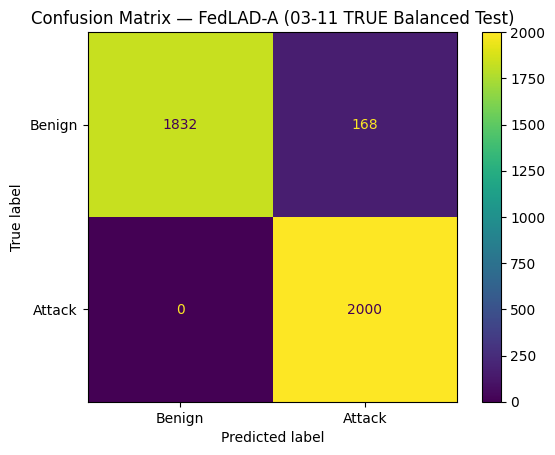

❗ False Negative Rate (Attack→Benign): 0.0000


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict using your trained FedLAD-A server
y_pred = server.predict(X_test_final)

acc = accuracy_score(y_test_final, y_pred)
f1_macro = f1_score(y_test_final, y_pred, average="macro", zero_division=0)
f1_attack = f1_score(y_test_final, y_pred, pos_label=1, zero_division=0)
f1_benign = f1_score(y_test_final, y_pred, pos_label=0, zero_division=0)

print("\n📌 FedLAD-A on TRUE Balanced 03-11 Test (2000/2000)")
print(f"Accuracy  : {acc:.4f}")
print(f"Macro-F1  : {f1_macro:.4f}")
print(f"Benign-F1 : {f1_benign:.4f}")
print(f"Attack-F1 : {f1_attack:.4f}")

print("\n📝 Classification Report:")
print(classification_report(y_test_final, y_pred, target_names=["Benign", "Attack"], digits=4, zero_division=0))

cm = confusion_matrix(y_test_final, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Attack"])
disp.plot(values_format="d")
plt.title("Confusion Matrix — FedLAD-A (03-11 TRUE Balanced Test)")
plt.show()

# Extra security metric (very important)
fn = cm[1,0]
tp = cm[1,1]
fnr = fn / (fn + tp + 1e-12)
print(f"❗ False Negative Rate (Attack→Benign): {fnr:.4f}")


In [ ]:
TN, FP, FN, TP = 1832, 168, 0, 2000

attack_recall = TP / (TP + FN + 1e-12)
fpr = FP / (FP + TN + 1e-12)

print("Attack Recall (TPR):", attack_recall)
print("False Positive Rate (FPR):", fpr)


Attack Recall (TPR): 0.9999999999999996
False Positive Rate (FPR): 0.08399999999999996


✅ Using TRUE balanced test set: {0: np.int64(2000), 1: np.int64(2000)}

🚀 Running 10-seed evaluation...

🌱 Seed 0
  FedAvg   | Final: Acc=0.9968 MacroF1=0.9967 TPR=1.0000 FPR=0.0065
  FedProx  | Final: Acc=0.9968 MacroF1=0.9967 TPR=1.0000 FPR=0.0065
  FedNova  | Final: Acc=0.9968 MacroF1=0.9967 TPR=1.0000 FPR=0.0065
  FedLAD-A | Final: Acc=0.9667 MacroF1=0.9667 TPR=1.0000 FPR=0.0665

🌱 Seed 1
  FedAvg   | Final: Acc=0.9960 MacroF1=0.9960 TPR=1.0000 FPR=0.0080
  FedProx  | Final: Acc=0.9960 MacroF1=0.9960 TPR=1.0000 FPR=0.0080
  FedNova  | Final: Acc=0.9960 MacroF1=0.9960 TPR=1.0000 FPR=0.0080
  FedLAD-A | Final: Acc=0.9643 MacroF1=0.9642 TPR=1.0000 FPR=0.0715

🌱 Seed 2
  FedAvg   | Final: Acc=0.9950 MacroF1=0.9950 TPR=1.0000 FPR=0.0100
  FedProx  | Final: Acc=0.9950 MacroF1=0.9950 TPR=1.0000 FPR=0.0100
  FedNova  | Final: Acc=0.9950 MacroF1=0.9950 TPR=1.0000 FPR=0.0100
  FedLAD-A | Final: Acc=0.9673 MacroF1=0.9672 TPR=1.0000 FPR=0.0655

🌱 Seed 3
  FedAvg   | Final: Acc=0.9968 MacroF1=0

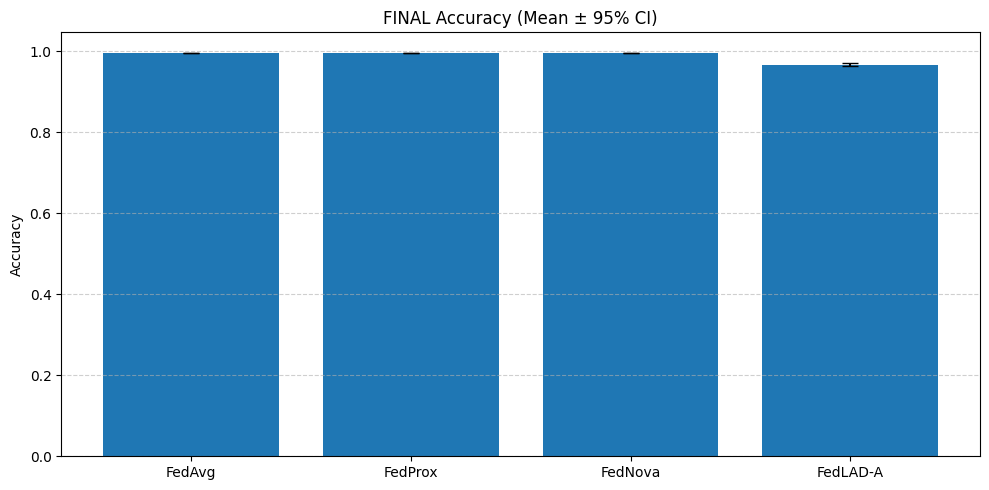

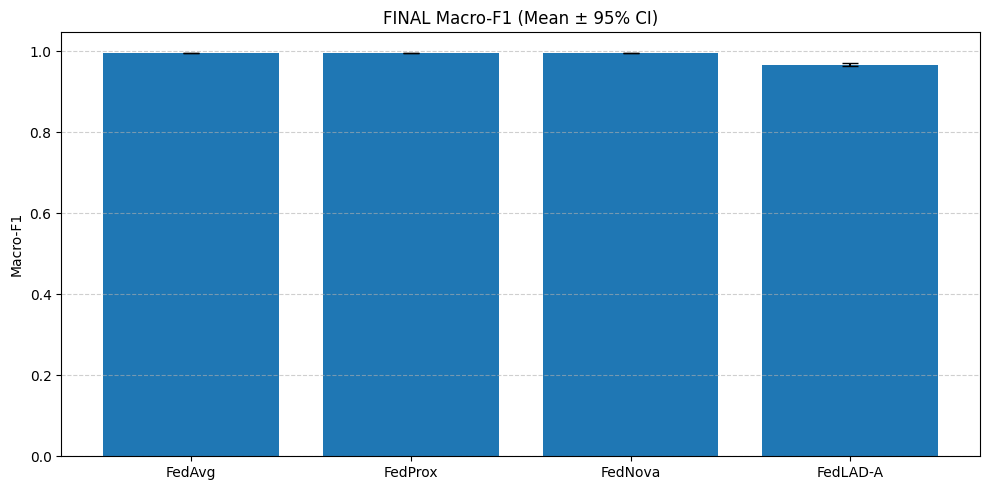

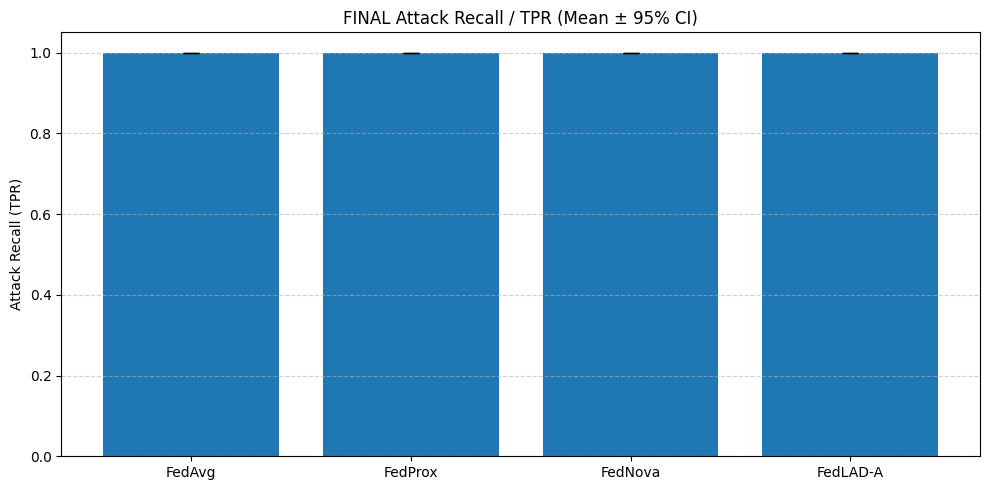

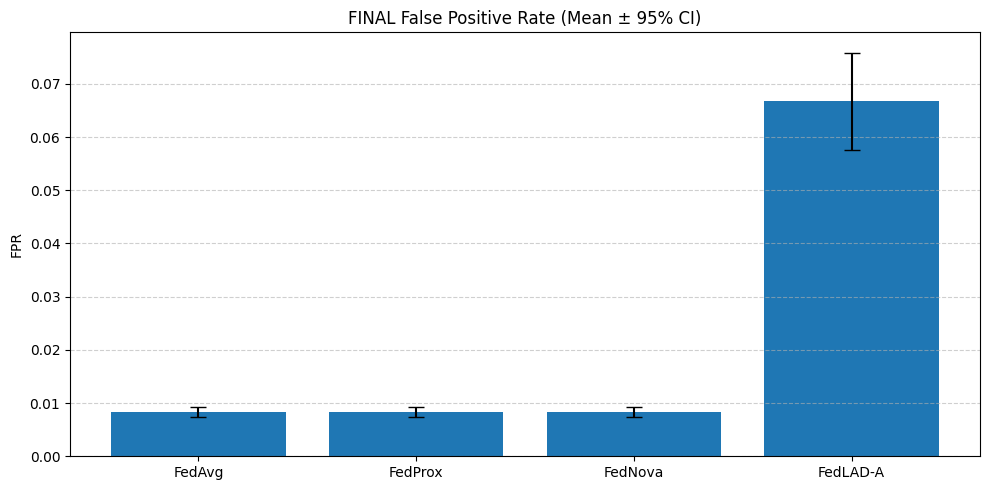

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from scipy.stats import t as student_t

# =========================
# SETTINGS (you can change)
# =========================
SEEDS = list(range(10))
ROUNDS = 10                 # use 15–20 for final paper
MODES = ["FedAvg", "FedProx", "FedNova", "FedLAD-A"]

SUBSAMPLE_FRAC = 0.8        # training variation per seed
N_ESTIMATORS = 30           # xgboost trees per round
PROX_MU = 0.01              # FedProx strength (your setting)
ENTROPY_W = 0.8             # FedLAD-A entropy weight (your setting)
MIX_FEDAVG = 0.2            # FedLAD-A safety mix (recommended)

# =========================
# SMALL METRIC HELPERS
# =========================
def metrics_from_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # Attack recall (TPR): how many attacks we catch
    attack_recall = tp / max(1e-12, (tp + fn))

    # False Positive Rate (FPR): benign wrongly flagged as attack
    fpr = fp / max(1e-12, (fp + tn))

    # False Negative Rate (FNR): attack missed (attack -> benign)
    fnr = fn / max(1e-12, (fn + tp))

    return {
        "acc": float(acc),
        "macro_f1": float(macro_f1),
        "attack_recall": float(attack_recall),
        "fpr": float(fpr),
        "fnr": float(fnr),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    }

def mean_std_ci(vals, tcrit):
    vals = np.array(vals, dtype=float)
    mean = float(vals.mean())
    std = float(vals.std(ddof=1)) if len(vals) > 1 else 0.0
    ci = float(tcrit * (std / np.sqrt(len(vals)))) if len(vals) > 1 else 0.0
    return mean, std, ci

# =========================
# 1) MAKE SURE YOU HAVE THE TRUE BALANCED TEST SET
# =========================
# This cell assumes you already created:
# X_test_final, y_test_final   (2000 benign + 2000 attack)
# If not, create it using your strict builder first.
assert "X_test_final" in globals() and "y_test_final" in globals(), \
    "❌ Please build X_test_final / y_test_final first (TRUE balanced 03-11)."

print("✅ Using TRUE balanced test set:", dict(pd.Series(y_test_final).value_counts()))

# =========================
# 2) ONE SEED RUNNER (TRAIN + EVAL EACH ROUND)
# =========================
def run_one_seed(mode, seed):
    # Build clients for this seed
    clients = []
    for cid in range(N_CLIENTS):
        if len(client_data_A[cid]) == 0:
            continue

        df_seed = client_data_A[cid].sample(
            frac=SUBSAMPLE_FRAC,
            random_state=seed * 1000 + cid
        ).reset_index(drop=True)

        clients.append(LocalClient_Advanced(client_id=cid, df_train=df_seed, seed=seed + cid))

    # Build server
    ent_w = ENTROPY_W if mode == "FedLAD-A" else 0.0
    mix = MIX_FEDAVG if mode == "FedLAD-A" else 0.0
    server = GlobalServer_Advanced(mode=mode, entropy_weight=ent_w, mix_with_fedavg=mix)

    global_ref_model = None

    # Track FINAL and PEAK (best round) metrics
    final_metrics = None
    best_macro_f1 = -1.0
    peak_metrics = None

    for r in range(ROUNDS):
        updates = []

        for c in clients:
            try:
                upd = c.train(
                    mode=mode,
                    global_model=global_ref_model,
                    prox_mu=PROX_MU,
                    n_estimators=N_ESTIMATORS
                )
                updates.append(upd)
            except:
                continue

        if not updates:
            # no updates -> skip
            continue

        alphas, summary = server.aggregate(updates)

        # warm-start next round using highest-alpha model
        best_idx = int(np.argmax(alphas))
        global_ref_model = updates[best_idx]["model"]

        # evaluate this round
        y_pred = server.predict(X_test_final)
        m = metrics_from_cm(y_test_final, y_pred)

        final_metrics = m  # last round keeps overwriting
        if m["macro_f1"] > best_macro_f1:
            best_macro_f1 = m["macro_f1"]
            peak_metrics = m

    # If something went wrong
    if final_metrics is None:
        final_metrics = {"acc":0,"macro_f1":0,"attack_recall":0,"fpr":0,"fnr":0,"tn":0,"fp":0,"fn":0,"tp":0}
    if peak_metrics is None:
        peak_metrics = final_metrics

    return final_metrics, peak_metrics

# =========================
# 3) RUN ALL MODES × 10 SEEDS
# =========================
print("\n🚀 Running 10-seed evaluation...")
raw = {mode: {"final": [], "peak": []} for mode in MODES}

for seed in SEEDS:
    print(f"\n🌱 Seed {seed}")
    for mode in MODES:
        fm, pm = run_one_seed(mode, seed)
        raw[mode]["final"].append(fm)
        raw[mode]["peak"].append(pm)
        print(f"  {mode:<8} | Final: Acc={fm['acc']:.4f} MacroF1={fm['macro_f1']:.4f} "
              f"TPR={fm['attack_recall']:.4f} FPR={fm['fpr']:.4f}")

# =========================
# 4) BUILD PAPER TABLE (Mean ± 95% CI)
# =========================
n = len(SEEDS)
dfree = n - 1
tcrit = float(student_t.ppf(0.975, dfree))  # 95% CI

rows = []
for mode in MODES:
    for which in ["final", "peak"]:
        vals_acc = [d["acc"] for d in raw[mode][which]]
        vals_f1  = [d["macro_f1"] for d in raw[mode][which]]
        vals_tpr = [d["attack_recall"] for d in raw[mode][which]]
        vals_fpr = [d["fpr"] for d in raw[mode][which]]

        m_acc, s_acc, ci_acc = mean_std_ci(vals_acc, tcrit)
        m_f1,  s_f1,  ci_f1  = mean_std_ci(vals_f1,  tcrit)
        m_tpr, s_tpr, ci_tpr = mean_std_ci(vals_tpr, tcrit)
        m_fpr, s_fpr, ci_fpr = mean_std_ci(vals_fpr, tcrit)

        rows.append({
            "Mode": mode,
            "Type": which.upper(),
            "Acc (mean±CI)":   f"{m_acc:.4f} ± {ci_acc:.4f}",
            "MacroF1 (mean±CI)": f"{m_f1:.4f} ± {ci_f1:.4f}",
            "AttackRecall/TPR (mean±CI)": f"{m_tpr:.4f} ± {ci_tpr:.4f}",
            "FPR (mean±CI)":   f"{m_fpr:.4f} ± {ci_fpr:.4f}",
            # keep numeric too (for plotting)
            "_acc_mean": m_acc, "_acc_ci": ci_acc,
            "_f1_mean": m_f1, "_f1_ci": ci_f1,
            "_tpr_mean": m_tpr, "_tpr_ci": ci_tpr,
            "_fpr_mean": m_fpr, "_fpr_ci": ci_fpr,
        })

report_df = pd.DataFrame(rows)
print("\n" + "="*110)
print("📊 PAPER TABLE (10 seeds, 95% CI using t-critical)")
print("="*110)
display_cols = ["Mode","Type","Acc (mean±CI)","MacroF1 (mean±CI)","AttackRecall/TPR (mean±CI)","FPR (mean±CI)"]
print(report_df[display_cols].to_string(index=False))
print("="*110)
print(f"Note: 95% CI uses t-critical (df={dfree}).\n")

# =========================
# 5) PLOTS (Mean ± 95% CI) — FINAL only
# =========================
final_only = report_df[report_df["Type"]=="FINAL"].copy()

def bar_ci(metric_mean_col, metric_ci_col, title, ylabel):
    x = np.arange(len(final_only))
    means = final_only[metric_mean_col].values
    cis   = final_only[metric_ci_col].values

    plt.figure(figsize=(10,5))
    plt.bar(x, means, yerr=cis, capsize=6)
    plt.xticks(x, final_only["Mode"].values)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

bar_ci("_acc_mean", "_acc_ci", "FINAL Accuracy (Mean ± 95% CI)", "Accuracy")
bar_ci("_f1_mean",  "_f1_ci",  "FINAL Macro-F1 (Mean ± 95% CI)", "Macro-F1")
bar_ci("_tpr_mean", "_tpr_ci", "FINAL Attack Recall / TPR (Mean ± 95% CI)", "Attack Recall (TPR)")
bar_ci("_fpr_mean", "_fpr_ci", "FINAL False Positive Rate (Mean ± 95% CI)", "FPR")


In [ ]:
from sklearn.metrics import f1_score
import numpy as np


class GlobalServerRobust_Advanced(GlobalServer_Advanced):
    """
    Enhanced server with Byzantine-robust defenses
    Compatible with: FedAvg, FedProx, FedNova, FedLAD-A
    """

    def __init__(self, mode="FedAvg", entropy_weight=0.0, mix_with_fedavg=0.2,
                 # DEFENSE 1: Server-side filtering
                 enable_filtering=False,
                 f1_threshold=0.70,
                 global_val_X=None,  # ← ADD THIS
                 global_val_y=None,  # ← ADD THIS
                 # DEFENSE 2: Weight capping
                 enable_capping=False,
                 max_weight=0.25,
                 # DEFENSE 3: Reputation
                 enable_reputation=False,
                 reputation_decay=0.9):
        """
        Byzantine defense parameters:

        DEFENSE 1: Server-Side Filtering
        - enable_filtering: Validate models on global clean data
        - global_val_X: Clean validation features (server-side)
        - global_val_y: Clean validation labels (server-side)
        - f1_threshold: Minimum F1 on GLOBAL validation (default 0.70)

        DEFENSE 2: Weight Capping
        - enable_capping: Limit maximum client influence
        - max_weight: Maximum alpha (default 0.25 = 25%)

        DEFENSE 3: Reputation System
        - enable_reputation: Track reliability over rounds
        - reputation_decay: Recovery speed (0.9 = slow)
        """
        super().__init__(mode, entropy_weight, mix_with_fedavg)

        # Defense 1: Filtering
        self.enable_filtering = enable_filtering
        self.f1_threshold = f1_threshold
        self.global_val_X = global_val_X  # ← ADD THIS
        self.global_val_y = global_val_y  # ← ADD THIS

        # Defense 2: Capping
        self.enable_capping = enable_capping
        self.max_weight = max_weight

        # Defense 3: Reputation
        self.enable_reputation = enable_reputation
        self.reputation_decay = reputation_decay
        self.client_reputation = {}


    def aggregate(self, client_updates):
        """
        Enhanced aggregation with Byzantine defenses
        """
        if len(client_updates) == 0:
            self.global_weights = []
            return [], {"note": "no client updates"}

        original_count = len(client_updates)

        # ========================================
        # DEFENSE 1: SERVER-SIDE FILTERING
        # ========================================
        if self.enable_filtering:
            filtered_updates = []
            filtered_ids = []

            # Use GLOBAL validation if available, else fall back to LOCAL
            use_global_val = (self.global_val_X is not None and
                             self.global_val_y is not None)

            if use_global_val:
                print(f"  🛡️ DEFENSE: Server-side validation (GLOBAL)")
            else:
                print(f"  🛡️ DEFENSE: Local F1 filtering (may not detect poisoning)")

            for u in client_updates:
                if use_global_val:
                    # SERVER-SIDE: Test model on clean global data
                    try:
                        preds = u["model"].predict(self.global_val_X)
                        global_f1 = f1_score(self.global_val_y, preds, zero_division=0)

                        poison_mark = "☠️" if u["client_id"] == 9 else ""

                        if global_f1 >= self.f1_threshold:
                            filtered_updates.append(u)
                            print(f"     Client {u['client_id']:2d}: Global F1={global_f1:.4f} ✅ PASS {poison_mark}")
                        else:
                            filtered_ids.append(u["client_id"])
                            print(f"     Client {u['client_id']:2d}: Global F1={global_f1:.4f} ❌ FILTERED {poison_mark}")
                    except Exception as e:
                        filtered_ids.append(u["client_id"])
                        print(f"     Client {u['client_id']:2d}: Evaluation failed ❌ FILTERED")
                else:
                    # LOCAL: Use client's reported F1 (WEAK for Byzantine)
                    if u["cur_f1"] >= self.f1_threshold:
                        filtered_updates.append(u)
                    else:
                        filtered_ids.append(u["client_id"])

            if len(filtered_ids) > 0:
                print(f"  🛡️ Filtered {len(filtered_ids)} client(s): {filtered_ids}")

            client_updates = filtered_updates

        # If all clients filtered out
        if len(client_updates) == 0:
            print(f"  ⚠️ WARNING: All {original_count} clients filtered!")
            self.global_weights = []
            return [], {"note": "all clients filtered"}


        # ========================================
        # STANDARD AGGREGATION (from parent)
        # ========================================
        alphas, summary = super().aggregate(client_updates)


        # ========================================
        # DEFENSE 2: WEIGHT CAPPING
        # ========================================
        if self.enable_capping and len(alphas) > 0:
            original_alphas = alphas.copy()
            alphas = np.clip(alphas, 0, self.max_weight)

            alpha_sum = alphas.sum()
            if alpha_sum > 1e-12:
                alphas = alphas / alpha_sum

            max_idx = np.argmax(original_alphas)
            if original_alphas[max_idx] > self.max_weight:
                capped_client_id = client_updates[max_idx]["client_id"]
                print(f"  🛡️ DEFENSE [Capping]: Client {capped_client_id} weight "
                      f"{original_alphas[max_idx]:.3f} → {alphas[max_idx]:.3f}")


        # ========================================
        # DEFENSE 3: REPUTATION SYSTEM
        # ========================================
        if self.enable_reputation and len(alphas) > 0:
            for u in client_updates:
                cid = u["client_id"]
                if cid not in self.client_reputation:
                    self.client_reputation[cid] = 1.0

            for u in client_updates:
                cid = u["client_id"]
                if u["drift"] < -0.15 or u["cur_f1"] < 0.60:
                    self.client_reputation[cid] *= 0.7
                elif u["drift"] > 0.05 and u["cur_f1"] > 0.80:
                    self.client_reputation[cid] = min(1.0, self.client_reputation[cid] * 1.1)
                else:
                    gap = 1.0 - self.client_reputation[cid]
                    self.client_reputation[cid] += gap * (1 - self.reputation_decay)

            original_alphas = alphas.copy()
            for i, u in enumerate(client_updates):
                cid = u["client_id"]
                alphas[i] *= self.client_reputation[cid]

            alpha_sum = alphas.sum()
            if alpha_sum > 1e-12:
                alphas = alphas / alpha_sum


        # ========================================
        # UPDATE GLOBAL WEIGHTS & SUMMARY
        # ========================================
        self.global_weights = [(u["model"], float(a)) for u, a in zip(client_updates, alphas)]

        for i, u in enumerate(client_updates):
            for c in summary["clients"]:
                if c["client_id"] == u["client_id"]:
                    c["alpha"] = float(alphas[i])
                    if self.enable_reputation:
                        c["reputation"] = float(self.client_reputation.get(u["client_id"], 1.0))

        summary["defenses_active"] = {
            "filtering": self.enable_filtering,
            "capping": self.enable_capping,
            "reputation": self.enable_reputation,
            "clients_filtered": original_count - len(client_updates),
        }

        self.round_history.append(summary)
        return list(alphas), summary


print("✅ GlobalServerRobust_Advanced UPDATED with server-side validation!")


✅ GlobalServerRobust_Advanced UPDATED with server-side validation!


✅ Using TRUE balanced test set: {0: np.int64(2000), 1: np.int64(2000)}
☠️ Poisoning Whale Client: 9 (Label Flip 0↔1)

🚀 Running 10-seed Whale Poisoning WITH DEFENSES...

🌱 Seed 0
  FedAvg   | Final Acc=0.0047 FNR=1.0000
  FedNova  | Final Acc=0.0047 FNR=1.0000
  FedLAD-A | Final Acc=0.5360 FNR=0.6840

🌱 Seed 1
  FedAvg   | Final Acc=0.3670 FNR=1.0000
  FedNova  | Final Acc=0.3670 FNR=1.0000
  FedLAD-A | Final Acc=0.4308 FNR=0.8690

🌱 Seed 2
  FedAvg   | Final Acc=0.0123 FNR=0.9850
  FedNova  | Final Acc=0.0123 FNR=0.9850
  FedLAD-A | Final Acc=0.4373 FNR=0.8960

🌱 Seed 3
  FedAvg   | Final Acc=0.3130 FNR=1.0000
  FedNova  | Final Acc=0.3130 FNR=1.0000
  FedLAD-A | Final Acc=0.4980 FNR=0.7570

🌱 Seed 4
  FedAvg   | Final Acc=0.2945 FNR=1.0000
  FedNova  | Final Acc=0.2945 FNR=1.0000
  FedLAD-A | Final Acc=0.4985 FNR=0.7580

🌱 Seed 5
  FedAvg   | Final Acc=0.4017 FNR=1.0000
  FedNova  | Final Acc=0.4017 FNR=1.0000
  FedLAD-A | Final Acc=0.4645 FNR=0.8265

🌱 Seed 6
  FedAvg   | Final Acc=

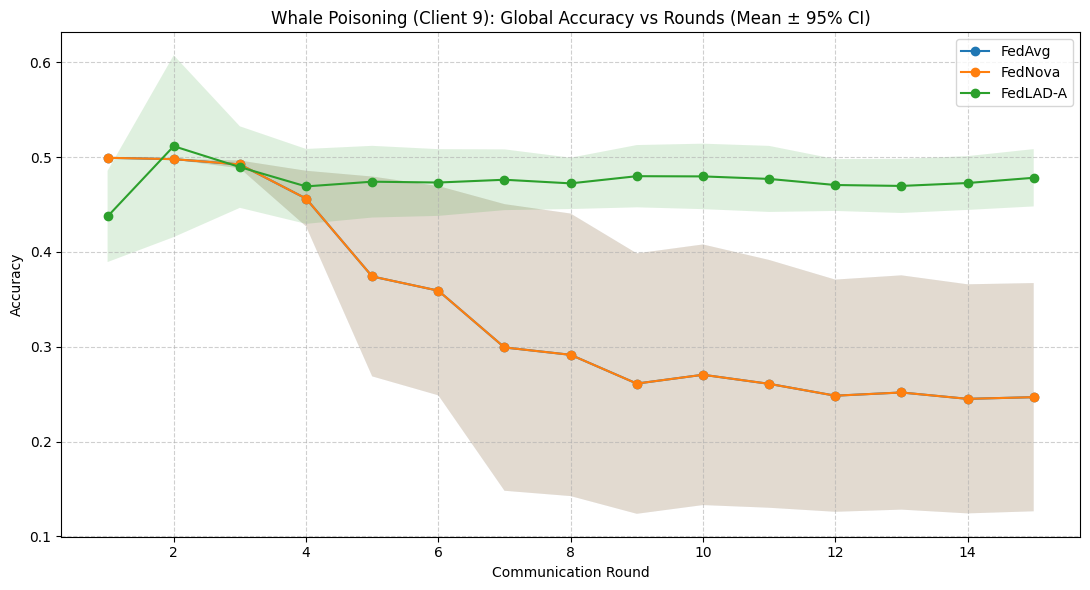

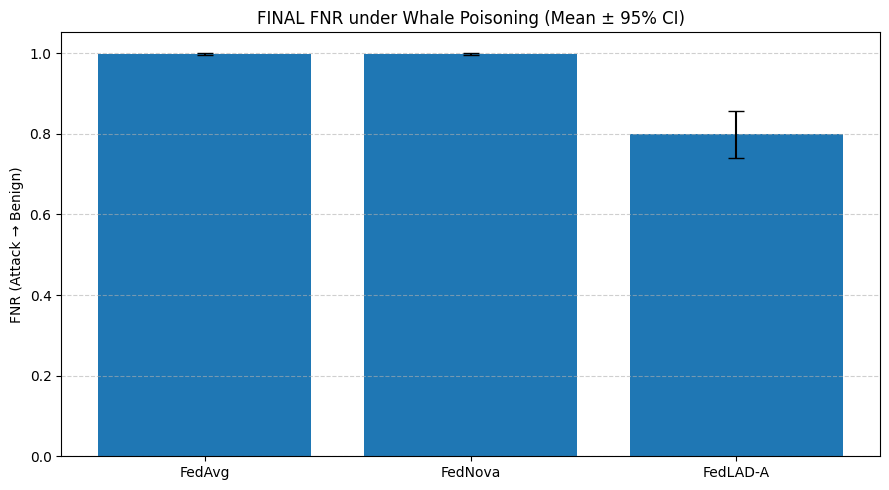

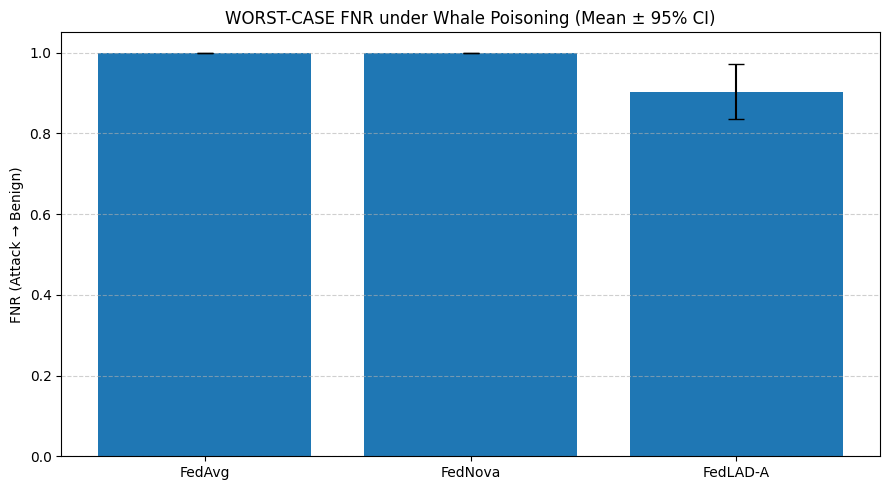

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from scipy.stats import t as student_t

# =========================
# SECURITY TEST SETTINGS
# =========================
SEEDS = list(range(10))
ROUNDS_SEC = 15

# Compare these (you can add FedProx too if you want)
MODES_SEC = ["FedAvg", "FedNova", "FedLAD-A"]

WHALE_ID = 9                 # poisoned client
SUBSAMPLE_FRAC = 0.8         # per-seed training variation
N_ESTIMATORS = 30
PROX_MU = 0.01
ENTROPY_W = 0.8              # FedLAD-A only
MIX_FEDAVG = 0.2             # FedLAD-A only (safety mix)
SEED_BASE = 42

assert "X_test_final" in globals() and "y_test_final" in globals(), \
    "❌ Please build the TRUE balanced test set first: X_test_final, y_test_final"

print("✅ Using TRUE balanced test set:", dict(pd.Series(y_test_final).value_counts()))
print(f"☠️ Poisoning Whale Client: {WHALE_ID} (Label Flip 0↔1)\n")

# =========================
# METRICS FROM CONFUSION MATRIX
# =========================
def metrics_from_preds(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    tpr = tp / max(1e-12, (tp + fn))        # Attack recall
    fpr = fp / max(1e-12, (fp + tn))        # Benign -> Attack
    fnr = fn / max(1e-12, (fn + tp))        # Attack -> Benign (MOST IMPORTANT)

    return {
        "acc": float(acc),
        "macro_f1": float(macro_f1),
        "tpr": float(tpr),
        "fpr": float(fpr),
        "fnr": float(fnr),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)
    }

def mean_ci(vals, tcrit):
    vals = np.array(vals, dtype=float)
    mean = float(vals.mean())
    std = float(vals.std(ddof=1)) if len(vals) > 1 else 0.0
    ci = float(tcrit * (std / np.sqrt(len(vals)))) if len(vals) > 1 else 0.0
    return mean, ci

# =========================
# BUILD POISONED CLIENTS (per seed)
# =========================
def build_clients_poisoned(seed, whale_id=9):
    clients = []
    for cid in range(N_CLIENTS):
        if len(client_data_A[cid]) == 0:
            continue

        df_seed = client_data_A[cid].sample(
            frac=SUBSAMPLE_FRAC,
            random_state=seed * 1000 + cid
        ).reset_index(drop=True)

        # Poison whale node: flip labels
        if cid == whale_id:
            df_seed = df_seed.copy()
            df_seed["Label"] = (1 - df_seed["Label"].astype(int)).astype(int)

        clients.append(LocalClient_Advanced(client_id=cid, df_train=df_seed, seed=seed + cid))
    return clients

# =========================
# RUN ONE SEED (poisoned)
# =========================
def run_one_seed_poison(mode, seed):
    clients = build_clients_poisoned(seed, whale_id=WHALE_ID)

    ent_w = ENTROPY_W if mode == "FedLAD-A" else 0.0
    mix = MIX_FEDAVG if mode == "FedLAD-A" else 0.0

    # ✅ USE ROBUST SERVER WITH GLOBAL VALIDATION
    server = GlobalServer_Advanced(
    mode=mode,
    entropy_weight=ent_w,
    mix_with_fedavg=mix,
    use_val_trust=(mode == "FedLAD-A"),
    val_data=(X_val_server, y_val_server) if mode == "FedLAD-A" else None,
    )


    global_ref_model = None

    acc_curve, fnr_curve = [], []
    final_metrics = None

    for r in range(ROUNDS_SEC):
        updates = []
        for c in clients:
            try:
                upd = c.train(
                    mode=mode,
                    global_model=global_ref_model,
                    prox_mu=PROX_MU,
                    n_estimators=N_ESTIMATORS
                )
                updates.append(upd)
            except:
                continue

        if not updates:
            acc_curve.append(0.0)
            fnr_curve.append(1.0)
            continue

        alphas, summary = server.aggregate(updates)

        if len(alphas) == 0:  # All filtered
            acc_curve.append(0.0)
            fnr_curve.append(1.0)
            continue

        # warm-start next round with highest-alpha model
        best_idx = int(np.argmax(alphas))
        global_ref_model = updates[best_idx]["model"]

        y_pred = server.predict(X_test_final)
        m = metrics_from_preds(y_test_final, y_pred)

        final_metrics = m
        acc_curve.append(m["acc"])
        fnr_curve.append(m["fnr"])

    # WORST = minimum accuracy, maximum FNR
    worst_acc = float(np.min(acc_curve)) if len(acc_curve) > 0 else 0.0
    worst_fnr = float(np.max(fnr_curve)) if len(fnr_curve) > 0 else 1.0

    if final_metrics is None:
        final_metrics = {"acc":0,"macro_f1":0,"tpr":0,"fpr":0,"fnr":1,"tn":0,"fp":0,"fn":2000,"tp":0}

    return final_metrics, worst_acc, worst_fnr, acc_curve, fnr_curve


# =========================
# MAIN: 10-SEED RUN
# =========================
n = len(SEEDS)
tcrit = float(student_t.ppf(0.975, n-1))

store = {m: {"final": [], "worst_acc": [], "worst_fnr": [], "acc_curves": [], "fnr_curves": []}
         for m in MODES_SEC}

print("🚀 Running 10-seed Whale Poisoning WITH DEFENSES...")
for seed in SEEDS:
    print(f"\n🌱 Seed {seed}")
    for mode in MODES_SEC:
        fm, wacc, wfnr, acc_curve, fnr_curve = run_one_seed_poison(mode, seed)
        store[mode]["final"].append(fm)
        store[mode]["worst_acc"].append(wacc)
        store[mode]["worst_fnr"].append(wfnr)
        store[mode]["acc_curves"].append(acc_curve)
        store[mode]["fnr_curves"].append(fnr_curve)

        print(f"  {mode:<8} | Final Acc={fm['acc']:.4f} FNR={fm['fnr']:.4f}")

# =========================
# PAPER TABLE (Mean ± 95% CI)
# =========================
rows = []
for mode in MODES_SEC:
    finals = store[mode]["final"]

    # final metrics lists
    accs = [d["acc"] for d in finals]
    f1s  = [d["macro_f1"] for d in finals]
    tprs = [d["tpr"] for d in finals]
    fprs = [d["fpr"] for d in finals]
    fnrs = [d["fnr"] for d in finals]

    # worst metrics lists
    waccs = store[mode]["worst_acc"]
    wfnrs = store[mode]["worst_fnr"]

    m_acc, ci_acc = mean_ci(accs, tcrit)
    m_f1,  ci_f1  = mean_ci(f1s,  tcrit)
    m_tpr, ci_tpr = mean_ci(tprs, tcrit)
    m_fpr, ci_fpr = mean_ci(fprs, tcrit)
    m_fnr, ci_fnr = mean_ci(fnrs, tcrit)

    m_wacc, ci_wacc = mean_ci(waccs, tcrit)
    m_wfnr, ci_wfnr = mean_ci(wfnrs, tcrit)

    rows.append({
        "Mode": mode,
        "FINAL Acc (mean±CI)":   f"{m_acc:.4f} ± {ci_acc:.4f}",
        "FINAL MacroF1 (mean±CI)": f"{m_f1:.4f} ± {ci_f1:.4f}",
        "FINAL TPR (mean±CI)":   f"{m_tpr:.4f} ± {ci_tpr:.4f}",
        "FINAL FPR (mean±CI)":   f"{m_fpr:.4f} ± {ci_fpr:.4f}",
        "FINAL FNR (mean±CI)":   f"{m_fnr:.4f} ± {ci_fnr:.4f}",
        "WORST Acc (mean±CI)":   f"{m_wacc:.4f} ± {ci_wacc:.4f}",
        "WORST FNR (mean±CI)":   f"{m_wfnr:.4f} ± {ci_wfnr:.4f}",

        # numeric for plots
        "_final_fnr_mean": m_fnr, "_final_fnr_ci": ci_fnr,
        "_worst_fnr_mean": m_wfnr, "_worst_fnr_ci": ci_wfnr,
    })

sec_df = pd.DataFrame(rows)

print("\n" + "="*130)
print("📊 SECURITY TABLE — Whale Poisoning (Client 9 label flip), 10 seeds, Mean ± 95% CI")
print("="*130)
print(sec_df[[
    "Mode",
    "FINAL Acc (mean±CI)", "FINAL MacroF1 (mean±CI)",
    "FINAL TPR (mean±CI)", "FINAL FPR (mean±CI)", "FINAL FNR (mean±CI)",
    "WORST Acc (mean±CI)", "WORST FNR (mean±CI)"
]].to_string(index=False))
print("="*130)
print(f"Note: 95% CI uses t-critical (df={n-1}).\n")

# =========================
# PLOT 1: ACCURACY CURVES (Mean ± 95% CI band)
# =========================
plt.figure(figsize=(11,6))
x = np.arange(1, ROUNDS_SEC+1)

for mode in MODES_SEC:
    curves = np.array(store[mode]["acc_curves"], dtype=float)  # (seeds, rounds)
    mean_curve = curves.mean(axis=0)
    std_curve = curves.std(axis=0, ddof=1)
    ci_curve = tcrit * (std_curve / np.sqrt(n))

    plt.plot(x, mean_curve, marker="o", label=mode)
    plt.fill_between(x, mean_curve-ci_curve, mean_curve+ci_curve, alpha=0.15)

plt.title("Whale Poisoning (Client 9): Global Accuracy vs Rounds (Mean ± 95% CI)")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# PLOT 2: FNR BAR PLOT (Final + Worst)
# =========================
def bar_plot_fnr(col_mean, col_ci, title):
    plt.figure(figsize=(9,5))
    modes = sec_df["Mode"].values
    means = sec_df[col_mean].values
    cis   = sec_df[col_ci].values

    xi = np.arange(len(modes))
    plt.bar(xi, means, yerr=cis, capsize=6)
    plt.xticks(xi, modes)
    plt.ylabel("FNR (Attack → Benign)")
    plt.title(title)
    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

bar_plot_fnr("_final_fnr_mean", "_final_fnr_ci", "FINAL FNR under Whale Poisoning (Mean ± 95% CI)")
bar_plot_fnr("_worst_fnr_mean", "_worst_fnr_ci", "WORST-CASE FNR under Whale Poisoning (Mean ± 95% CI)")


✅ Server validation set (clean, for weighting only): {1: 300, 0: 300}
✅ Holdout test set (clean, for reporting only):      {1: 1700, 0: 1700}

☠️ Whale Poisoning Test (Client 9 label flip) with SERVER-VALIDATION DEFENSE

🚀 Running 10 seeds...

🌱 Seed 0
  FedAvg     | Final Acc=0.5000 MacroF1=0.3333 TPR=0.0000 FPR=0.0000 FNR=1.0000 | WorstAcc=0.5000 WorstFNR=1.0000
  FedNova    | Final Acc=0.5000 MacroF1=0.3333 TPR=0.0000 FPR=0.0000 FNR=1.0000 | WorstAcc=0.5000 WorstFNR=1.0000
  FedLAD-A-DEF | Final Acc=0.9103 MacroF1=0.9102 TPR=0.9459 FPR=0.1253 FNR=0.0541 | WorstAcc=0.6388 WorstFNR=0.5771

🌱 Seed 1
  FedAvg     | Final Acc=0.4985 MacroF1=0.3327 TPR=0.0000 FPR=0.0029 FNR=1.0000 | WorstAcc=0.4985 WorstFNR=1.0000
  FedNova    | Final Acc=0.4985 MacroF1=0.3327 TPR=0.0000 FPR=0.0029 FNR=1.0000 | WorstAcc=0.4985 WorstFNR=1.0000
  FedLAD-A-DEF | Final Acc=0.7953 MacroF1=0.7953 TPR=0.8029 FPR=0.2124 FNR=0.1971 | WorstAcc=0.4624 WorstFNR=0.8488

🌱 Seed 2
  FedAvg     | Final Acc=0.5000 MacroF1

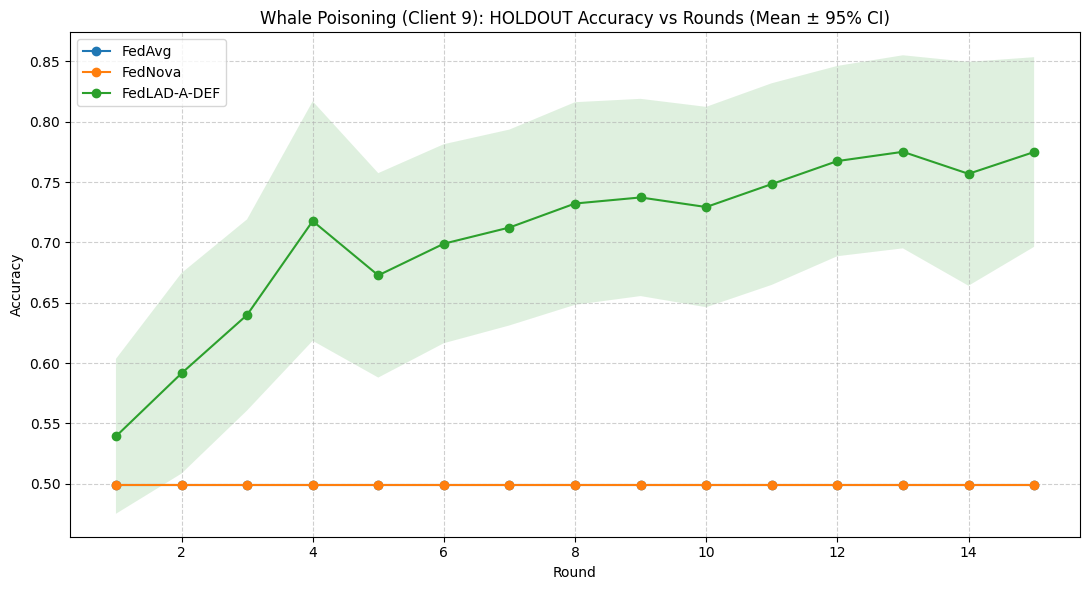

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from scipy.stats import t as student_t

# =========================================================
# 0) Split your TRUE balanced test into:
#    - server_val (used ONLY for weighting clients)
#    - server_test (used ONLY for reporting results)
# =========================================================
def split_server_val_test(X, y, n_val_per_class=300, seed=42):
    rng = np.random.RandomState(seed)

    y = pd.Series(y).astype(int)
    idx0 = y[y == 0].index.values
    idx1 = y[y == 1].index.values

    rng.shuffle(idx0)
    rng.shuffle(idx1)

    val0 = idx0[:n_val_per_class]
    val1 = idx1[:n_val_per_class]
    val_idx = np.concatenate([val0, val1])

    test0 = idx0[n_val_per_class:]
    test1 = idx1[n_val_per_class:]
    test_idx = np.concatenate([test0, test1])

    # shuffle indices
    rng.shuffle(val_idx)
    rng.shuffle(test_idx)

    X_val = X.loc[val_idx].reset_index(drop=True)
    y_val = y.loc[val_idx].reset_index(drop=True)

    X_test = X.loc[test_idx].reset_index(drop=True)
    y_test = y.loc[test_idx].reset_index(drop=True)

    return X_val, y_val, X_test, y_test

# Make sure balanced test exists
assert "X_test_final" in globals() and "y_test_final" in globals(), \
    "❌ Build TRUE balanced test first: X_test_final, y_test_final"

X_sv, y_sv, X_hold, y_hold = split_server_val_test(X_test_final, y_test_final, n_val_per_class=300, seed=42)

print("✅ Server validation set (clean, for weighting only):", y_sv.value_counts().to_dict())
print("✅ Holdout test set (clean, for reporting only):     ", y_hold.value_counts().to_dict())


# =========================================================
# 1) Metric helper
# =========================================================
def metrics_from_preds(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    tpr = tp / max(1e-12, (tp + fn))   # Attack recall
    fpr = fp / max(1e-12, (fp + tn))   # Benign -> Attack
    fnr = fn / max(1e-12, (fn + tp))   # Attack -> Benign (most important)

    return {"acc": float(acc), "macro_f1": float(macro_f1), "tpr": float(tpr), "fpr": float(fpr), "fnr": float(fnr)}


def mean_ci(vals, tcrit):
    vals = np.array(vals, dtype=float)
    mean = float(vals.mean())
    std = float(vals.std(ddof=1)) if len(vals) > 1 else 0.0
    ci = float(tcrit * (std / np.sqrt(len(vals)))) if len(vals) > 1 else 0.0
    return mean, ci


# =========================================================
# 2) NEW: Defended server (server-side validation scoring)
# =========================================================
class GlobalServer_Defended:
    """
    FedLAD-A-DEFENDED:
    - Scores each client model using SERVER validation (clean set): macro-F1
    - Drops bottom fraction of clients each round (optional)
    - Then normalizes remaining weights
    """
    def __init__(self, X_server_val, y_server_val, drop_frac=0.2, min_keep=3, eps=1e-6):
        self.X_sv = X_server_val
        self.y_sv = pd.Series(y_server_val).astype(int)
        self.drop_frac = drop_frac
        self.min_keep = min_keep
        self.eps = eps
        self.global_weights = []  # list of (model, alpha)

    def _server_score(self, model):
        # score on CLEAN server validation
        pred = model.predict(self.X_sv)
        return f1_score(self.y_sv, pred, average="macro", zero_division=0)

    def aggregate(self, updates):
        """
        updates can be:
        - tuple: (model, n, drift, ent)  OR
        - dict : {"model":..., "n":..., ...}
        """
        # unpack
        models = []
        ns = []
        for u in updates:
            if isinstance(u, dict):
                models.append(u["model"])
                ns.append(int(u.get("n", 1)))
            else:
                models.append(u[0])
                ns.append(int(u[1]))

        # 1) compute server scores
        scores = np.array([self._server_score(m) for m in models], dtype=float)

        # 2) drop the worst clients (by score)
        K = len(models)
        k_drop = int(np.floor(self.drop_frac * K))
        k_drop = min(k_drop, max(0, K - self.min_keep))

        order = np.argsort(scores)  # low -> high
        drop_idx = set(order[:k_drop].tolist())
        keep_mask = np.array([i not in drop_idx for i in range(K)], dtype=bool)

        # 3) weights only from kept clients
        kept_scores = np.where(keep_mask, np.maximum(scores, self.eps), 0.0)

        total = kept_scores.sum()
        if total <= self.eps:
            # fallback: uniform among kept
            kept_ids = np.where(keep_mask)[0]
            alphas = np.zeros(K, dtype=float)
            if len(kept_ids) > 0:
                alphas[kept_ids] = 1.0 / len(kept_ids)
        else:
            alphas = kept_scores / total

        # store (only kept models)
        self.global_weights = [(models[i], float(alphas[i])) for i in range(K) if keep_mask[i]]

        summary = {
            "scores": scores,
            "dropped": sorted(list(drop_idx)),
            "kept": sorted(list(np.where(keep_mask)[0])),
            "alpha_sum": float(alphas.sum())
        }
        return alphas, summary

    def predict(self, X):
        # soft voting
        final_probs = np.zeros((len(X), 2))
        for model, alpha in self.global_weights:
            final_probs += alpha * model.predict_proba(X)
        return np.argmax(final_probs, axis=1)


# =========================================================
# 3) Whale poisoning 10-seed evaluation (FedAvg/FedNova vs Defended FedLAD-A)
# =========================================================
SEEDS = list(range(10))
ROUNDS_SEC = 15
MODES_SEC = ["FedAvg", "FedNova", "FedLAD-A-DEF"]  # DEF = defended
WHALE_ID = 9

SUBSAMPLE_FRAC = 0.8
N_ESTIMATORS = 30
PROX_MU = 0.01

print("\n☠️ Whale Poisoning Test (Client 9 label flip) with SERVER-VALIDATION DEFENSE\n")

def build_clients_poisoned(seed, whale_id=9):
    clients = []
    for cid in range(N_CLIENTS):
        if len(client_data_A[cid]) == 0:
            continue

        df_seed = client_data_A[cid].sample(
            frac=SUBSAMPLE_FRAC,
            random_state=seed * 1000 + cid
        ).reset_index(drop=True)

        # poison whale: flip labels
        if cid == whale_id:
            df_seed = df_seed.copy()
            df_seed["Label"] = (1 - df_seed["Label"].astype(int)).astype(int)

        # LocalClient_Advanced must exist in your notebook
        clients.append(LocalClient_Advanced(client_id=cid, df_train=df_seed, seed=seed + cid))
    return clients


def run_one_seed_poison(mode, seed):
    clients = build_clients_poisoned(seed, whale_id=WHALE_ID)

    # choose server
    if mode == "FedLAD-A-DEF":
        server = GlobalServer_Defended(X_server_val=X_sv, y_server_val=y_sv, drop_frac=0.2, min_keep=3)
    else:
        # your existing baseline server
        server = GlobalServer_Advanced(mode=mode.replace("-DEF",""), entropy_weight=0.0, mix_with_fedavg=0.0)

    global_ref_model = None
    acc_curve = []
    fnr_curve = []
    final_m = None

    for r in range(ROUNDS_SEC):
        updates = []
        for c in clients:
            try:
                upd = c.train(
                    mode=("FedAvg" if mode == "FedLAD-A-DEF" else mode),  # client training normal
                    global_model=global_ref_model,
                    prox_mu=PROX_MU,
                    n_estimators=N_ESTIMATORS
                )
                updates.append(upd)
            except:
                continue

        if not updates:
            acc_curve.append(0.0)
            fnr_curve.append(1.0)
            continue

        alphas, summary = server.aggregate(updates)

        # warm-start next round (pick top alpha model)
        # (works for both server types)
        if isinstance(alphas, np.ndarray) and len(alphas) == len(updates):
            best_idx = int(np.argmax(alphas))
            # unpack model
            if isinstance(updates[best_idx], dict):
                global_ref_model = updates[best_idx]["model"]
            else:
                global_ref_model = updates[best_idx][0]

        # evaluate on HOLDOUT (not the server-val)
        y_pred = server.predict(X_hold)
        m = metrics_from_preds(y_hold, y_pred)
        final_m = m
        acc_curve.append(m["acc"])
        fnr_curve.append(m["fnr"])

    worst_acc = float(np.min(acc_curve))
    worst_fnr = float(np.max(fnr_curve))
    return final_m, worst_acc, worst_fnr, acc_curve, fnr_curve


# Run all seeds
n = len(SEEDS)
tcrit = float(student_t.ppf(0.975, n-1))

store = {m: {"final": [], "worst_acc": [], "worst_fnr": [], "acc_curves": []} for m in MODES_SEC}

print("🚀 Running 10 seeds...\n")
for seed in SEEDS:
    print(f"🌱 Seed {seed}")
    for mode in MODES_SEC:
        fm, wacc, wfnr, acc_curve, fnr_curve = run_one_seed_poison(mode, seed)
        store[mode]["final"].append(fm)
        store[mode]["worst_acc"].append(wacc)
        store[mode]["worst_fnr"].append(wfnr)
        store[mode]["acc_curves"].append(acc_curve)

        print(f"  {mode:<10} | Final Acc={fm['acc']:.4f} MacroF1={fm['macro_f1']:.4f} "
              f"TPR={fm['tpr']:.4f} FPR={fm['fpr']:.4f} FNR={fm['fnr']:.4f} | WorstAcc={wacc:.4f} WorstFNR={wfnr:.4f}")
    print()

# Build security table
rows = []
for mode in MODES_SEC:
    finals = store[mode]["final"]

    accs = [d["acc"] for d in finals]
    f1s  = [d["macro_f1"] for d in finals]
    tprs = [d["tpr"] for d in finals]
    fprs = [d["fpr"] for d in finals]
    fnrs = [d["fnr"] for d in finals]

    waccs = store[mode]["worst_acc"]
    wfnrs = store[mode]["worst_fnr"]

    m_acc, ci_acc = mean_ci(accs, tcrit)
    m_f1,  ci_f1  = mean_ci(f1s,  tcrit)
    m_tpr, ci_tpr = mean_ci(tprs, tcrit)
    m_fpr, ci_fpr = mean_ci(fprs, tcrit)
    m_fnr, ci_fnr = mean_ci(fnrs, tcrit)

    m_wacc, ci_wacc = mean_ci(waccs, tcrit)
    m_wfnr, ci_wfnr = mean_ci(wfnrs, tcrit)

    rows.append({
        "Mode": mode,
        "FINAL Acc (mean±CI)": f"{m_acc:.4f} ± {ci_acc:.4f}",
        "FINAL MacroF1 (mean±CI)": f"{m_f1:.4f} ± {ci_f1:.4f}",
        "FINAL TPR (mean±CI)": f"{m_tpr:.4f} ± {ci_tpr:.4f}",
        "FINAL FPR (mean±CI)": f"{m_fpr:.4f} ± {ci_fpr:.4f}",
        "FINAL FNR (mean±CI)": f"{m_fnr:.4f} ± {ci_fnr:.4f}",
        "WORST Acc (mean±CI)": f"{m_wacc:.4f} ± {ci_wacc:.4f}",
        "WORST FNR (mean±CI)": f"{m_wfnr:.4f} ± {ci_wfnr:.4f}",
    })

sec_df = pd.DataFrame(rows)

print("\n" + "="*130)
print("📊 SECURITY TABLE — Whale Poisoning (Client 9 label flip), HOLDOUT results, Mean ± 95% CI")
print("="*130)
print(sec_df.to_string(index=False))
print("="*130)
print(f"Note: 95% CI uses t-critical (df={n-1}).\n")

# Plot mean accuracy curve (optional)
plt.figure(figsize=(11,6))
x = np.arange(1, ROUNDS_SEC+1)
for mode in MODES_SEC:
    curves = np.array(store[mode]["acc_curves"], dtype=float)
    mean_curve = curves.mean(axis=0)
    std_curve = curves.std(axis=0, ddof=1)
    ci_curve = tcrit * (std_curve / np.sqrt(n))

    plt.plot(x, mean_curve, marker="o", label=mode)
    plt.fill_between(x, mean_curve-ci_curve, mean_curve+ci_curve, alpha=0.15)

plt.title("Whale Poisoning (Client 9): HOLDOUT Accuracy vs Rounds (Mean ± 95% CI)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix
from scipy.stats import t as student_t

# =========================================
# 1) Split TRUE balanced test into:
#    - server_val (for weighting + threshold tuning)
#    - holdout (for reporting only)
# =========================================
def split_server_val_test(X, y, n_val_per_class=500, seed=42):
    rng = np.random.RandomState(seed)
    y = pd.Series(y).astype(int)

    idx0 = y[y == 0].index.values
    idx1 = y[y == 1].index.values
    rng.shuffle(idx0); rng.shuffle(idx1)

    val0 = idx0[:n_val_per_class]
    val1 = idx1[:n_val_per_class]
    val_idx = np.concatenate([val0, val1])
    rng.shuffle(val_idx)

    test0 = idx0[n_val_per_class:]
    test1 = idx1[n_val_per_class:]
    test_idx = np.concatenate([test0, test1])
    rng.shuffle(test_idx)

    X_val = X.loc[val_idx].reset_index(drop=True)
    y_val = y.loc[val_idx].reset_index(drop=True)

    X_test = X.loc[test_idx].reset_index(drop=True)
    y_test = y.loc[test_idx].reset_index(drop=True)

    return X_val, y_val, X_test, y_test


# =========================================
# 2) Ensemble probabilities (shared)
# =========================================
def ensemble_proba(global_weights, X):
    probs = np.zeros((len(X), 2))
    for model, alpha in global_weights:
        probs += alpha * model.predict_proba(X)
    return probs

def predict_from_proba(probs, thr=0.5):
    return (probs[:, 1] >= thr).astype(int)

def metrics_from_preds(y_true, y_pred):
    y_true = pd.Series(y_true).astype(int).values
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    tpr = tp / max(1e-12, (tp + fn))   # Attack recall
    fpr = fp / max(1e-12, (fp + tn))   # Benign -> Attack
    fnr = fn / max(1e-12, (fn + tp))   # Attack -> Benign

    return {"acc": float(acc), "macro_f1": float(macro_f1), "tpr": float(tpr), "fpr": float(fpr), "fnr": float(fnr)}


# =========================================
# 3) NEW: Choose threshold using server_val
#    Goal: minimize FNR (missed attacks),
#    but keep FPR not crazy (cap)
# =========================================
def pick_threshold_on_server_val(global_weights, X_sv, y_sv, fpr_cap=0.25):
    probs = ensemble_proba(global_weights, X_sv)
    y_sv = pd.Series(y_sv).astype(int).values

    best_thr = 0.5
    best_score = -1e9

    # Try many thresholds
    for thr in np.linspace(0.1, 0.9, 17):
        y_pred = predict_from_proba(probs, thr=thr)
        m = metrics_from_preds(y_sv, y_pred)

        # Hard rule: keep false alarms under control
        if m["fpr"] > fpr_cap:
            continue

        # Score: prioritize catching attacks (low FNR), then macro_f1
        # You can change weights here if you want
        score = (1.0 - m["fnr"]) * 2.0 + m["macro_f1"] * 1.0

        if score > best_score:
            best_score = score
            best_thr = thr

    return float(best_thr)


# =========================================
# 4) Defended server with stronger filtering
#    - score_mode: "macro_f1" or "attack_f1"
#    - drop_frac: drop worst clients each round
# =========================================
class GlobalServer_Defended_Tuned:
    def __init__(self, X_sv, y_sv, drop_frac=0.35, min_keep=4, score_mode="macro_f1", eps=1e-6):
        self.X_sv = X_sv
        self.y_sv = pd.Series(y_sv).astype(int)
        self.drop_frac = drop_frac
        self.min_keep = min_keep
        self.score_mode = score_mode
        self.eps = eps
        self.global_weights = []

    def _server_score(self, model):
        pred = model.predict(self.X_sv)
        if self.score_mode == "attack_f1":
            return f1_score(self.y_sv, pred, pos_label=1, zero_division=0)
        else:
            return f1_score(self.y_sv, pred, average="macro", zero_division=0)

    def aggregate(self, updates):
        # unpack models
        models = []
        for u in updates:
            if isinstance(u, dict):
                models.append(u["model"])
            else:
                models.append(u[0])

        scores = np.array([self._server_score(m) for m in models], dtype=float)

        K = len(models)
        k_drop = int(np.floor(self.drop_frac * K))
        k_drop = min(k_drop, max(0, K - self.min_keep))

        order = np.argsort(scores)  # low -> high
        drop_idx = set(order[:k_drop].tolist())
        keep_mask = np.array([i not in drop_idx for i in range(K)], dtype=bool)

        kept_scores = np.where(keep_mask, np.maximum(scores, self.eps), 0.0)
        total = kept_scores.sum()

        if total <= self.eps:
            kept_ids = np.where(keep_mask)[0]
            alphas = np.zeros(K, dtype=float)
            if len(kept_ids) > 0:
                alphas[kept_ids] = 1.0 / len(kept_ids)
        else:
            alphas = kept_scores / total

        self.global_weights = [(models[i], float(alphas[i])) for i in range(K) if keep_mask[i]]

        return alphas, {"scores": scores, "dropped": sorted(list(drop_idx)), "kept": sorted(list(np.where(keep_mask)[0]))}

    def predict(self, X, thr=0.5):
        probs = ensemble_proba(self.global_weights, X)
        return predict_from_proba(probs, thr=thr)


# =========================================
# 5) Whale poisoning runner (10 seeds)
# =========================================
def mean_ci(vals, tcrit):
    vals = np.array(vals, dtype=float)
    mean = float(vals.mean())
    std = float(vals.std(ddof=1)) if len(vals) > 1 else 0.0
    ci = float(tcrit * (std / np.sqrt(len(vals)))) if len(vals) > 1 else 0.0
    return mean, ci

def build_clients_poisoned(seed, whale_id=9, subsample_frac=0.8):
    clients = []
    for cid in range(N_CLIENTS):
        if len(client_data_A[cid]) == 0:
            continue

        df_seed = client_data_A[cid].sample(
            frac=subsample_frac,
            random_state=seed * 1000 + cid
        ).reset_index(drop=True)

        if cid == whale_id:
            df_seed = df_seed.copy()
            df_seed["Label"] = (1 - df_seed["Label"].astype(int)).astype(int)

        # create client (compatible with different constructors)
        try:
            c = LocalClient_Advanced(client_id=cid, df_train=df_seed, seed=seed + cid)
        except TypeError:
            c = LocalClient_Advanced(client_id=cid, df_train=df_seed)
        clients.append(c)
    return clients

def run_defended_whale(seed, X_sv, y_sv, X_hold, y_hold,
                       whale_id=9, rounds=15,
                       drop_frac=0.35, score_mode="macro_f1", fpr_cap=0.25,
                       n_estimators=30, prox_mu=0.01):

    clients = build_clients_poisoned(seed, whale_id=whale_id, subsample_frac=0.8)
    server = GlobalServer_Defended_Tuned(X_sv, y_sv, drop_frac=drop_frac, min_keep=4, score_mode=score_mode)

    global_ref = None
    acc_curve, fnr_curve = [], []
    final_m = None

    for r in range(rounds):
        updates = []
        for c in clients:
            try:
                upd = c.train(mode="FedAvg", global_model=global_ref, prox_mu=prox_mu, n_estimators=n_estimators)
            except TypeError:
                # fallback if train signature is smaller
                upd = c.train(mode="FedAvg", global_model=global_ref)
            updates.append(upd)

        alphas, summary = server.aggregate(updates)

        # choose threshold each round using server_val
        thr = pick_threshold_on_server_val(server.global_weights, X_sv, y_sv, fpr_cap=fpr_cap)

        # warm-start with highest alpha
        if isinstance(alphas, np.ndarray) and len(alphas) == len(updates):
            best_idx = int(np.argmax(alphas))
            global_ref = updates[best_idx]["model"] if isinstance(updates[best_idx], dict) else updates[best_idx][0]

        y_pred = server.predict(X_hold, thr=thr)
        m = metrics_from_preds(y_hold, y_pred)

        final_m = m
        acc_curve.append(m["acc"])
        fnr_curve.append(m["fnr"])

    return final_m, float(np.min(acc_curve)), float(np.max(fnr_curve))


# =========================================
# 6) Quick tuning grid (find better settings)
# =========================================
def tune_defense_grid():
    # Split balanced set: bigger server-val for stability
    X_sv, y_sv, X_hold, y_hold = split_server_val_test(X_test_final, y_test_final, n_val_per_class=500, seed=42)
    print("✅ Server-val:", y_sv.value_counts().to_dict(), "| Holdout:", y_hold.value_counts().to_dict())

    SEEDS = list(range(10))
    ROUNDS = 15
    tcrit = float(student_t.ppf(0.975, len(SEEDS)-1))

    # Try stronger drops + different scoring
    drop_fracs = [0.25, 0.35, 0.45]
    score_modes = ["macro_f1", "attack_f1"]
    fpr_caps = [0.20, 0.25, 0.30]

    best = None
    rows = []

    for df in drop_fracs:
        for sm in score_modes:
            for cap in fpr_caps:
                finals_acc, finals_tpr, finals_fnr, finals_fpr = [], [], [], []

                for seed in SEEDS:
                    fm, wacc, wfnr = run_defended_whale(
                        seed, X_sv, y_sv, X_hold, y_hold,
                        whale_id=9, rounds=ROUNDS,
                        drop_frac=df, score_mode=sm, fpr_cap=cap
                    )
                    finals_acc.append(fm["acc"])
                    finals_tpr.append(fm["tpr"])
                    finals_fnr.append(fm["fnr"])
                    finals_fpr.append(fm["fpr"])

                m_acc, ci_acc = mean_ci(finals_acc, tcrit)
                m_tpr, ci_tpr = mean_ci(finals_tpr, tcrit)
                m_fnr, ci_fnr = mean_ci(finals_fnr, tcrit)
                m_fpr, ci_fpr = mean_ci(finals_fpr, tcrit)

                row = {
                    "drop_frac": df,
                    "score_mode": sm,
                    "fpr_cap": cap,
                    "Acc": f"{m_acc:.4f}±{ci_acc:.4f}",
                    "TPR": f"{m_tpr:.4f}±{ci_tpr:.4f}",
                    "FNR": f"{m_fnr:.4f}±{ci_fnr:.4f}",
                    "FPR": f"{m_fpr:.4f}±{ci_fpr:.4f}",
                    "_mean_tpr": m_tpr,
                    "_mean_fnr": m_fnr,
                    "_mean_fpr": m_fpr
                }
                rows.append(row)

                # choose "best" by: lowest FNR first, then highest TPR
                if best is None:
                    best = row
                else:
                    if (row["_mean_fnr"] < best["_mean_fnr"]) or \
                       (np.isclose(row["_mean_fnr"], best["_mean_fnr"]) and row["_mean_tpr"] > best["_mean_tpr"]):
                        best = row

    df_out = pd.DataFrame(rows).drop(columns=["_mean_tpr","_mean_fnr","_mean_fpr"]).sort_values(by=["FNR","TPR"])
    print("\n🔧 TUNING RESULTS (sorted by best FNR then TPR)")
    print(df_out.to_string(index=False))

    print("\n🏆 BEST SETTING FOUND:")
    print({k: best[k] for k in ["drop_frac","score_mode","fpr_cap","Acc","TPR","FNR","FPR"]})

# RUN IT
tune_defense_grid()


✅ Server-val: {1: 500, 0: 500} | Holdout: {0: 1500, 1: 1500}


KeyboardInterrupt: 

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy.stats import t as student_t

def tune_defense_grid_FAST():
    # Bigger server-val helps stability, but tuning must be fast
    X_sv, y_sv, X_hold, y_hold = split_server_val_test(X_test_final, y_test_final, n_val_per_class=500, seed=42)
    print("✅ Server-val:", y_sv.value_counts().to_dict(), "| Holdout:", y_hold.value_counts().to_dict())

    # FAST settings (coarse search)
    SEEDS = [0, 1, 2]          # 3 seeds فقط
    ROUNDS = 5                 # 5 rounds فقط
    tcrit = float(student_t.ppf(0.975, len(SEEDS)-1))

    # SMALL grid (start small, then refine)
    drop_fracs = [0.25, 0.35, 0.45]
    score_modes = ["macro_f1", "attack_f1"]
    fpr_caps = [0.20, 0.25]

    rows = []
    combos = [(df, sm, cap) for df in drop_fracs for sm in score_modes for cap in fpr_caps]
    total_combos = len(combos)

    start_all = time.time()
    for ci, (df, sm, cap) in enumerate(combos, 1):
        print(f"\n🔧 Combo {ci}/{total_combos}: drop_frac={df}, score_mode={sm}, fpr_cap={cap}")
        combo_start = time.time()

        finals_acc, finals_tpr, finals_fnr, finals_fpr = [], [], [], []

        for si, seed in enumerate(SEEDS, 1):
            seed_start = time.time()

            fm, wacc, wfnr = run_defended_whale(
                seed, X_sv, y_sv, X_hold, y_hold,
                whale_id=9, rounds=ROUNDS,
                drop_frac=df, score_mode=sm, fpr_cap=cap,
                n_estimators=12  # ✅ smaller trees = faster
            )

            finals_acc.append(fm["acc"])
            finals_tpr.append(fm["tpr"])
            finals_fnr.append(fm["fnr"])
            finals_fpr.append(fm["fpr"])

            print(f"   🌱 Seed {seed} done in {time.time()-seed_start:.1f}s | "
                  f"Acc={fm['acc']:.3f} TPR={fm['tpr']:.3f} FNR={fm['fnr']:.3f} FPR={fm['fpr']:.3f}")

        m_acc, ci_acc = mean_ci(finals_acc, tcrit)
        m_tpr, ci_tpr = mean_ci(finals_tpr, tcrit)
        m_fnr, ci_fnr = mean_ci(finals_fnr, tcrit)
        m_fpr, ci_fpr = mean_ci(finals_fpr, tcrit)

        rows.append({
            "drop_frac": df,
            "score_mode": sm,
            "fpr_cap": cap,
            "Acc": f"{m_acc:.4f}±{ci_acc:.4f}",
            "TPR": f"{m_tpr:.4f}±{ci_tpr:.4f}",
            "FNR": f"{m_fnr:.4f}±{ci_fnr:.4f}",
            "FPR": f"{m_fpr:.4f}±{ci_fpr:.4f}",
            "_mean_tpr": m_tpr,
            "_mean_fnr": m_fnr
        })

        print(f"✅ Combo finished in {time.time()-combo_start:.1f}s")

    df_out = pd.DataFrame(rows).sort_values(by=["_mean_fnr", "_mean_tpr"], ascending=[True, False])
    df_out = df_out.drop(columns=["_mean_tpr","_mean_fnr"])

    print("\n================ FAST TUNING RESULTS (3 seeds, 5 rounds) ================\n")
    print(df_out.to_string(index=False))
    print(f"\nTotal time: {time.time()-start_all:.1f}s")

    return df_out

# Run fast tuning
fast_table = tune_defense_grid_FAST()


✅ Server-val: {1: 500, 0: 500} | Holdout: {0: 1500, 1: 1500}

🔧 Combo 1/12: drop_frac=0.25, score_mode=macro_f1, fpr_cap=0.2
   🌱 Seed 0 done in 11.4s | Acc=0.892 TPR=0.976 FNR=0.024 FPR=0.191
   🌱 Seed 1 done in 10.3s | Acc=0.844 TPR=0.861 FNR=0.139 FPR=0.173
   🌱 Seed 2 done in 9.2s | Acc=0.917 TPR=1.000 FNR=0.000 FPR=0.166
✅ Combo finished in 30.8s

🔧 Combo 2/12: drop_frac=0.25, score_mode=macro_f1, fpr_cap=0.25
   🌱 Seed 0 done in 8.6s | Acc=0.894 TPR=1.000 FNR=0.000 FPR=0.212
   🌱 Seed 1 done in 10.6s | Acc=0.827 TPR=0.881 FNR=0.119 FPR=0.226
   🌱 Seed 2 done in 8.6s | Acc=0.917 TPR=1.000 FNR=0.000 FPR=0.166
✅ Combo finished in 27.8s

🔧 Combo 3/12: drop_frac=0.25, score_mode=attack_f1, fpr_cap=0.2
   🌱 Seed 0 done in 11.6s | Acc=0.895 TPR=0.981 FNR=0.019 FPR=0.191
   🌱 Seed 1 done in 10.3s | Acc=0.632 TPR=0.428 FNR=0.572 FPR=0.163
   🌱 Seed 2 done in 10.3s | Acc=0.915 TPR=1.000 FNR=0.000 FPR=0.169
✅ Combo finished in 32.2s

🔧 Combo 4/12: drop_frac=0.25, score_mode=attack_f1, fpr_c

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import t as student_t

# =========================
# FINAL BEST SETTINGS
# =========================
BEST_DROP_FRAC  = 0.35
#BEST_SCORE_MODE = "attack_f1"
#BEST_FPR_CAP    = 0.25

BEST_SCORE_MODE = "macro_f1"
BEST_FPR_CAP    = 0.30

SEEDS  = list(range(10))
ROUNDS = 15

# For paper-quality model strength:
# If it becomes too slow, reduce to 20 or 12.
N_ESTIMATORS = 30

print("🏁 FINAL RUN SETTINGS")
print(f"   drop_frac   = {BEST_DROP_FRAC}")
print(f"   score_mode  = {BEST_SCORE_MODE}")
print(f"   fpr_cap     = {BEST_FPR_CAP}")
print(f"   rounds      = {ROUNDS}")
print(f"   n_estimators= {N_ESTIMATORS}")
print("-"*70)

# =========================
# Split once (same for all seeds)
# =========================
X_sv, y_sv, X_hold, y_hold = split_server_val_test(
    X_test_final, y_test_final,
    n_val_per_class=500,
    seed=42
)

print("✅ Server-val:", pd.Series(y_sv).value_counts().to_dict(),
      "| Holdout:", pd.Series(y_hold).value_counts().to_dict())

# =========================
# Run 10 seeds
# =========================
rows = []
for seed in SEEDS:
    final_m, worst_acc, worst_fnr = run_defended_whale(
        seed,
        X_sv, y_sv,
        X_hold, y_hold,
        whale_id=9,
        rounds=ROUNDS,
        drop_frac=BEST_DROP_FRAC,
        score_mode=BEST_SCORE_MODE,
        fpr_cap=BEST_FPR_CAP,
        n_estimators=N_ESTIMATORS
    )

    rows.append({
        "seed": seed,
        "acc": final_m["acc"],
        "macro_f1": final_m["macro_f1"],
        "tpr": final_m["tpr"],
        "fpr": final_m["fpr"],
        "fnr": final_m["fnr"],
        "worst_acc": worst_acc,
        "worst_fnr": worst_fnr
    })

    print(f"🌱 Seed {seed:2d} | "
          f"Acc={final_m['acc']:.4f} MacroF1={final_m['macro_f1']:.4f} "
          f"TPR={final_m['tpr']:.4f} FPR={final_m['fpr']:.4f} FNR={final_m['fnr']:.4f} | "
          f"WorstAcc={worst_acc:.4f} WorstFNR={worst_fnr:.4f}")

df = pd.DataFrame(rows)

# =========================
# Mean ± 95% CI (t-critical, df=9)
# =========================
tcrit = float(student_t.ppf(0.975, len(SEEDS)-1))

def mean_ci_t(series):
    vals = np.array(series, dtype=float)
    mean = vals.mean()
    std  = vals.std(ddof=1)
    ci   = tcrit * (std / np.sqrt(len(vals)))
    return mean, ci

summary = {}
for col in ["acc","macro_f1","tpr","fpr","fnr","worst_acc","worst_fnr"]:
    m, ci = mean_ci_t(df[col])
    summary[col] = (m, ci)

print("\n" + "="*110)
print("📊 FINAL PAPER TABLE — Whale Poisoning (Client 9 label flip), HOLDOUT results, Mean ± 95% CI")
print("="*110)
print(f"{'Mode':<14} | {'Acc (mean±CI)':<16} | {'MacroF1 (mean±CI)':<18} | {'TPR (mean±CI)':<16} | {'FPR (mean±CI)':<16} | {'FNR (mean±CI)':<16} | {'WorstAcc (mean±CI)':<18} | {'WorstFNR (mean±CI)':<18}")
print("-"*110)

mode_name = "FedLAD-A-DEF*"
print(f"{mode_name:<14} | "
      f"{summary['acc'][0]:.4f}±{summary['acc'][1]:.4f}     | "
      f"{summary['macro_f1'][0]:.4f}±{summary['macro_f1'][1]:.4f}       | "
      f"{summary['tpr'][0]:.4f}±{summary['tpr'][1]:.4f}     | "
      f"{summary['fpr'][0]:.4f}±{summary['fpr'][1]:.4f}     | "
      f"{summary['fnr'][0]:.4f}±{summary['fnr'][1]:.4f}     | "
      f"{summary['worst_acc'][0]:.4f}±{summary['worst_acc'][1]:.4f}       | "
      f"{summary['worst_fnr'][0]:.4f}±{summary['worst_fnr'][1]:.4f}")

print("="*110)
print("Note: 95% CI uses t-critical (df=9).")


🏁 FINAL RUN SETTINGS
   drop_frac   = 0.35
   score_mode  = macro_f1
   fpr_cap     = 0.3
   rounds      = 15
   n_estimators= 30
----------------------------------------------------------------------
✅ Server-val: {1: 500, 0: 500} | Holdout: {0: 1500, 1: 1500}
🌱 Seed  0 | Acc=0.8867 MacroF1=0.8860 TPR=0.9653 FPR=0.1920 FNR=0.0347 | WorstAcc=0.8540 WorstFNR=0.0553
🌱 Seed  1 | Acc=0.8480 MacroF1=0.8464 TPR=0.9487 FPR=0.2527 FNR=0.0513 | WorstAcc=0.8293 WorstFNR=0.0513
🌱 Seed  2 | Acc=0.8917 MacroF1=0.8904 TPR=1.0000 FPR=0.2167 FNR=0.0000 | WorstAcc=0.8513 WorstFNR=0.0007
🌱 Seed  3 | Acc=0.8637 MacroF1=0.8615 TPR=0.9893 FPR=0.2620 FNR=0.0107 | WorstAcc=0.8520 WorstFNR=0.0107
🌱 Seed  4 | Acc=0.8407 MacroF1=0.8389 TPR=0.9460 FPR=0.2647 FNR=0.0540 | WorstAcc=0.8317 WorstFNR=0.0593
🌱 Seed  5 | Acc=0.8890 MacroF1=0.8886 TPR=0.9460 FPR=0.1680 FNR=0.0540 | WorstAcc=0.8510 WorstFNR=0.0540
🌱 Seed  6 | Acc=0.8843 MacroF1=0.8839 TPR=0.9460 FPR=0.1773 FNR=0.0540 | WorstAcc=0.8310 WorstFNR=0.0540
🌱 S